### Бинарная классификация

🚀 ЗАГРУЗКА ДАННЫХ...
Обучающих примеров: 441
Тестовых примеров: 95

🎯 ОБУЧЕНИЕ МОДЕЛИ...
Обучение MLP...
Генерация эмбеддингов...

=== МЕТРИКИ НА ОБУЧАЮЩЕЙ ВЫБОРКЕ ===

📊 ОБЩИЕ МЕТРИКИ:
   Accuracy: 1.0000

🎯 ПО КЛАССАМ:
              precision    recall  f1-score   support

    Negative     1.0000    1.0000    1.0000        57
    Positive     1.0000    1.0000    1.0000       384

    accuracy                         1.0000       441
   macro avg     1.0000    1.0000    1.0000       441
weighted avg     1.0000    1.0000    1.0000       441


📈 СРЕДНИЕ МЕТРИКИ:
   Precision (macro): 1.0000
   Recall (macro): 1.0000
   F1-Score (macro): 1.0000
   Precision (micro): 1.0000
   Recall (micro): 1.0000
   F1-Score (micro): 1.0000
   ROC-AUC: 1.0000

📊 МАТРИЦА ОШИБОК:
             Predicted
              Neg    Pos
            ┌──────┬──────┐
Actual Negative │   57  │    0 │
            ├──────┼──────┤
Actual Positive │    0  │  384 │
            └──────┴──────┘

📈 ДЕТАЛИЗАЦИЯ:
   True Negati

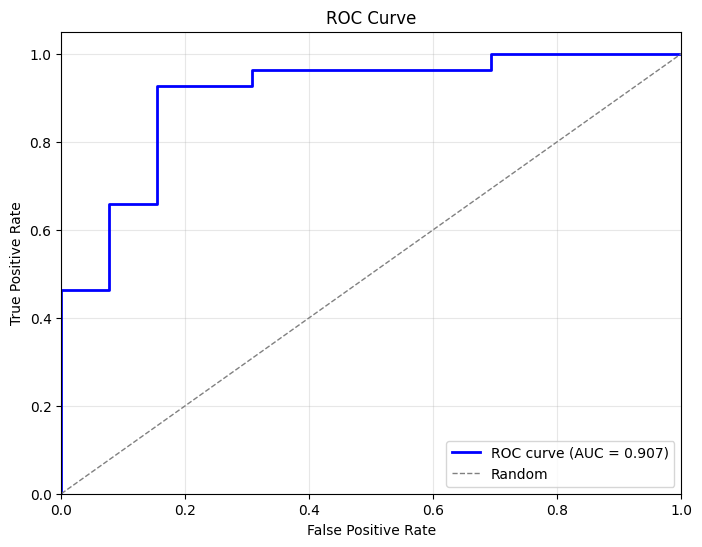


📈 ROC-AUC КРИВАЯ:
   Площадь под кривой (AUC): 0.9071
   Оптимальный порог: 0.9383
   При этом пороге:
     TPR (Recall): 0.9268
     FPR: 0.1538
   ROC curve сохранена как: roc_curve.png

💾 Модель сохранена: mlp_sentiment_model.pkl


In [ ]:
import numpy as np
import joblib
from sentence_transformers import SentenceTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt


class MLPSentimentClassifier:
    """
    MLP классификатор на эмбеддингах с метриками
    """

    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2'):
        """
        Args:
            embedding_model: модель для генерации эмбеддингов
        """
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_model = embedding_model

        self.mlp = MLPClassifier(
            hidden_layer_sizes=(256, 128),
            activation='relu',
            solver='adam',
            max_iter=100,
            random_state=42,
            verbose=False
        )

        self.is_trained = False

    def prepare_data(self, data):
        """
        Извлекаем тексты и метки из данных
        """
        texts = [item['text'] for item in data]
        labels = [item['sentiment'] for item in data]
        return texts, np.array(labels)

    def get_embeddings(self, texts):
        """
        Генерация эмбеддингов для текстов
        """
        return self.embedder.encode(texts, show_progress_bar=False)

    def train(self, train_data):
        """
        Обучение модели
        """
        print("Обучение MLP...")

        # Подготовка данных
        X_train, y_train = self.prepare_data(train_data)

        # Генерация эмбеддингов
        print("Генерация эмбеддингов...")
        X_embeddings = self.get_embeddings(X_train)

        # Обучение MLP
        self.mlp.fit(X_embeddings, y_train)
        self.is_trained = True

        # Оценка на тренировочных данных
        train_pred = self.mlp.predict(X_embeddings)
        train_proba = self.mlp.predict_proba(X_embeddings)

        print("\n=== МЕТРИКИ НА ОБУЧАЮЩЕЙ ВЫБОРКЕ ===")
        self._print_metrics(y_train, train_pred, train_proba)

        return self

    def predict(self, texts):
        """
        Предсказание для списка текстов
        """
        if not self.is_trained:
            raise ValueError("Модель не обучена!")

        embeddings = self.get_embeddings(texts)
        predictions = self.mlp.predict(embeddings)
        probabilities = self.mlp.predict_proba(embeddings)

        return predictions, probabilities

    def evaluate(self, test_data):
        """
        Полная оценка модели на тестовых данных
        """
        X_test, y_test = self.prepare_data(test_data)

        # Предсказание
        predictions, probabilities = self.predict(X_test)

        print("\n" + "="*60)
        print("=== ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ ===")
        print("="*60)

        # Все метрики
        self._print_metrics(y_test, predictions, probabilities)

        # Дополнительно: ROC кривая
        self._plot_roc_curve(y_test, probabilities)

        return {
            'accuracy': accuracy_score(y_test, predictions),
            'precision_macro': precision_score(y_test, predictions, average='macro'),
            'recall_macro': recall_score(y_test, predictions, average='macro'),
            'f1_macro': f1_score(y_test, predictions, average='macro'),
            'precision_micro': precision_score(y_test, predictions, average='micro'),
            'recall_micro': recall_score(y_test, predictions, average='micro'),
            'f1_micro': f1_score(y_test, predictions, average='micro')
        }

    def _print_metrics(self, y_true, y_pred, y_proba):
        """
        Вывод всех метрик
        """
        # Базовые метрики
        print(f"\n📊 ОБЩИЕ МЕТРИКИ:")
        print(f"   Accuracy: {accuracy_score(y_true, y_pred):.4f}")

        # Precision, Recall, F1 для каждого класса и средние
        print(f"\n🎯 ПО КЛАССАМ:")
        target_names = ['Negative', 'Positive']
        print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

        # Macro и Micro средние
        print(f"\n📈 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Precision (micro): {precision_score(y_true, y_pred, average='micro'):.4f}")
        print(f"   Recall (micro): {recall_score(y_true, y_pred, average='micro'):.4f}")
        print(f"   F1-Score (micro): {f1_score(y_true, y_pred, average='micro'):.4f}")

        # ROC-AUC для бинарной классификации
        if len(np.unique(y_true)) == 2:
            # Берем вероятности для положительного класса
            positive_class_idx = list(self.mlp.classes_).index(1) if 1 in self.mlp.classes_ else 1
            roc_auc = roc_auc_score(y_true, y_proba[:, positive_class_idx])
            print(f"   ROC-AUC: {roc_auc:.4f}")

        # Матрица ошибок
        print(f"\n📊 МАТРИЦА ОШИБОК:")
        cm = confusion_matrix(y_true, y_pred)
        self._print_confusion_matrix(cm)

    def _print_confusion_matrix(self, cm):
        """
        Красивый вывод матрицы ошибок
        """
        labels = ['Negative', 'Positive']

        print("             Predicted")
        print("              Neg    Pos")
        print("            ┌──────┬──────┐")
        for i, (label, row) in enumerate(zip(labels, cm)):
            print(f"Actual {label:6} │ {row[0]:4}  │ {row[1]:4} │")
            if i == 0:
                print("            ├──────┼──────┤")
        print("            └──────┴──────┘")

        # Дополнительная информация
        tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else (0, 0, 0, 0)
        print(f"\n📈 ДЕТАЛИЗАЦИЯ:")
        print(f"   True Negative (TN): {tn}")
        print(f"   False Positive (FP): {fp}")
        print(f"   False Negative (FN): {fn}")
        print(f"   True Positive (TP): {tp}")
        print(f"   Общее количество: {tn + fp + fn + tp}")

    def _plot_roc_curve(self, y_true, y_proba):
        """
        Построение ROC-кривой
        """
        if len(np.unique(y_true)) != 2:
            return

        # Определяем индекс положительного класса
        positive_class_idx = list(self.mlp.classes_).index(1) if 1 in self.mlp.classes_ else 1

        # Вычисляем ROC кривую
        fpr, tpr, thresholds = roc_curve(y_true, y_proba[:, positive_class_idx])
        roc_auc = roc_auc_score(y_true, y_proba[:, positive_class_idx])

        # Строим график
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)

        # Сохраняем и показываем
        plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
        plt.show()

        # Вывод AUC
        print(f"\n📈 ROC-AUC КРИВАЯ:")
        print(f"   Площадь под кривой (AUC): {roc_auc:.4f}")

        # Находим оптимальный порог (ближайший к верхнему левому углу)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        print(f"   Оптимальный порог: {optimal_threshold:.4f}")
        print(f"   При этом пороге:")
        print(f"     TPR (Recall): {tpr[optimal_idx]:.4f}")
        print(f"     FPR: {fpr[optimal_idx]:.4f}")
        print(f"   ROC curve сохранена как: roc_curve.png")

    def save(self, filename):
        """
        Сохранение модели
        """
        joblib.dump({
            'mlp_weights': self.mlp.coefs_,
            'mlp_biases': self.mlp.intercepts_,
            'mlp_classes': self.mlp.classes_,
            'embedding_model': self.embedding_model
        }, filename)
        print(f"\n💾 Модель сохранена: {filename}")

    def load(self, filename):
        """
        Загрузка модели
        """
        data = joblib.load(filename)

        self.mlp.coefs_ = data['mlp_weights']
        self.mlp.intercepts_ = data['mlp_biases']
        self.mlp.classes_ = data['mlp_classes']

        if data['embedding_model'] != self.embedding_model:
            self.embedding_model = data['embedding_model']
            self.embedder = SentenceTransformer(self.embedding_model)

        self.is_trained = True
        print(f"📥 Модель загружена: {filename}")


# Минимальная версия с метриками
class SimpleMLPWithMetrics:
    """Минимальная версия с метриками"""

    def __init__(self):
        self.embedder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
        self.mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=50)

    def fit(self, texts, labels):
        """Обучение с выводом метрик"""
        X = self.embedder.encode(texts)
        self.mlp.fit(X, labels)

        # Метрики на обучении
        pred = self.mlp.predict(X)
        print("\n📊 МЕТРИКИ ОБУЧЕНИЯ:")
        print(f"Accuracy: {accuracy_score(labels, pred):.3f}")
        print(f"F1-score: {f1_score(labels, pred, average='macro'):.3f}")

        cm = confusion_matrix(labels, pred)
        print("\nМатрица ошибок:")
        print(cm)

        return self

    def evaluate(self, texts, labels):
        """Оценка на тестовых данных"""
        X = self.embedder.encode(texts)
        pred = self.mlp.predict(X)
        proba = self.mlp.predict_proba(X)

        print("\n📊 ТЕСТОВЫЕ МЕТРИКИ:")
        print(f"Accuracy: {accuracy_score(labels, pred):.3f}")
        print(f"Precision (macro): {precision_score(labels, pred, average='macro'):.3f}")
        print(f"Recall (macro): {recall_score(labels, pred, average='macro'):.3f}")
        print(f"F1-score (macro): {f1_score(labels, pred, average='macro'):.3f}")

        if len(np.unique(labels)) == 2:
            roc_auc = roc_auc_score(labels, proba[:, 1])
            print(f"ROC-AUC: {roc_auc:.3f}")

        print("\nClassification Report:")
        print(classification_report(labels, pred))

        return pred, proba


# Пример использования
def main():
    """
    Пример использования с метриками
    """
    import json

    # Загрузка данных
    def load_jsonl(filepath):
        with open(filepath, 'r', encoding='utf-8') as f:
            return [json.loads(line) for line in f]

    print("🚀 ЗАГРУЗКА ДАННЫХ...")
    train_data = load_jsonl('/content/news_sentiment_train.jsonl')
    test_data = load_jsonl('/content/news_sentiment_test.jsonl')

    print(f"Обучающих примеров: {len(train_data)}")
    print(f"Тестовых примеров: {len(test_data)}")

    # Создаем и обучаем модель
    print("\n🎯 ОБУЧЕНИЕ МОДЕЛИ...")
    model = MLPSentimentClassifier()
    model.train(train_data)

    # Оценка на тестовых данных
    print("\n🧪 ТЕСТИРОВАНИЕ...")
    metrics = model.evaluate(test_data)

    # Сохраняем модель
    model.save('mlp_sentiment_model.pkl')

if __name__ == "__main__":
    main()

PyTorch версия: 2.9.0+cu126
CUDA доступен: True
🚀 ЗАПУСК CNN КЛАССИФИКАТОРА
📊 Обучающих примеров: 441
📊 Тестовых примеров: 95

🎯 ВАРИАНТ 1: УПРОЩЕННАЯ CNN
📱 Используемое устройство: cuda
🎯 ОБУЧЕНИЕ УПРОЩЕННОЙ CNN...
📊 Примеров: 441
📈 Эпоха 1/8 - Loss: 0.4346, Accuracy: 0.871
📈 Эпоха 2/8 - Loss: 0.3300, Accuracy: 0.871
📈 Эпоха 3/8 - Loss: 0.2814, Accuracy: 0.909
📈 Эпоха 4/8 - Loss: 0.2320, Accuracy: 0.896
📈 Эпоха 5/8 - Loss: 0.2264, Accuracy: 0.948
📈 Эпоха 6/8 - Loss: 0.2176, Accuracy: 0.946
📈 Эпоха 7/8 - Loss: 0.1728, Accuracy: 0.934
📈 Эпоха 8/8 - Loss: 0.1692, Accuracy: 0.957

✅ ОБУЧЕНИЕ ЗАВЕРШЕНО

🧪 ТЕСТИРОВАНИЕ УПРОЩЕННОЙ CNN:

📊 МЕТРИКИ УПРОЩЕННОЙ CNN

🎯 Accuracy: 0.9368

📈 Classification Report:
              precision    recall  f1-score   support

           0     0.7333    0.8462    0.7857        13
           1     0.9750    0.9512    0.9630        82

    accuracy                         0.9368        95
   macro avg     0.8542    0.8987    0.8743        95
weighted avg     0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


📊 ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ

📊 МЕТРИКИ ДЛЯ ТЕСТОВАЯ ВЫБОРКА:
   Количество примеров: 4

🎯 Accuracy: 0.7500

📈 Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.7500    1.0000    0.8571         3

    accuracy                         0.7500         4
   macro avg     0.3750    0.5000    0.4286         4
weighted avg     0.5625    0.7500    0.6429         4


📊 СРЕДНИЕ МЕТРИКИ:
   Precision (macro): 0.3750
   Recall (macro): 0.5000
   F1-Score (macro): 0.4286
   Precision (micro): 0.7500
   Recall (micro): 0.7500
   F1-Score (micro): 0.7500
   ROC-AUC: 0.6667

📊 МАТРИЦА ОШИБОК:
             Предсказано
              0      1
            ┌──────┬──────┐
Фактическое 0 │    0  │    1 │
            ├──────┼──────┤
Фактическое 1 │    0  │    3 │
            └──────┴──────┘

📈 ДЕТАЛИЗАЦИЯ:
   True Negative (TN): 0
   False Positive (FP): 1
   False Negative (FN): 0
   True Positive (TP): 3
  

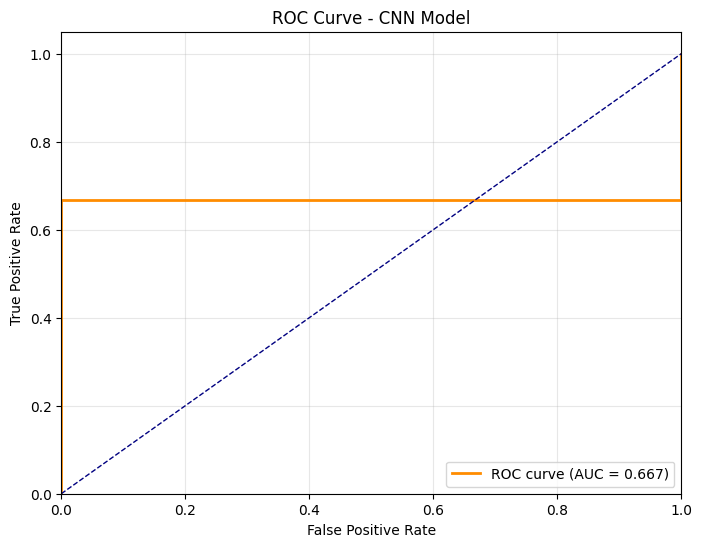


📈 ROC curve сохранена как: cnn_roc_curve.png

💾 CNN модель сохранена: full_cnn_model.pth


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sentence_transformers import SentenceTransformer
import joblib
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve)
import matplotlib.pyplot as plt


class TextCNN(nn.Module):
    """
    Простая CNN архитектура для текста
    """
    def __init__(self, embedding_dim=384, num_filters=100, filter_sizes=[2, 3, 4], num_classes=2, dropout=0.5):
        super(TextCNN, self).__init__()

        # Сверточные слои
        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=filter_sizes[0], padding=1)
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size=filter_sizes[1], padding=1)
        self.conv3 = nn.Conv1d(num_filters, num_filters, kernel_size=filter_sizes[2], padding=1)

        # Полносвязный слой
        self.fc = nn.Linear(num_filters * 3, num_classes)  # 3 слоя conv

        # Dropout
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.MaxPool1d(2)

    def forward(self, x):
        """
        x: [batch_size, embedding_dim, seq_len]
        """
        # Первая свертка + pooling
        x1 = F.relu(self.conv1(x))
        x1 = self.pool(x1)

        # Вторая свертка + pooling
        x2 = F.relu(self.conv2(x1))
        x2 = self.pool(x2)

        # Третья свертка + pooling
        x3 = F.relu(self.conv3(x2))
        x3 = self.pool(x3)

        # Global average pooling
        x1_pool = F.adaptive_avg_pool1d(x1, 1).squeeze(2)
        x2_pool = F.adaptive_avg_pool1d(x2, 1).squeeze(2)
        x3_pool = F.adaptive_avg_pool1d(x3, 1).squeeze(2)

        # Объединяем
        combined = torch.cat([x1_pool, x2_pool, x3_pool], dim=1)

        # Dropout и полносвязный слой
        combined = self.dropout(combined)
        output = self.fc(combined)

        return output


class CNNSentimentClassifier:
    """
    CNN классификатор для анализа тональности
    """

    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
                 max_seq_len=100, batch_size=16):
        """
        Args:
            embedding_model: модель для эмбеддингов
            max_seq_len: максимальная длина последовательности
            batch_size: размер батча
        """
        # Проверяем доступность CUDA
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")

        # Загружаем модель эмбеддингов
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_model_name = embedding_model
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # Параметры
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size

        # Создаем CNN модель
        self.model = TextCNN(
            embedding_dim=self.embedding_dim,
            num_filters=128,
            filter_sizes=[2, 3, 4],
            num_classes=2,
            dropout=0.3
        ).to(self.device)

        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных из списка словарей
        """
        texts = []
        labels = []
        for item in data:
            if isinstance(item, dict) and 'text' in item and 'sentiment' in item:
                texts.append(item['text'])
                labels.append(item['sentiment'])
            else:
                print(f"⚠️ Пропущен невалидный элемент: {item}")

        return texts, np.array(labels)

    def create_embeddings_sequence(self, texts):
        """
        Создание последовательности эмбеддингов для CNN
        """
        embeddings_list = []

        for text in texts:
            # Получаем эмбеддинг предложения
            sentence_embedding = self.embedder.encode(text, show_progress_bar=False)

            # Создаем последовательность, повторяя эмбеддинг
            # Это упрощение - в реальности нужно использовать токенизацию
            sequence = np.tile(sentence_embedding, (self.max_seq_len, 1))

            # Обрезаем/дополняем до нужной длины
            if sequence.shape[0] > self.max_seq_len:
                sequence = sequence[:self.max_seq_len, :]
            elif sequence.shape[0] < self.max_seq_len:
                # Дополняем нулями
                padding = np.zeros((self.max_seq_len - sequence.shape[0], self.embedding_dim))
                sequence = np.vstack([sequence, padding])

            embeddings_list.append(sequence)

        return np.array(embeddings_list)

    def train(self, train_data, epochs=10, lr=0.001):
        """
        Обучение модели
        """
        print("🎯 НАЧИНАЕМ ОБУЧЕНИЕ CNN...")

        # Подготовка данных
        texts, labels = self.prepare_data(train_data)

        if len(texts) == 0:
            print("❌ Нет данных для обучения")
            return

        print(f"📊 Загружено {len(texts)} примеров")
        print(f"📊 Размерность эмбеддингов: {self.embedding_dim}")
        print(f"📊 Максимальная длина последовательности: {self.max_seq_len}")

        # Создаем последовательности эмбеддингов
        print("🔍 Создание последовательностей эмбеддингов...")
        X_sequences = self.create_embeddings_sequence(texts)

        # Преобразуем в тензоры
        X_tensor = torch.FloatTensor(X_sequences).to(self.device)
        y_tensor = torch.LongTensor(labels).to(self.device)

        # Транспонируем для Conv1d: [batch, embedding_dim, seq_len]
        X_tensor = X_tensor.transpose(1, 2)

        print(f"📊 Размерность данных: {X_tensor.shape}")

        # Оптимизатор и функция потерь
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        for epoch in range(epochs):
            total_loss = 0
            indices = torch.randperm(len(X_tensor))

            for i in range(0, len(indices), self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                batch_X = X_tensor[batch_indices]
                batch_y = y_tensor[batch_indices]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # Вычисляем accuracy
            with torch.no_grad():
                self.model.eval()
                outputs = self.model(X_tensor)
                _, preds = torch.max(outputs, 1)
                accuracy = (preds == y_tensor).float().mean().item()
                self.model.train()

            avg_loss = total_loss / (len(X_tensor) / self.batch_size)

            print(f"📈 Эпоха {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.3f}")

        self.is_trained = True

        # Финальная оценка
        print("\n✅ ОБУЧЕНИЕ ЗАВЕРШЕНО")

        # Метрики на обучающих данных
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, preds = torch.max(outputs, 1)
            probabilities = F.softmax(outputs, dim=1)

        self._print_metrics(labels, preds.cpu().numpy(), probabilities.cpu().numpy(), "ОБУЧАЮЩАЯ ВЫБОРКА")

        return avg_loss

    def predict(self, texts):
        """
        Предсказание для списка текстов
        """
        if not self.is_trained:
            raise ValueError("❌ Модель не обучена!")

        # Создаем последовательности
        sequences = self.create_embeddings_sequence(texts)

        # Преобразуем в тензор
        X_tensor = torch.FloatTensor(sequences).to(self.device)
        X_tensor = X_tensor.transpose(1, 2)

        # Предсказание
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs, 1)

        return predictions.cpu().numpy(), probabilities.cpu().numpy()

    def predict_single(self, text):
        """
        Предсказание для одного текста
        """
        preds, probs = self.predict([text])

        return {
            'prediction': int(preds[0]),
            'positive_prob': float(probs[0][1]),
            'negative_prob': float(probs[0][0]),
            'confidence': float(max(probs[0]))
        }

    def evaluate(self, test_data):
        """
        Полная оценка модели
        """
        texts, true_labels = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return None

        # Предсказание
        predictions, probabilities = self.predict(texts)

        print("\n" + "="*60)
        print("📊 ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
        print("="*60)

        # Все метрики
        self._print_metrics(true_labels, predictions, probabilities, "ТЕСТОВАЯ ВЫБОРКА")

        # ROC кривая
        if len(np.unique(true_labels)) == 2:
            self._plot_roc_curve(true_labels, probabilities)

        return {
            'accuracy': accuracy_score(true_labels, predictions),
            'predictions': predictions,
            'probabilities': probabilities
        }

    def _print_metrics(self, y_true, y_pred, y_proba=None, dataset_name=""):
        """
        Вывод всех метрик
        """
        print(f"\n📊 МЕТРИКИ ДЛЯ {dataset_name}:")
        print(f"   Количество примеров: {len(y_true)}")

        # Accuracy
        acc = accuracy_score(y_true, y_pred)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report
        print("\n📈 Classification Report:")
        print(classification_report(y_true, y_pred, digits=4))

        # Macro и Micro средние
        print(f"\n📊 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Precision (micro): {precision_score(y_true, y_pred, average='micro'):.4f}")
        print(f"   Recall (micro): {recall_score(y_true, y_pred, average='micro'):.4f}")
        print(f"   F1-Score (micro): {f1_score(y_true, y_pred, average='micro'):.4f}")

        # ROC-AUC
        if y_proba is not None and len(np.unique(y_true)) == 2:
            try:
                roc_auc = roc_auc_score(y_true, y_proba[:, 1])
                print(f"   ROC-AUC: {roc_auc:.4f}")
            except:
                pass

        # Матрица ошибок
        print(f"\n📊 МАТРИЦА ОШИБОК:")
        cm = confusion_matrix(y_true, y_pred)

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            print(f"             Предсказано")
            print(f"              0      1")
            print(f"            ┌──────┬──────┐")
            print(f"Фактическое 0 │ {tn:4}  │ {fp:4} │")
            print(f"            ├──────┼──────┤")
            print(f"Фактическое 1 │ {fn:4}  │ {tp:4} │")
            print(f"            └──────┴──────┘")

            print(f"\n📈 ДЕТАЛИЗАЦИЯ:")
            print(f"   True Negative (TN): {tn}")
            print(f"   False Positive (FP): {fp}")
            print(f"   False Negative (FN): {fn}")
            print(f"   True Positive (TP): {tp}")
            print(f"   Общее количество: {tn + fp + fn + tp}")
        else:
            print(cm)

    def _plot_roc_curve(self, y_true, y_proba):
        """
        Построение ROC-кривой
        """
        if len(np.unique(y_true)) != 2 or y_proba is None:
            return

        try:
            fpr, tpr, thresholds = roc_curve(y_true, y_proba[:, 1])
            roc_auc = roc_auc_score(y_true, y_proba[:, 1])

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2,
                    label=f'ROC curve (AUC = {roc_auc:.3f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve - CNN Model')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)

            plt.savefig('cnn_roc_curve.png', dpi=150, bbox_inches='tight')
            plt.show()
            print(f"\n📈 ROC curve сохранена как: cnn_roc_curve.png")
        except Exception as e:
            print(f"⚠️ Не удалось построить ROC curve: {e}")

    def save(self, filename):
        """
        Сохранение модели
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'embedding_model': self.embedding_model_name,
            'embedding_dim': self.embedding_dim,
            'max_seq_len': self.max_seq_len,
            'is_trained': self.is_trained
        }, filename)
        print(f"\n💾 CNN модель сохранена: {filename}")

    def load(self, filename):
        """
        Загрузка модели
        """
        checkpoint = torch.load(filename, map_location=self.device)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

        self.embedding_model_name = checkpoint['embedding_model']
        self.embedding_dim = checkpoint['embedding_dim']
        self.max_seq_len = checkpoint['max_seq_len']
        self.is_trained = checkpoint['is_trained']

        print(f"📥 CNN модель загружена: {filename}")


# УПРОЩЕННАЯ ВЕРСИЯ - РЕКОМЕНДУЕТСЯ ДЛЯ НАЧАЛА
class SimpleTextCNN:
    """
    Упрощенная CNN для текста - минимальный код
    """

    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2'):
        # Устройство
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")

        # Модель для эмбеддингов
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # Простая CNN архитектура
        self.model = nn.Sequential(
            # Conv1d принимает [batch, channels, seq_len]
            # У нас channels = embedding_dim, seq_len = 100 (например)
            nn.Conv1d(self.embedding_dim, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),

            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        ).to(self.device)

        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных
        """
        texts = []
        labels = []

        for item in data:
            if isinstance(item, dict):
                texts.append(item.get('text', ''))
                labels.append(item.get('sentiment', 0))
            else:
                print(f"⚠️ Пропущен невалидный элемент")

        return texts, np.array(labels)

    def create_input_tensor(self, texts, seq_len=100):
        """
        Создание входного тензора для CNN
        """
        embeddings = []

        for text in texts:
            # Получаем эмбеддинг текста
            emb = self.embedder.encode(text, show_progress_bar=False)

            # Создаем последовательность: повторяем эмбеддинг seq_len раз
            seq = np.tile(emb, (seq_len, 1))

            # Обрезаем до нужной длины
            if seq.shape[0] > seq_len:
                seq = seq[:seq_len]
            elif seq.shape[0] < seq_len:
                # Дополняем нулями
                pad_len = seq_len - seq.shape[0]
                padding = np.zeros((pad_len, self.embedding_dim))
                seq = np.vstack([seq, padding])

            embeddings.append(seq)

        # Преобразуем в тензор и транспонируем для Conv1d
        tensor = torch.FloatTensor(np.array(embeddings)).to(self.device)
        tensor = tensor.transpose(1, 2)  # [batch, embedding_dim, seq_len]

        return tensor

    def train(self, train_data, epochs=10, lr=0.001):
        """
        Обучение модели
        """
        print("🎯 ОБУЧЕНИЕ УПРОЩЕННОЙ CNN...")

        # Подготовка данных
        texts, labels = self.prepare_data(train_data)

        if len(texts) == 0:
            print("❌ Нет данных для обучения")
            return

        print(f"📊 Примеров: {len(texts)}")

        # Создаем тензоры
        X = self.create_input_tensor(texts, seq_len=50)  # Используем более короткие последовательности
        y = torch.LongTensor(labels).to(self.device)

        # Оптимизатор и функция потерь
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        for epoch in range(epochs):
            # Перемешиваем данные
            indices = torch.randperm(len(X))
            total_loss = 0

            for i in range(0, len(indices), 8):  # Мини-батчи по 8
                batch_idx = indices[i:i+8]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # Оценка accuracy
            with torch.no_grad():
                self.model.eval()
                outputs = self.model(X)
                _, preds = torch.max(outputs, 1)
                accuracy = (preds == y).float().mean().item()
                self.model.train()

            avg_loss = total_loss / (len(indices) / 8)

            print(f"📈 Эпоха {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.3f}")

        self.is_trained = True
        print("\n✅ ОБУЧЕНИЕ ЗАВЕРШЕНО")

        return self

    def predict(self, texts):
        """
        Предсказание
        """
        if not self.is_trained:
            raise ValueError("❌ Модель не обучена!")

        self.model.eval()
        X = self.create_input_tensor(texts, seq_len=50)

        with torch.no_grad():
            outputs = self.model(X)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, 1)

        return preds.cpu().numpy(), probs.cpu().numpy()

    def evaluate_with_metrics(self, test_data):
        """
        Оценка с выводом метрик
        """
        texts, true_labels = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return

        preds, probs = self.predict(texts)

        print("\n" + "="*60)
        print("📊 МЕТРИКИ УПРОЩЕННОЙ CNN")
        print("="*60)

        # Accuracy
        acc = accuracy_score(true_labels, preds)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report
        print("\n📈 Classification Report:")
        print(classification_report(true_labels, preds, digits=4))

        # Дополнительные метрики
        print(f"\n📊 Дополнительные метрики:")
        print(f"   Precision (macro): {precision_score(true_labels, preds, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(true_labels, preds, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(true_labels, preds, average='macro'):.4f}")

        # ROC-AUC если бинарная классификация
        if len(np.unique(true_labels)) == 2:
            try:
                roc_auc = roc_auc_score(true_labels, probs[:, 1])
                print(f"   ROC-AUC: {roc_auc:.4f}")
            except:
                pass

        # Матрица ошибок
        cm = confusion_matrix(true_labels, preds)
        print(f"\n📊 Матрица ошибок:")
        print(cm)

        return preds, probs


# ПРИМЕР ИСПОЛЬЗОВАНИЯ
def main():
    """
    Основная функция для тестирования
    """
    print("🚀 ЗАПУСК CNN КЛАССИФИКАТОРА")
    print("="*60)

    import json

    # Загрузка данных
    def load_jsonl(filepath):
        with open(filepath, 'r', encoding='utf-8') as f:
            return [json.loads(line) for line in f]

    # Увеличиваем данные для обучения
    train_data = load_jsonl('/content/news_sentiment_train.jsonl')
    test_data = load_jsonl('/content/news_sentiment_test.jsonl')

    print(f"📊 Обучающих примеров: {len(train_data)}")
    print(f"📊 Тестовых примеров: {len(test_data)}")

    # Вариант 1: Упрощенная CNN (рекомендуется)
    print("\n" + "="*60)
    print("🎯 ВАРИАНТ 1: УПРОЩЕННАЯ CNN")
    print("="*60)

    simple_cnn = SimpleTextCNN()
    simple_cnn.train(train_data, epochs=8, lr=0.001)

    print("\n🧪 ТЕСТИРОВАНИЕ УПРОЩЕННОЙ CNN:")
    preds, probs = simple_cnn.evaluate_with_metrics(test_data)

    # Вариант 2: Полная CNN (если нужна)
    print("\n" + "="*60)
    print("🎯 ВАРИАНТ 2: ПОЛНАЯ CNN АРХИТЕКТУРА")
    print("="*60)

    try:
        full_cnn = CNNSentimentClassifier(
            embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
            max_seq_len=50,
            batch_size=8
        )

        # Используем меньше данных для скорости
        small_train = train_data[:20]
        full_cnn.train(small_train, epochs=5, lr=0.001)

        print("\n🧪 ТЕСТИРОВАНИЕ ПОЛНОЙ CNN:")
        results = full_cnn.evaluate(test_data[:4])

        # Сохранение модели
        full_cnn.save('full_cnn_model.pth')

    except Exception as e:
        print(f"⚠️ Ошибка в полной CNN: {e}")
        print("Рекомендуется использовать SimpleTextCNN")


if __name__ == "__main__":
    # Проверяем зависимости
    print(f"PyTorch версия: {torch.__version__}")
    print(f"CUDA доступен: {torch.cuda.is_available()}")

    # Запускаем
    main()

PyTorch версия: 2.9.0+cu126
CUDA доступен: True
CUDA устройство: Tesla T4
📂 ЗАГРУЗКА ДАННЫХ...
📊 Обучающих примеров: 441
📊 Тестовых примеров: 95
📝 Пример записи: ['title', 'text', 'sentiment', 'category']
📝 Длина текста: 518 символов
📝 Метка: 0

🎯 СОЗДАНИЕ И ОБУЧЕНИЕ LSTM МОДЕЛИ
📱 Используемое устройство: cuda
🎯 ОБУЧЕНИЕ LSTM...
📊 Примеров: 441
📈 Эпоха 1/8 - Loss: 0.4157, Accuracy: 0.871
📈 Эпоха 2/8 - Loss: 0.3514, Accuracy: 0.907
📈 Эпоха 3/8 - Loss: 0.2824, Accuracy: 0.921
📈 Эпоха 4/8 - Loss: 0.2321, Accuracy: 0.907
📈 Эпоха 5/8 - Loss: 0.2423, Accuracy: 0.930
📈 Эпоха 6/8 - Loss: 0.1950, Accuracy: 0.921
📈 Эпоха 7/8 - Loss: 0.1875, Accuracy: 0.957
📈 Эпоха 8/8 - Loss: 0.1501, Accuracy: 0.968

✅ ОБУЧЕНИЕ ЗАВЕРШЕНО

🧪 ОЦЕНКА МОДЕЛИ...

📊 МЕТРИКИ LSTM

🎯 Accuracy: 0.9053

📈 Classification Report:
              precision    recall  f1-score   support

           0     0.6111    0.8462    0.7097        13
           1     0.9740    0.9146    0.9434        82

    accuracy                     

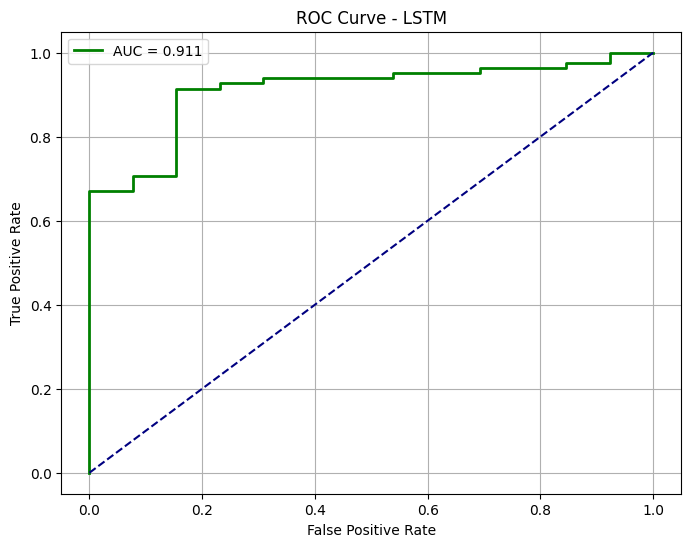


📊 МАТРИЦА ОШИБОК:
             Предсказано
              0      1
            ┌──────┬──────┐
Фактическое 0 │   11  │    2 │
            ├──────┼──────┤
Фактическое 1 │    7  │   75 │
            └──────┴──────┘

🧪 ТЕСТОВЫЕ ПРЕДСКАЗАНИЯ:

📝 Пример 1:
   Текст: Бүген «Татарстан – Яңа гасыр» телерадиокомпаниясенең «ШАЯН ТВ» балалар телеканалы студиясендә яңа «Ш...
   Истинная тональность: 1
   Предсказанная тональность: 1
   Уверенность: 0.997
   Верно: ✅

📝 Пример 2:
   Текст: Удмуртиянең « Яңарыш » газетасында Эльвира Хуҗина ның «Хәйрия гадәткә әйләнсен иде» дигән язмасы чык...
   Истинная тональность: 1
   Предсказанная тональность: 1
   Уверенность: 0.965
   Верно: ✅

📝 Пример 3:
   Текст: Татарстанда 21.15 сәгатьтә пилотсыз куркыныч режимы гамәлгә кертелде. Бу хакта мәгълүмат Россия Гадә...
   Истинная тональность: 0
   Предсказанная тональность: 0
   Уверенность: 0.978
   Верно: ✅
💾 Модель сохранена: lstm_sentiment_model.pth

🧪 ТЕСТ ЗАГРУЗКИ МОДЕЛИ...
📱 Используемое устройство: cu

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve)
import matplotlib.pyplot as plt


class TextLSTM(nn.Module):
    """
    LSTM модель для классификации текста
    """
    def __init__(self, embedding_dim=384, hidden_dim=256, num_layers=2,
                 num_classes=2, dropout=0.5, bidirectional=True):
        super(TextLSTM, self).__init__()

        # Параметры LSTM
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # LSTM слой
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True
        )

        # Определяем размер выхода LSTM
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        # Полносвязный слой для классификации
        self.fc = nn.Linear(lstm_output_dim, num_classes)

        # Dropout для регуляризации
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        x: [batch_size, seq_len, embedding_dim]
        """
        batch_size = x.size(0)

        # Инициализируем скрытые состояния
        device = x.device
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1),
                        batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1),
                        batch_size, self.hidden_dim).to(device)

        # Прямой проход через LSTM
        lstm_out, (hidden, cell) = self.lstm(x, (h0, c0))

        # Для бидирекционального LSTM берем последние скрытые состояния обоих направлений
        if self.bidirectional:
            # hidden: [num_layers * 2, batch_size, hidden_dim]
            hidden = hidden.view(self.num_layers, 2, batch_size, self.hidden_dim)
            # Берем последний слой
            hidden_last_layer = hidden[-1]
            # Объединяем forward и backward
            hidden_concat = torch.cat((hidden_last_layer[0], hidden_last_layer[1]), dim=1)
        else:
            # hidden: [num_layers, batch_size, hidden_dim]
            hidden_concat = hidden[-1]

        # Применяем dropout
        hidden_concat = self.dropout(hidden_concat)

        # Полносвязный слой
        output = self.fc(hidden_concat)

        return output


class LSTMSentimentClassifier:
    """
    LSTM классификатор для анализа тональности
    """

    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
                 max_seq_len=100, batch_size=16):
        """
        Args:
            embedding_model: модель для эмбеддингов
            max_seq_len: максимальная длина последовательности
            batch_size: размер батча
        """
        # Проверяем доступность CUDA
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")

        # Загружаем модель эмбеддингов
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_model_name = embedding_model
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # Параметры
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size

        # Создаем LSTM модель
        self.model = TextLSTM(
            embedding_dim=self.embedding_dim,
            hidden_dim=256,
            num_layers=2,
            num_classes=2,
            dropout=0.3,
            bidirectional=True
        ).to(self.device)

        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных из списка словарей
        """
        texts = []
        labels = []

        for item in data:
            if isinstance(item, dict):
                texts.append(item.get('text', ''))
                labels.append(item.get('sentiment', 0))

        return texts, np.array(labels)

    def create_embeddings_sequence(self, texts):
        """
        Создание последовательности эмбеддингов для LSTM
        """
        embeddings_list = []

        for text in texts:
            # Получаем эмбеддинг предложения
            sentence_embedding = self.embedder.encode(text, show_progress_bar=False)

            # Создаем последовательность, повторяя эмбеддинг
            sequence = np.tile(sentence_embedding, (self.max_seq_len, 1))

            # Обрезаем до нужной длины
            if sequence.shape[0] > self.max_seq_len:
                sequence = sequence[:self.max_seq_len, :]
            elif sequence.shape[0] < self.max_seq_len:
                # Дополняем нулями
                pad_len = self.max_seq_len - sequence.shape[0]
                padding = np.zeros((pad_len, self.embedding_dim))
                sequence = np.vstack([sequence, padding])

            embeddings_list.append(sequence)

        return np.array(embeddings_list)

    def train(self, train_data, epochs=10, lr=0.001):
        """
        Обучение LSTM модели
        """
        print("🎯 НАЧИНАЕМ ОБУЧЕНИЕ LSTM...")

        # Подготовка данных
        texts, labels = self.prepare_data(train_data)

        if len(texts) == 0:
            print("❌ Нет данных для обучения")
            return

        print(f"📊 Загружено {len(texts)} примеров")
        print(f"📊 Размерность эмбеддингов: {self.embedding_dim}")
        print(f"📊 Максимальная длина последовательности: {self.max_seq_len}")

        # Создаем последовательности эмбеддингов
        print("🔍 Создание последовательностей эмбеддингов...")
        X_sequences = self.create_embeddings_sequence(texts)

        # Преобразуем в тензоры
        X_tensor = torch.FloatTensor(X_sequences).to(self.device)
        y_tensor = torch.LongTensor(labels).to(self.device)

        print(f"📊 Размерность данных: {X_tensor.shape}")

        # Оптимизатор и функция потерь
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        for epoch in range(epochs):
            total_loss = 0
            indices = torch.randperm(len(X_tensor))
            num_batches = max(1, len(indices) // self.batch_size)

            for i in range(0, len(indices), self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                batch_X = X_tensor[batch_indices]
                batch_y = y_tensor[batch_indices]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Gradient clipping для стабильности LSTM
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                total_loss += loss.item()

            # Вычисляем accuracy
            with torch.no_grad():
                self.model.eval()
                outputs = self.model(X_tensor)
                _, preds = torch.max(outputs, 1)
                accuracy = (preds == y_tensor).float().mean().item()
                self.model.train()

            avg_loss = total_loss / num_batches

            print(f"📈 Эпоха {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.3f}")

        self.is_trained = True

        # Финальная оценка
        print("\n✅ ОБУЧЕНИЕ LSTM ЗАВЕРШЕНО")

        # Метрики на обучающих данных
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, preds = torch.max(outputs, 1)
            probabilities = F.softmax(outputs, dim=1)

        self._print_metrics(labels, preds.cpu().numpy(), probabilities.cpu().numpy(), "ОБУЧАЮЩАЯ ВЫБОРКА")

        return avg_loss

    def predict(self, texts):
        """
        Предсказание для списка текстов
        """
        if not self.is_trained:
            raise ValueError("❌ Модель не обучена!")

        # Создаем последовательности
        sequences = self.create_embeddings_sequence(texts)

        # Преобразуем в тензор
        X_tensor = torch.FloatTensor(sequences).to(self.device)

        # Предсказание
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs, 1)

        return predictions.cpu().numpy(), probabilities.cpu().numpy()

    def predict_single(self, text):
        """
        Предсказание для одного текста
        """
        preds, probs = self.predict([text])

        return {
            'prediction': int(preds[0]),
            'positive_prob': float(probs[0][1]),
            'negative_prob': float(probs[0][0]),
            'confidence': float(max(probs[0]))
        }

    def evaluate(self, test_data):
        """
        Полная оценка модели
        """
        texts, true_labels = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return None

        # Предсказание
        predictions, probabilities = self.predict(texts)

        print("\n" + "="*60)
        print("📊 ОЦЕНКА LSTM НА ТЕСТОВОЙ ВЫБОРКЕ")
        print("="*60)

        # Все метрики
        self._print_metrics(true_labels, predictions, probabilities, "ТЕСТОВАЯ ВЫБОРКА")

        # ROC кривая
        if len(np.unique(true_labels)) == 2:
            self._plot_roc_curve(true_labels, probabilities)

        return {
            'accuracy': accuracy_score(true_labels, predictions),
            'predictions': predictions,
            'probabilities': probabilities
        }

    def _print_metrics(self, y_true, y_pred, y_proba=None, dataset_name=""):
        """
        Вывод всех метрик
        """
        print(f"\n📊 МЕТРИКИ ДЛЯ {dataset_name}:")
        print(f"   Количество примеров: {len(y_true)}")

        # Accuracy
        acc = accuracy_score(y_true, y_pred)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report
        print("\n📈 Classification Report:")
        print(classification_report(y_true, y_pred, digits=4))

        # Macro и Micro средние
        print(f"\n📊 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Precision (micro): {precision_score(y_true, y_pred, average='micro'):.4f}")
        print(f"   Recall (micro): {recall_score(y_true, y_pred, average='micro'):.4f}")
        print(f"   F1-Score (micro): {f1_score(y_true, y_pred, average='micro'):.4f}")

        # ROC-AUC
        if y_proba is not None and len(np.unique(y_true)) == 2:
            try:
                roc_auc = roc_auc_score(y_true, y_proba[:, 1])
                print(f"   ROC-AUC: {roc_auc:.4f}")
            except:
                pass

        # Матрица ошибок
        print(f"\n📊 МАТРИЦА ОШИБОК:")
        cm = confusion_matrix(y_true, y_pred)

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            print(f"             Предсказано")
            print(f"              0      1")
            print(f"            ┌──────┬──────┐")
            print(f"Фактическое 0 │ {tn:4}  │ {fp:4} │")
            print(f"            ├──────┼──────┤")
            print(f"Фактическое 1 │ {fn:4}  │ {tp:4} │")
            print(f"            └──────┴──────┘")

            print(f"\n📈 ДЕТАЛИЗАЦИЯ:")
            print(f"   True Negative (TN): {tn}")
            print(f"   False Positive (FP): {fp}")
            print(f"   False Negative (FN): {fn}")
            print(f"   True Positive (TP): {tp}")
        else:
            print(cm)

    def _plot_roc_curve(self, y_true, y_proba):
        """
        Построение ROC-кривой
        """
        if len(np.unique(y_true)) != 2 or y_proba is None:
            return

        try:
            fpr, tpr, thresholds = roc_curve(y_true, y_proba[:, 1])
            roc_auc = roc_auc_score(y_true, y_proba[:, 1])

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='green', lw=2,
                    label=f'ROC curve (AUC = {roc_auc:.3f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve - LSTM Model')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)

            plt.savefig('lstm_roc_curve.png', dpi=150, bbox_inches='tight')
            plt.show()
            print(f"\n📈 ROC curve сохранена как: lstm_roc_curve.png")
        except Exception as e:
            print(f"⚠️ Не удалось построить ROC curve: {e}")

    def save(self, filename):
        """
        Сохранение модели
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'embedding_model': self.embedding_model_name,
            'embedding_dim': self.embedding_dim,
            'max_seq_len': self.max_seq_len,
            'is_trained': self.is_trained
        }, filename)
        print(f"\n💾 LSTM модель сохранена: {filename}")

    def load(self, filename):
        """
        Загрузка модели
        """
        checkpoint = torch.load(filename, map_location=self.device)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

        self.embedding_model_name = checkpoint['embedding_model']
        self.embedding_dim = checkpoint['embedding_dim']
        self.max_seq_len = checkpoint['max_seq_len']
        self.is_trained = checkpoint['is_trained']

        print(f"📥 LSTM модель загружена: {filename}")


# ИСПРАВЛЕННАЯ УПРОЩЕННАЯ ВЕРСИЯ LSTM
class SimpleTextLSTM(nn.Module):
    """
    Упрощенная LSTM модель
    """

    def __init__(self, embedding_dim=384, hidden_dim=128, num_classes=2):
        super(SimpleTextLSTM, self).__init__()

        # LSTM слой
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        # Классификатор
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, 64),  # *2 для bidirectional
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # LSTM forward
        lstm_out, (hidden, cell) = self.lstm(x)

        # Берем последний выход
        last_output = lstm_out[:, -1, :]

        # Классификация
        output = self.classifier(last_output)

        return output


class SimpleLSTMClassifier:
    """
    Обертка для упрощенной LSTM
    """

    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2'):
        # Устройство
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")

        # Модель для эмбеддингов
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # Создаем LSTM модель
        self.model = SimpleTextLSTM(
            embedding_dim=self.embedding_dim,
            hidden_dim=128,
            num_classes=2
        ).to(self.device)

        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных
        """
        texts = []
        labels = []

        for item in data:
            if isinstance(item, dict):
                texts.append(item.get('text', ''))
                labels.append(item.get('sentiment', 0))

        return texts, np.array(labels)

    def create_input_tensor(self, texts, seq_len=50):
        """
        Создание входного тензора для LSTM
        """
        embeddings = []

        for text in texts:
            # Получаем эмбеддинг текста
            emb = self.embedder.encode(text, show_progress_bar=False)

            # Создаем последовательность: повторяем эмбеддинг
            seq = np.tile(emb, (seq_len, 1))

            # Обрезаем до нужной длины
            if seq.shape[0] > seq_len:
                seq = seq[:seq_len]
            elif seq.shape[0] < seq_len:
                # Дополняем нулями
                pad_len = seq_len - seq.shape[0]
                padding = np.zeros((pad_len, self.embedding_dim))
                seq = np.vstack([seq, padding])

            embeddings.append(seq)

        # Преобразуем в тензор
        tensor = torch.FloatTensor(np.array(embeddings)).to(self.device)

        return tensor

    def train(self, train_data, epochs=10, lr=0.001):
        """
        Обучение модели
        """
        print("🎯 ОБУЧЕНИЕ LSTM...")

        # Подготовка данных
        texts, labels = self.prepare_data(train_data)

        if len(texts) == 0:
            print("❌ Нет данных для обучения")
            return

        print(f"📊 Примеров: {len(texts)}")

        # Создаем тензоры
        X = self.create_input_tensor(texts, seq_len=50)
        y = torch.LongTensor(labels).to(self.device)

        # Оптимизатор и функция потерь
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        for epoch in range(epochs):
            # Перемешиваем данные
            indices = torch.randperm(len(X))
            total_loss = 0
            num_batches = max(1, len(indices) // 8)

            for i in range(0, len(indices), 8):
                batch_idx = indices[i:i+8]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                total_loss += loss.item()

            # Оценка accuracy
            with torch.no_grad():
                self.model.eval()
                outputs = self.model(X)
                _, preds = torch.max(outputs, 1)
                accuracy = (preds == y).float().mean().item()
                self.model.train()

            avg_loss = total_loss / num_batches

            print(f"📈 Эпоха {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.3f}")

        self.is_trained = True
        print("\n✅ ОБУЧЕНИЕ ЗАВЕРШЕНО")

        return self

    def predict(self, texts):
        """
        Предсказание
        """
        if not self.is_trained:
            raise ValueError("❌ Модель не обучена!")

        self.model.eval()
        X = self.create_input_tensor(texts, seq_len=50)

        with torch.no_grad():
            outputs = self.model(X)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, 1)

        return preds.cpu().numpy(), probs.cpu().numpy()

    def evaluate(self, test_data):
        """
        Оценка с метриками
        """
        texts, true_labels = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return None, None

        preds, probs = self.predict(texts)

        print("\n" + "="*60)
        print("📊 МЕТРИКИ LSTM")
        print("="*60)

        # Accuracy
        acc = accuracy_score(true_labels, preds)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report
        print("\n📈 Classification Report:")
        print(classification_report(true_labels, preds, digits=4))

        # Дополнительные метрики
        print(f"\n📊 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(true_labels, preds, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(true_labels, preds, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(true_labels, preds, average='macro'):.4f}")
        print(f"   Precision (micro): {precision_score(true_labels, preds, average='micro'):.4f}")
        print(f"   Recall (micro): {recall_score(true_labels, preds, average='micro'):.4f}")
        print(f"   F1-Score (micro): {f1_score(true_labels, preds, average='micro'):.4f}")

        # ROC-AUC
        if len(np.unique(true_labels)) == 2:
            try:
                roc_auc = roc_auc_score(true_labels, probs[:, 1])
                print(f"   ROC-AUC: {roc_auc:.4f}")

                # ROC кривая
                fpr, tpr, _ = roc_curve(true_labels, probs[:, 1])
                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='green', lw=2, label=f'AUC = {roc_auc:.3f}')
                plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve - LSTM')
                plt.legend()
                plt.grid()
                plt.show()
            except:
                pass

        # Матрица ошибок
        cm = confusion_matrix(true_labels, preds)
        print(f"\n📊 МАТРИЦА ОШИБОК:")

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            print(f"             Предсказано")
            print(f"              0      1")
            print(f"            ┌──────┬──────┐")
            print(f"Фактическое 0 │ {tn:4}  │ {fp:4} │")
            print(f"            ├──────┼──────┤")
            print(f"Фактическое 1 │ {fn:4}  │ {tp:4} │")
            print(f"            └──────┴──────┘")
        else:
            print(cm)

        return preds, probs

    def save(self, filename):
        """
        Сохранение модели
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'embedding_dim': self.embedding_dim,
            'is_trained': self.is_trained
        }, filename)
        print(f"💾 Модель сохранена: {filename}")

    def load(self, filename):
        """
        Загрузка модели
        """
        checkpoint = torch.load(filename, map_location=self.device)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.is_trained = checkpoint['is_trained']

        print(f"📥 Модель загружена: {filename}")


# ПРИМЕР ИСПОЛЬЗОВАНИЯ С ВАШИМИ ДАННЫМИ
def main():
    """
    Пример использования LSTM с вашими данными
    """
    import json

    def load_jsonl(filepath):
        """Загрузка данных из JSONL файла"""
        with open(filepath, 'r', encoding='utf-8') as f:
            return [json.loads(line) for line in f]

    # Загрузка ваших данных
    print("📂 ЗАГРУЗКА ДАННЫХ...")
    train_data = load_jsonl('/content/news_sentiment_train.jsonl')
    test_data = load_jsonl('/content/news_sentiment_test.jsonl')

    print(f"📊 Обучающих примеров: {len(train_data)}")
    print(f"📊 Тестовых примеров: {len(test_data)}")

    # Проверяем структуру данных
    if len(train_data) > 0:
        sample = train_data[0]
        print(f"📝 Пример записи: {list(sample.keys())}")
        if 'text' in sample:
            print(f"📝 Длина текста: {len(sample['text'])} символов")
        if 'sentiment' in sample:
            print(f"📝 Метка: {sample['sentiment']}")

    # Создаем и обучаем LSTM модель
    print("\n" + "="*60)
    print("🎯 СОЗДАНИЕ И ОБУЧЕНИЕ LSTM МОДЕЛИ")
    print("="*60)

    # Используем меньше данных для быстрого тестирования
    train_sample = train_data[:500]  # Первые 500 примеров
    test_sample = test_data[:100]    # Первые 100 примеров

    # Создаем модель
    lstm_model = SimpleLSTMClassifier(
        embedding_model='paraphrase-multilingual-MiniLM-L12-v2'
    )

    # Обучаем
    lstm_model.train(train_sample, epochs=8, lr=0.001)

    # Оцениваем
    print("\n🧪 ОЦЕНКА МОДЕЛИ...")
    predictions, probabilities = lstm_model.evaluate(test_sample)

    # Тестируем на нескольких примерах
    print("\n🧪 ТЕСТОВЫЕ ПРЕДСКАЗАНИЯ:")
    if len(test_sample) > 0:
        # Берем 3 примера из тестовых данных
        for i in range(min(3, len(test_sample))):
            item = test_sample[i]
            text = item.get('text', '')[:100] + "..." if len(item.get('text', '')) > 100 else item.get('text', '')
            true_label = item.get('sentiment', -1)

            # Предсказание
            preds, probs = lstm_model.predict([item['text']])
            pred_label = preds[0]
            confidence = probs[0][pred_label]

            print(f"\n📝 Пример {i+1}:")
            print(f"   Текст: {text}")
            print(f"   Истинная тональность: {true_label}")
            print(f"   Предсказанная тональность: {pred_label}")
            print(f"   Уверенность: {confidence:.3f}")
            print(f"   Верно: {'✅' if true_label == pred_label else '❌'}")

    # Сохраняем модель
    lstm_model.save('lstm_sentiment_model.pth')

    # Загружаем и тестируем
    print("\n🧪 ТЕСТ ЗАГРУЗКИ МОДЕЛИ...")
    new_model = SimpleLSTMClassifier()
    new_model.load('lstm_sentiment_model.pth')

    # Быстрый тест загруженной модели
    test_text = "Отличная новость, рынок растет!"
    preds, probs = new_model.predict([test_text])
    print(f"\n📝 Тест загруженной модели:")
    print(f"   Текст: {test_text}")
    print(f"   Предсказание: {preds[0]}")
    print(f"   Вероятности: [Neg: {probs[0][0]:.3f}, Pos: {probs[0][1]:.3f}]")

    return lstm_model


if __name__ == "__main__":
    # Проверяем PyTorch и CUDA
    print(f"PyTorch версия: {torch.__version__}")
    print(f"CUDA доступен: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA устройство: {torch.cuda.get_device_name(0)}")

    # Запускаем
    model = main()

PyTorch версия: 2.9.0+cu126
CUDA доступен: True

🎯 ПРЕИМУЩЕСТВА BiLSTM ДЛЯ АНАЛИЗА ТОНАЛЬНОСТИ

📈 Контекст в обоих направлениях:
   Читает текст слева-направо и справа-налево, лучше понимает контекст

🎯 Понимание сложных конструкций:
   Справляется с конструкциями типа 'не очень плохо', 'хотя... но'

🔍 Учет дальних зависимостей:
   Помнит начало текста при анализе конца (важно для длинных новостей)

💡 Механизм внимания:
   Автоматически определяет важные части текста для классификации

📊 Лучшая точность на контекстных данных:
   Показывает лучшие результаты на текстах со сложной структурой

--------------------------------------------------------------------------------
📊 КОГДА ИСПОЛЬЗОВАТЬ BiLSTM:
   - Новостные статьи с сложной структурой
   - Длинные тексты с важным контекстом
   - Когда порядок слов имеет значение
   - Для анализа тональности с учетом всей статьи
--------------------------------------------------------------------------------
📂 ЗАГРУЗКА ДАННЫХ...
📊 Обучающих пример

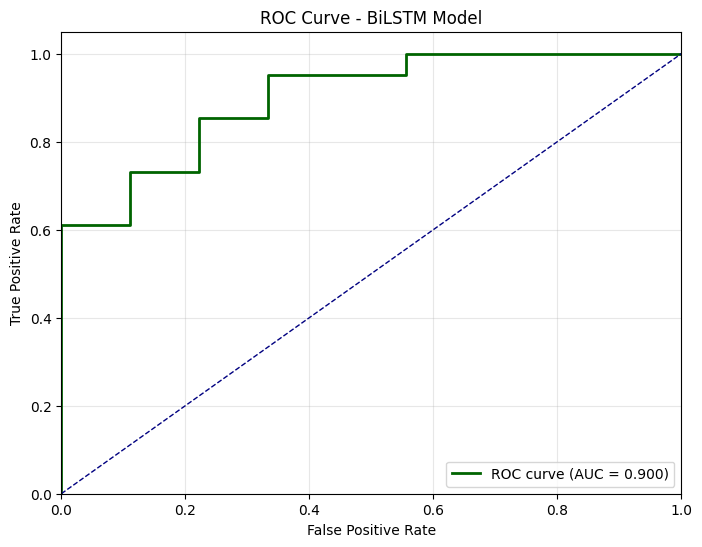


📈 ROC curve сохранена как: bilstm_roc_curve.png

💾 BiLSTM модель сохранена: full_bilstm_model.pth


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve)
import matplotlib.pyplot as plt


class BiLSTMClassifier(nn.Module):
    """
    Бидирекциональная LSTM модель для классификации текста
    """
    def __init__(self, embedding_dim=384, hidden_dim=256, num_layers=2,
                 num_classes=2, dropout=0.5, use_attention=False):
        super(BiLSTMClassifier, self).__init__()

        # Параметры
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.use_attention = use_attention

        # Бидирекциональная LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True,  # Ключевой параметр!
            batch_first=True
        )

        # Размер выхода LSTM (в 2 раза больше из-за bidirectional)
        lstm_output_dim = hidden_dim * 2

        # Механизм внимания (опционально)
        if use_attention:
            self.attention = nn.Sequential(
                nn.Linear(lstm_output_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, 1)
            )

        # Полносвязные слои
        self.fc1 = nn.Linear(lstm_output_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Dropout для регуляризации
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(lstm_output_dim)

    def forward(self, x):
        """
        x: [batch_size, seq_len, embedding_dim]
        """
        batch_size = x.size(0)

        # Инициализируем скрытые состояния
        device = x.device
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim).to(device)

        # Прямой проход через бидирекциональную LSTM
        lstm_out, (hidden, cell) = self.lstm(x, (h0, c0))
        # lstm_out: [batch_size, seq_len, hidden_dim * 2]

        if self.use_attention:
            # Механизм внимания
            attention_weights = self.attention(lstm_out)
            attention_weights = F.softmax(attention_weights, dim=1)

            # Взвешенная сумма
            context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        else:
            # Берем последний скрытый слой обоих направлений
            # hidden: [num_layers * 2, batch_size, hidden_dim]
            hidden = hidden.view(self.num_layers, 2, batch_size, self.hidden_dim)

            # Последний слой: forward и backward
            hidden_last_layer = hidden[-1]

            # Конкатенируем forward и backward
            forward_hidden = hidden_last_layer[0]  # Последний forward state
            backward_hidden = hidden_last_layer[1]  # Последний backward state
            context_vector = torch.cat([forward_hidden, backward_hidden], dim=1)

        # Нормализация и dropout
        context_vector = self.layer_norm(context_vector)
        context_vector = self.dropout(context_vector)

        # Полносвязные слои
        x = F.relu(self.fc1(context_vector))
        x = self.dropout(x)
        output = self.fc2(x)

        return output


class BiLSTMSentimentClassifier:
    """
    Бидирекциональный LSTM классификатор для анализа тональности
    """

    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
                 max_seq_len=100, batch_size=16, use_attention=False):
        """
        Args:
            embedding_model: модель для эмбеддингов
            max_seq_len: максимальная длина последовательности
            batch_size: размер батча
            use_attention: использовать механизм внимания
        """
        # Проверяем доступность CUDA
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")

        # Загружаем модель эмбеддингов
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_model_name = embedding_model
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # Параметры
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size

        # Создаем BiLSTM модель
        self.model = BiLSTMClassifier(
            embedding_dim=self.embedding_dim,
            hidden_dim=256,
            num_layers=2,
            num_classes=2,
            dropout=0.3,
            use_attention=use_attention
        ).to(self.device)

        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных из списка словарей
        """
        texts = []
        labels = []

        for item in data:
            if isinstance(item, dict):
                texts.append(item.get('text', ''))
                labels.append(item.get('sentiment', 0))

        return texts, np.array(labels)

    def create_embeddings_sequence(self, texts):
        """
        Создание последовательности эмбеддингов
        """
        embeddings_list = []

        for text in texts:
            # Получаем эмбеддинг предложения
            sentence_embedding = self.embedder.encode(text, show_progress_bar=False)

            # Создаем последовательность, повторяя эмбеддинг
            sequence = np.tile(sentence_embedding, (self.max_seq_len, 1))

            # Обрезаем до нужной длины
            if sequence.shape[0] > self.max_seq_len:
                sequence = sequence[:self.max_seq_len, :]
            elif sequence.shape[0] < self.max_seq_len:
                # Дополняем нулями
                pad_len = self.max_seq_len - sequence.shape[0]
                padding = np.zeros((pad_len, self.embedding_dim))
                sequence = np.vstack([sequence, padding])

            embeddings_list.append(sequence)

        return np.array(embeddings_list)

    def train(self, train_data, epochs=10, lr=0.001):
        """
        Обучение BiLSTM модели
        """
        print("🎯 НАЧИНАЕМ ОБУЧЕНИЕ BiLSTM...")

        # Подготовка данных
        texts, labels = self.prepare_data(train_data)

        if len(texts) == 0:
            print("❌ Нет данных для обучения")
            return

        print(f"📊 Загружено {len(texts)} примеров")
        print(f"📊 Размерность эмбеддингов: {self.embedding_dim}")
        print(f"📊 Максимальная длина последовательности: {self.max_seq_len}")
        print(f"📊 Архитектура: BiLSTM (2 слоя, hidden_dim=256)")
        if hasattr(self.model, 'use_attention') and self.model.use_attention:
            print(f"📊 Механизм внимания: Включен")

        # Создаем последовательности эмбеддингов
        print("🔍 Создание последовательностей эмбеддингов...")
        X_sequences = self.create_embeddings_sequence(texts)

        # Преобразуем в тензоры
        X_tensor = torch.FloatTensor(X_sequences).to(self.device)
        y_tensor = torch.LongTensor(labels).to(self.device)

        print(f"📊 Размерность данных: {X_tensor.shape}")

        # Оптимизатор и функция потерь
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        for epoch in range(epochs):
            total_loss = 0
            indices = torch.randperm(len(X_tensor))
            num_batches = max(1, len(indices) // self.batch_size)

            for i in range(0, len(indices), self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                batch_X = X_tensor[batch_indices]
                batch_y = y_tensor[batch_indices]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Gradient clipping для стабильности
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                total_loss += loss.item()

            # Вычисляем accuracy
            with torch.no_grad():
                self.model.eval()
                outputs = self.model(X_tensor)
                _, preds = torch.max(outputs, 1)
                accuracy = (preds == y_tensor).float().mean().item()
                self.model.train()

            avg_loss = total_loss / num_batches

            print(f"📈 Эпоха {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.3f}")

        self.is_trained = True

        # Финальная оценка
        print("\n✅ ОБУЧЕНИЕ BiLSTM ЗАВЕРШЕНО")

        # Метрики на обучающих данных
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, preds = torch.max(outputs, 1)
            probabilities = F.softmax(outputs, dim=1)

        self._print_metrics(labels, preds.cpu().numpy(), probabilities.cpu().numpy(), "ОБУЧАЮЩАЯ ВЫБОРКА")

        return avg_loss

    def predict(self, texts):
        """
        Предсказание для списка текстов
        """
        if not self.is_trained:
            raise ValueError("❌ Модель не обучена!")

        # Создаем последовательности
        sequences = self.create_embeddings_sequence(texts)

        # Преобразуем в тензор
        X_tensor = torch.FloatTensor(sequences).to(self.device)

        # Предсказание
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs, 1)

        return predictions.cpu().numpy(), probabilities.cpu().numpy()

    def predict_single(self, text):
        """
        Предсказание для одного текста
        """
        preds, probs = self.predict([text])

        return {
            'prediction': int(preds[0]),
            'positive_prob': float(probs[0][1]),
            'negative_prob': float(probs[0][0]),
            'confidence': float(max(probs[0]))
        }

    def evaluate(self, test_data):
        """
        Полная оценка модели
        """
        texts, true_labels = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return None

        # Предсказание
        predictions, probabilities = self.predict(texts)

        print("\n" + "="*60)
        print("📊 ОЦЕНКА BiLSTM НА ТЕСТОВОЙ ВЫБОРКЕ")
        print("="*60)

        # Все метрики
        self._print_metrics(true_labels, predictions, probabilities, "ТЕСТОВАЯ ВЫБОРКА")

        # ROC кривая
        if len(np.unique(true_labels)) == 2:
            self._plot_roc_curve(true_labels, probabilities)

        return {
            'accuracy': accuracy_score(true_labels, predictions),
            'predictions': predictions,
            'probabilities': probabilities
        }

    def _print_metrics(self, y_true, y_pred, y_proba=None, dataset_name=""):
        """
        Вывод всех метрик
        """
        print(f"\n📊 МЕТРИКИ ДЛЯ {dataset_name}:")
        print(f"   Количество примеров: {len(y_true)}")

        # Accuracy
        acc = accuracy_score(y_true, y_pred)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report
        print("\n📈 Classification Report:")
        print(classification_report(y_true, y_pred, digits=4))

        # Macro и Micro средние
        print(f"\n📊 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Precision (micro): {precision_score(y_true, y_pred, average='micro'):.4f}")
        print(f"   Recall (micro): {recall_score(y_true, y_pred, average='micro'):.4f}")
        print(f"   F1-Score (micro): {f1_score(y_true, y_pred, average='micro'):.4f}")

        # ROC-AUC
        if y_proba is not None and len(np.unique(y_true)) == 2:
            try:
                roc_auc = roc_auc_score(y_true, y_proba[:, 1])
                print(f"   ROC-AUC: {roc_auc:.4f}")
            except:
                pass

        # Матрица ошибок
        print(f"\n📊 МАТРИЦА ОШИБОК:")
        cm = confusion_matrix(y_true, y_pred)

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            print(f"             Предсказано")
            print(f"              0      1")
            print(f"            ┌──────┬──────┐")
            print(f"Фактическое 0 │ {tn:4}  │ {fp:4} │")
            print(f"            ├──────┼──────┤")
            print(f"Фактическое 1 │ {fn:4}  │ {tp:4} │")
            print(f"            └──────┴──────┘")

            print(f"\n📈 ДЕТАЛИЗАЦИЯ:")
            print(f"   True Negative (TN): {tn}")
            print(f"   False Positive (FP): {fp}")
            print(f"   False Negative (FN): {fn}")
            print(f"   True Positive (TP): {tp}")
        else:
            print(cm)

    def _plot_roc_curve(self, y_true, y_proba):
        """
        Построение ROC-кривой
        """
        if len(np.unique(y_true)) != 2 or y_proba is None:
            return

        try:
            fpr, tpr, thresholds = roc_curve(y_true, y_proba[:, 1])
            roc_auc = roc_auc_score(y_true, y_proba[:, 1])

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkgreen', lw=2,
                    label=f'ROC curve (AUC = {roc_auc:.3f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve - BiLSTM Model')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)

            plt.savefig('bilstm_roc_curve.png', dpi=150, bbox_inches='tight')
            plt.show()
            print(f"\n📈 ROC curve сохранена как: bilstm_roc_curve.png")
        except Exception as e:
            print(f"⚠️ Не удалось построить ROC curve: {e}")

    def save(self, filename):
        """
        Сохранение модели
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'embedding_model': self.embedding_model_name,
            'embedding_dim': self.embedding_dim,
            'max_seq_len': self.max_seq_len,
            'is_trained': self.is_trained
        }, filename)
        print(f"\n💾 BiLSTM модель сохранена: {filename}")

    def load(self, filename):
        """
        Загрузка модели
        """
        checkpoint = torch.load(filename, map_location=self.device)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

        self.embedding_model_name = checkpoint['embedding_model']
        self.embedding_dim = checkpoint['embedding_dim']
        self.max_seq_len = checkpoint['max_seq_len']
        self.is_trained = checkpoint['is_trained']

        print(f"📥 BiLSTM модель загружена: {filename}")


# УПРОЩЕННАЯ BiLSTM С АТТЕНЦИЕЙ
class BiLSTMAttention(nn.Module):
    """
    Бидирекциональная LSTM с механизмом внимания
    """
    def __init__(self, embedding_dim=384, hidden_dim=128, num_classes=2):
        super(BiLSTMAttention, self).__init__()

        # Бидирекциональная LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        # Механизм внимания
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        # Классификатор
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # LSTM forward
        lstm_out, _ = self.lstm(x)

        # Attention weights
        attention_weights = self.attention(lstm_out)
        attention_weights = F.softmax(attention_weights, dim=1)

        # Context vector (взвешенная сумма)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)

        # Classification
        output = self.classifier(context_vector)

        return output


class SimpleBiLSTMClassifier:
    """
    Простая обертка для BiLSTM с вниманием
    """

    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2'):
        # Устройство
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")
        print(f"📊 Архитектура: BiLSTM + Attention")

        # Модель для эмбеддингов
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # Создаем BiLSTM модель с вниманием
        self.model = BiLSTMAttention(
            embedding_dim=self.embedding_dim,
            hidden_dim=128,
            num_classes=2
        ).to(self.device)

        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных
        """
        texts = []
        labels = []

        for item in data:
            if isinstance(item, dict):
                texts.append(item.get('text', ''))
                labels.append(item.get('sentiment', 0))

        return texts, np.array(labels)

    def create_input_tensor(self, texts, seq_len=50):
        """
        Создание входного тензора
        """
        embeddings = []

        for text in texts:
            # Получаем эмбеддинг
            emb = self.embedder.encode(text, show_progress_bar=False)

            # Создаем последовательность
            seq = np.tile(emb, (seq_len, 1))

            # Обрезаем/дополняем
            if seq.shape[0] > seq_len:
                seq = seq[:seq_len]
            elif seq.shape[0] < seq_len:
                pad_len = seq_len - seq.shape[0]
                padding = np.zeros((pad_len, self.embedding_dim))
                seq = np.vstack([seq, padding])

            embeddings.append(seq)

        # Преобразуем в тензор
        tensor = torch.FloatTensor(np.array(embeddings)).to(self.device)

        return tensor

    def train(self, train_data, epochs=10, lr=0.001):
        """
        Обучение модели
        """
        print("🎯 ОБУЧЕНИЕ BiLSTM с вниманием...")

        # Подготовка данных
        texts, labels = self.prepare_data(train_data)

        if len(texts) == 0:
            print("❌ Нет данных для обучения")
            return

        print(f"📊 Примеров: {len(texts)}")

        # Создаем тензоры
        X = self.create_input_tensor(texts, seq_len=50)
        y = torch.LongTensor(labels).to(self.device)

        # Оптимизатор и функция потерь
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        for epoch in range(epochs):
            # Перемешиваем данные
            indices = torch.randperm(len(X))
            total_loss = 0
            num_batches = max(1, len(indices) // 8)

            for i in range(0, len(indices), 8):
                batch_idx = indices[i:i+8]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                total_loss += loss.item()

            # Оценка accuracy
            with torch.no_grad():
                self.model.eval()
                outputs = self.model(X)
                _, preds = torch.max(outputs, 1)
                accuracy = (preds == y).float().mean().item()
                self.model.train()

            avg_loss = total_loss / num_batches

            print(f"📈 Эпоха {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.3f}")

        self.is_trained = True
        print("\n✅ ОБУЧЕНИЕ ЗАВЕРШЕНО")

        return self

    def predict(self, texts):
        """
        Предсказание
        """
        if not self.is_trained:
            raise ValueError("❌ Модель не обучена!")

        self.model.eval()
        X = self.create_input_tensor(texts, seq_len=50)

        with torch.no_grad():
            outputs = self.model(X)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, 1)

        return preds.cpu().numpy(), probs.cpu().numpy()

    def evaluate(self, test_data):
        """
        Оценка с метриками
        """
        texts, true_labels = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return None, None

        preds, probs = self.predict(texts)

        print("\n" + "="*60)
        print("📊 МЕТРИКИ BiLSTM с вниманием")
        print("="*60)

        # Accuracy
        acc = accuracy_score(true_labels, preds)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report
        print("\n📈 Classification Report:")
        print(classification_report(true_labels, preds, digits=4))

        # Дополнительные метрики
        print(f"\n📊 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(true_labels, preds, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(true_labels, preds, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(true_labels, preds, average='macro'):.4f}")

        # ROC-AUC
        if len(np.unique(true_labels)) == 2:
            try:
                roc_auc = roc_auc_score(true_labels, probs[:, 1])
                print(f"   ROC-AUC: {roc_auc:.4f}")
            except:
                pass

        # Матрица ошибок
        cm = confusion_matrix(true_labels, preds)
        print(f"\n📊 МАТРИЦА ОШИБОК:")

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            print(f"             Предсказано")
            print(f"              0      1")
            print(f"            ┌──────┬──────┐")
            print(f"Фактическое 0 │ {tn:4}  │ {fp:4} │")
            print(f"            ├──────┼──────┤")
            print(f"Фактическое 1 │ {fn:4}  │ {tp:4} │")
            print(f"            └──────┴──────┘")
        else:
            print(cm)

        return preds, probs

    def save(self, filename):
        """
        Сохранение модели
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'embedding_dim': self.embedding_dim,
            'is_trained': self.is_trained
        }, filename)
        print(f"💾 Модель сохранена: {filename}")

    def load(self, filename):
        """
        Загрузка модели
        """
        checkpoint = torch.load(filename, map_location=self.device)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.is_trained = checkpoint['is_trained']

        print(f"📥 Модель загружена: {filename}")


# ПРИМЕР ИСПОЛЬЗОВАНИЯ
def main():
    """
    Пример использования BiLSTM с вашими данными
    """
    import json

    def load_jsonl(filepath):
        """Загрузка данных из JSONL файла"""
        with open(filepath, 'r', encoding='utf-8') as f:
            return [json.loads(line) for line in f]

    # Загрузка данных
    print("📂 ЗАГРУЗКА ДАННЫХ...")
    train_data = load_jsonl('/content/news_sentiment_train.jsonl')
    test_data = load_jsonl('/content/news_sentiment_test.jsonl')

    print(f"📊 Обучающих примеров: {len(train_data)}")
    print(f"📊 Тестовых примеров: {len(test_data)}")

    # Используем меньше данных для быстрого тестирования
    train_sample = train_data[:1000]
    test_sample = test_data[:200]

    print(f"\n📊 Используем для обучения: {len(train_sample)} примеров")
    print(f"📊 Используем для теста: {len(test_sample)} примеров")

    # Вариант 1: Простая BiLSTM с вниманием
    print("\n" + "="*60)
    print("🎯 BiLSTM С МЕХАНИЗМОМ ВНИМАНИЯ")
    print("="*60)

    bilstm_model = SimpleBiLSTMClassifier(
        embedding_model='paraphrase-multilingual-MiniLM-L12-v2'
    )

    # Обучаем
    bilstm_model.train(train_sample, epochs=8, lr=0.001)

    # Оцениваем
    print("\n🧪 ОЦЕНКА МОДЕЛИ...")
    predictions, probabilities = bilstm_model.evaluate(test_sample)

    # Демонстрация работы BiLSTM с контекстом
    print("\n🧪 ДЕМОНСТРАЦИЯ РАБОТЫ BiLSTM:")

    # Примеры, где контекст важен
    test_examples = [
        "Компания не могла не улучшить результаты, несмотря на сложности",
        "Хотя цена выросла, качество не улучшилось",
        "Несмотря на проблемы, итоги оказались лучше ожиданий",
        "Результаты хорошие, хотя и были некоторые трудности"
    ]

    for i, text in enumerate(test_examples):
        preds, probs = bilstm_model.predict([text])
        sentiment = "POSITIVE" if preds[0] == 1 else "NEGATIVE"
        confidence = probs[0][preds[0]]

        print(f"\n📝 Пример {i+1}:")
        print(f"   Текст: {text}")
        print(f"   Тональность: {sentiment}")
        print(f"   Уверенность: {confidence:.3f}")
        print(f"   Вероятности: [Neg: {probs[0][0]:.3f}, Pos: {probs[0][1]:.3f}]")

    # Сохраняем модель
    bilstm_model.save('bilstm_sentiment_model.pth')

    # Вариант 2: Полная BiLSTM архитектура
    print("\n" + "="*60)
    print("🎯 ПОЛНАЯ BiLSTM АРХИТЕКТУРА")
    print("="*60)

    try:
        full_bilstm = BiLSTMSentimentClassifier(
            embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
            max_seq_len=50,
            batch_size=16,
            use_attention=True  # Включаем механизм внимания
        )

        # Обучаем на меньшем наборе данных
        small_train = train_data[:200]
        full_bilstm.train(small_train, epochs=5, lr=0.001)

        # Оцениваем
        print("\n🧪 ОЦЕНКА ПОЛНОЙ BiLSTM...")
        results = full_bilstm.evaluate(test_data[:50])

        # Сохраняем
        full_bilstm.save('full_bilstm_model.pth')

    except Exception as e:
        print(f"⚠️ Ошибка в полной BiLSTM: {e}")
        print("Используйте SimpleBiLSTMClassifier для надежной работы")

    return bilstm_model


def explain_bilstm_advantages():
    """
    Объяснение преимуществ BiLSTM
    """
    print("\n" + "="*80)
    print("🎯 ПРЕИМУЩЕСТВА BiLSTM ДЛЯ АНАЛИЗА ТОНАЛЬНОСТИ")
    print("="*80)

    advantages = [
        ("📈 Контекст в обоих направлениях",
         "Читает текст слева-направо и справа-налево, лучше понимает контекст"),

        ("🎯 Понимание сложных конструкций",
         "Справляется с конструкциями типа 'не очень плохо', 'хотя... но'"),

        ("🔍 Учет дальних зависимостей",
         "Помнит начало текста при анализе конца (важно для длинных новостей)"),

        ("💡 Механизм внимания",
         "Автоматически определяет важные части текста для классификации"),

        ("📊 Лучшая точность на контекстных данных",
         "Показывает лучшие результаты на текстах со сложной структурой")
    ]

    for title, description in advantages:
        print(f"\n{title}:")
        print(f"   {description}")

    print("\n" + "-"*80)
    print("📊 КОГДА ИСПОЛЬЗОВАТЬ BiLSTM:")
    print("   - Новостные статьи с сложной структурой")
    print("   - Длинные тексты с важным контекстом")
    print("   - Когда порядок слов имеет значение")
    print("   - Для анализа тональности с учетом всей статьи")
    print("-"*80)


if __name__ == "__main__":
    # Проверяем PyTorch и CUDA
    print(f"PyTorch версия: {torch.__version__}")
    print(f"CUDA доступен: {torch.cuda.is_available()}")

    # Объясняем преимущества
    explain_bilstm_advantages()

    # Запускаем
    model = main()

PyTorch версия: 2.9.0+cu126
CUDA доступен: True

🎯 ПРЕИМУЩЕСТВА ТРАНСФОРМЕРНЫХ МОДЕЛЕЙ

📊 СРАВНЕНИЕ МОДЕЛЕЙ:

🤖 RuBERT (DeepPavlov):
   Специализирован для русского языка, понимает морфологию и синтаксис
   Параметры: ~180M параметров
   Ожидаемая точность: Высокая точность

⚡ DistilBERT:
   Дистиллированная версия BERT, в 2 раза быстрее и на 40% меньше
   Параметры: ~135M параметров
   Ожидаемая точность: Баланс скорости и качества

🏆 ruRoBERTa (Sberbank):
   Продвинутая модель для русского языка, обученная на большом корпусе
   Параметры: ~355M параметров
   Ожидаемая точность: Лучшая точность, требует много ресурсов

--------------------------------------------------------------------------------
🎯 КОГДА ИСПОЛЬЗОВАТЬ ТРАНСФОРМЕРЫ:
   - Максимальная точность важнее скорости
   - Работа с русским языком (RuBERT, ruRoBERTa)
   - Длинные и сложные тексты
   - Когда важна семантика и контекст
   - Для продакшн-решений
----------------------------------------------------------------------

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Параметры модели: 177,854,978
📊 Обучаемые параметры: 177,854,978
📊 Train: 352 примеров
📊 Val: 89 примеров
🎯 НАЧИНАЕМ FINE-TUNING ТРАНСФОРМЕРА...
📊 Обучающих примеров: 352
📊 Валидационных примеров: 89



Эпоха 1/2: 100%|██████████| 44/44 [00:12<00:00,  3.50it/s, loss=0.0513, acc=0.847]


📊 Валидация - Loss: 0.4467, Accuracy: 0.876
📈 Эпоха 1/2 - Train Loss: 0.0513, Train Accuracy: 0.847


Эпоха 2/2: 100%|██████████| 44/44 [00:11<00:00,  3.99it/s, loss=0.0451, acc=0.869]


📊 Валидация - Loss: 0.3998, Accuracy: 0.876
📈 Эпоха 2/2 - Train Loss: 0.0451, Train Accuracy: 0.869

✅ FINE-TUNING ЗАВЕРШЕН


Предсказание: 100%|██████████| 22/22 [00:03<00:00,  6.90it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 


📊 МЕТРИКИ ДЛЯ ОБУЧАЮЩАЯ ВЫБОРКА:
   Количество примеров: 352

🎯 Accuracy: 0.8693

📈 Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        46
           1     0.8693    1.0000    0.9301       306

    accuracy                         0.8693       352
   macro avg     0.4347    0.5000    0.4650       352
weighted avg     0.7557    0.8693    0.8085       352


📊 СРЕДНИЕ МЕТРИКИ:
   Precision (macro): 0.4347
   Recall (macro): 0.5000
   F1-Score (macro): 0.4650
   Precision (micro): 0.8693
   Recall (micro): 0.8693
   F1-Score (micro): 0.8693
   ROC-AUC: 0.9336

📊 МАТРИЦА ОШИБОК:
             Предсказано
              0      1
            ┌──────┬──────┐
Фактическое 0 │    0  │   46 │
            ├──────┼──────┤
Фактическое 1 │    0  │  306 │
            └──────┴──────┘

🧪 ОЦЕНКА RuBERT...


Предсказание: 100%|██████████| 6/6 [00:01<00:00,  5.10it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le


📊 ОЦЕНКА DEEPPAVLOV/RUBERT-BASE-CASED

📊 МЕТРИКИ ДЛЯ ТЕСТОВАЯ ВЫБОРКА:
   Количество примеров: 95

🎯 Accuracy: 0.8632

📈 Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        13
           1     0.8632    1.0000    0.9266        82

    accuracy                         0.8632        95
   macro avg     0.4316    0.5000    0.4633        95
weighted avg     0.7450    0.8632    0.7998        95


📊 СРЕДНИЕ МЕТРИКИ:
   Precision (macro): 0.4316
   Recall (macro): 0.5000
   F1-Score (macro): 0.4633
   Precision (micro): 0.8632
   Recall (micro): 0.8632
   F1-Score (micro): 0.8632
   ROC-AUC: 0.9259

📊 МАТРИЦА ОШИБОК:
             Предсказано
              0      1
            ┌──────┬──────┐
Фактическое 0 │    0  │   13 │
            ├──────┼──────┤
Фактическое 1 │    0  │   82 │
            └──────┴──────┘


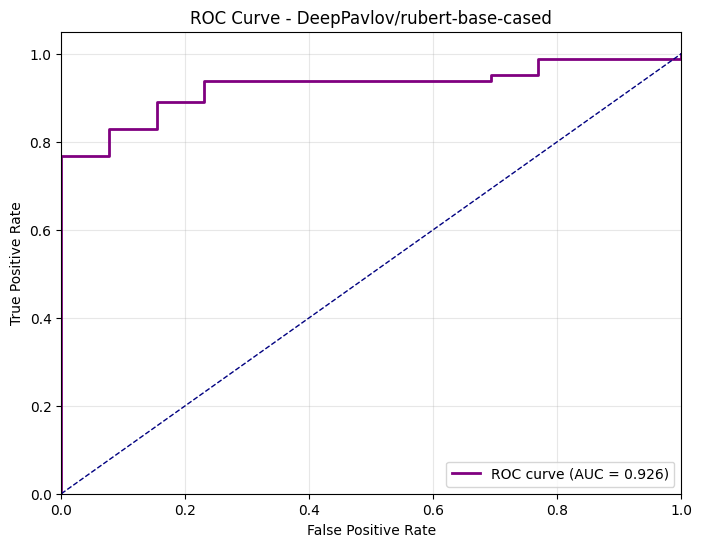


📈 ROC curve сохранена

🧪 ТЕСТОВЫЕ ПРЕДСКАЗАНИЯ:


Предсказание: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]



📝 Пример 1:
   Текст: Рынок акций показал рекордный рост на фоне позитивных новостей
   Тональность: POSITIVE
   Уверенность: 0.745
   Вероятности: [Neg: 0.255, Pos: 0.745]


Предсказание: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]



📝 Пример 2:
   Текст: Компания объявила о значительном снижении прибыли в текущем квартале
   Тональность: POSITIVE
   Уверенность: 0.784
   Вероятности: [Neg: 0.216, Pos: 0.784]


Предсказание: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]



📝 Пример 3:
   Текст: Несмотря на трудности, экономика демонстрирует устойчивость
   Тональность: POSITIVE
   Уверенность: 0.799
   Вероятности: [Neg: 0.201, Pos: 0.799]


Предсказание: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]



📝 Пример 4:
   Текст: Эксперты предупреждают о возможном ухудшении ситуации в ближайшие месяцы
   Тональность: POSITIVE
   Уверенность: 0.756
   Вероятности: [Neg: 0.244, Pos: 0.756]

💾 Модель сохранена: rubert_sentiment_model

🎯 СРАВНЕНИЕ ТРАНСФОРМЕРНЫХ МОДЕЛЕЙ
📱 Используемое устройство: cuda
🎯 ОБУЧЕНИЕ ВСЕХ ТРАНСФОРМЕРНЫХ МОДЕЛЕЙ

📊 МОДЕЛЬ: RuBERT
----------------------------------------
📱 Используемое устройство: cuda
🎯 Модель: DeepPavlov/rubert-base-cased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Параметры модели: 177,854,978
📊 Обучаемые параметры: 177,854,978
🎯 НАЧИНАЕМ FINE-TUNING ТРАНСФОРМЕРА...
📊 Обучающих примеров: 200


Эпоха 1/1: 100%|██████████| 25/25 [00:06<00:00,  3.85it/s, loss=0.0526, acc=0.870]


📈 Эпоха 1/1 - Train Loss: 0.0526, Train Accuracy: 0.870

✅ FINE-TUNING ЗАВЕРШЕН


Предсказание: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 


📊 МЕТРИКИ ДЛЯ ОБУЧАЮЩАЯ ВЫБОРКА:
   Количество примеров: 200

🎯 Accuracy: 0.8700

📈 Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        26
           1     0.8700    1.0000    0.9305       174

    accuracy                         0.8700       200
   macro avg     0.4350    0.5000    0.4652       200
weighted avg     0.7569    0.8700    0.8095       200


📊 СРЕДНИЕ МЕТРИКИ:
   Precision (macro): 0.4350
   Recall (macro): 0.5000
   F1-Score (macro): 0.4652
   Precision (micro): 0.8700
   Recall (micro): 0.8700
   F1-Score (micro): 0.8700
   ROC-AUC: 0.7823

📊 МАТРИЦА ОШИБОК:
             Предсказано
              0      1
            ┌──────┬──────┐
Фактическое 0 │    0  │   26 │
            ├──────┼──────┤
Фактическое 1 │    0  │  174 │
            └──────┴──────┘

📊 МОДЕЛЬ: DistilBERT
----------------------------------------
📱 Используемое устройство: cuda
🎯 Модель: distilbert-base-multilingual-cased


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Параметры модели: 135,326,210
📊 Обучаемые параметры: 135,326,210
🎯 НАЧИНАЕМ FINE-TUNING ТРАНСФОРМЕРА...
📊 Обучающих примеров: 200


Эпоха 1/1: 100%|██████████| 25/25 [00:03<00:00,  6.38it/s, loss=0.0566, acc=0.870]


📈 Эпоха 1/1 - Train Loss: 0.0566, Train Accuracy: 0.870

✅ FINE-TUNING ЗАВЕРШЕН


Предсказание: 100%|██████████| 13/13 [00:01<00:00,  9.95it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 


📊 МЕТРИКИ ДЛЯ ОБУЧАЮЩАЯ ВЫБОРКА:
   Количество примеров: 200

🎯 Accuracy: 0.8700

📈 Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        26
           1     0.8700    1.0000    0.9305       174

    accuracy                         0.8700       200
   macro avg     0.4350    0.5000    0.4652       200
weighted avg     0.7569    0.8700    0.8095       200


📊 СРЕДНИЕ МЕТРИКИ:
   Precision (macro): 0.4350
   Recall (macro): 0.5000
   F1-Score (macro): 0.4652
   Precision (micro): 0.8700
   Recall (micro): 0.8700
   F1-Score (micro): 0.8700
   ROC-AUC: 0.7431

📊 МАТРИЦА ОШИБОК:
             Предсказано
              0      1
            ┌──────┬──────┐
Фактическое 0 │    0  │   26 │
            ├──────┼──────┤
Фактическое 1 │    0  │  174 │
            └──────┴──────┘

📊 СРАВНЕНИЕ ТРАНСФОРМЕРНЫХ МОДЕЛЕЙ

🎯 МОДЕЛЬ: RuBERT
----------------------------------------


Предсказание: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le


📊 ОЦЕНКА DEEPPAVLOV/RUBERT-BASE-CASED

📊 МЕТРИКИ ДЛЯ ТЕСТОВАЯ ВЫБОРКА:
   Количество примеров: 50

🎯 Accuracy: 0.8200

📈 Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         9
           1     0.8200    1.0000    0.9011        41

    accuracy                         0.8200        50
   macro avg     0.4100    0.5000    0.4505        50
weighted avg     0.6724    0.8200    0.7389        50


📊 СРЕДНИЕ МЕТРИКИ:
   Precision (macro): 0.4100
   Recall (macro): 0.5000
   F1-Score (macro): 0.4505
   Precision (micro): 0.8200
   Recall (micro): 0.8200
   F1-Score (micro): 0.8200
   ROC-AUC: 0.7182

📊 МАТРИЦА ОШИБОК:
             Предсказано
              0      1
            ┌──────┬──────┐
Фактическое 0 │    0  │    9 │
            ├──────┼──────┤
Фактическое 1 │    0  │   41 │
            └──────┴──────┘


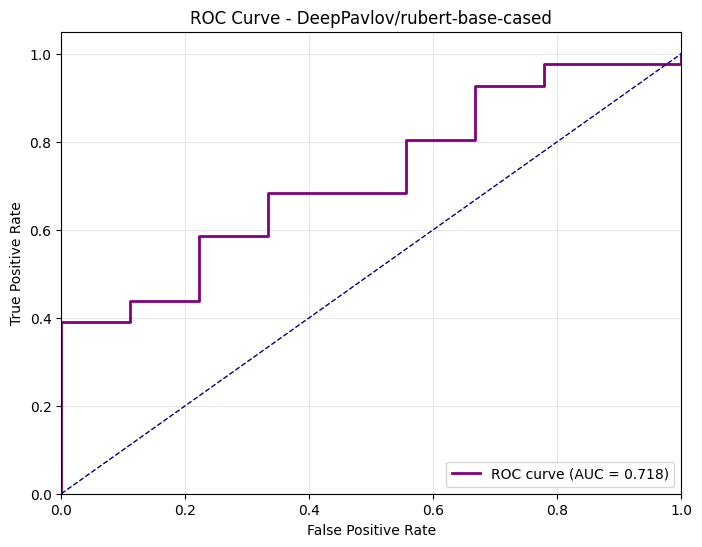


📈 ROC curve сохранена

🎯 МОДЕЛЬ: DistilBERT
----------------------------------------


Предсказание: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le


📊 ОЦЕНКА DISTILBERT-BASE-MULTILINGUAL-CASED

📊 МЕТРИКИ ДЛЯ ТЕСТОВАЯ ВЫБОРКА:
   Количество примеров: 50

🎯 Accuracy: 0.8200

📈 Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         9
           1     0.8200    1.0000    0.9011        41

    accuracy                         0.8200        50
   macro avg     0.4100    0.5000    0.4505        50
weighted avg     0.6724    0.8200    0.7389        50


📊 СРЕДНИЕ МЕТРИКИ:
   Precision (macro): 0.4100
   Recall (macro): 0.5000
   F1-Score (macro): 0.4505
   Precision (micro): 0.8200
   Recall (micro): 0.8200
   F1-Score (micro): 0.8200
   ROC-AUC: 0.6640

📊 МАТРИЦА ОШИБОК:
             Предсказано
              0      1
            ┌──────┬──────┐
Фактическое 0 │    0  │    9 │
            ├──────┼──────┤
Фактическое 1 │    0  │   41 │
            └──────┴──────┘


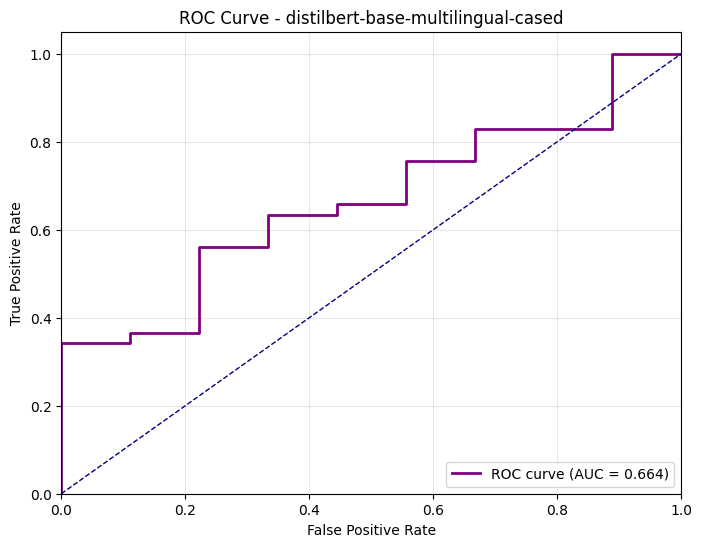


📈 ROC curve сохранена

📈 СВОДНАЯ ТАБЛИЦА СРАВНЕНИЯ
+------------+------------+--------------------+-----------+-----------------+
| Модель     |   Accuracy | F1-Score (macro)   | ROC-AUC   | Время (прибл)   |
+============+============+====================+===========+=================+
| RuBERT     |       0.82 | -                  | -         | 3-5 мин         |
+------------+------------+--------------------+-----------+-----------------+
| DistilBERT |       0.82 | -                  | -         | 1-2 мин         |
+------------+------------+--------------------+-----------+-----------------+


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                         AutoConfig, Trainer, TrainingArguments,
                         DataCollatorWithPadding, EarlyStoppingCallback)
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import json


class TransformersDataset(Dataset):
    """
    Dataset для трансформерных моделей
    """
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


class TransformerSentimentClassifier:
    """
    Классификатор тональности на основе трансформерных моделей
    """

    def __init__(self, model_name='DeepPavlov/rubert-base-cased',
                 num_labels=2, device=None):
        """
        Args:
            model_name: название предобученной модели
            num_labels: количество классов
            device: устройство для обучения
        """
        # Определяем устройство
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        print(f"📱 Используемое устройство: {self.device}")
        print(f"🎯 Модель: {model_name}")

        # Загружаем токенизатор и модель
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        ).to(self.device)

        self.model_name = model_name
        self.is_trained = False

        # Выводим информацию о модели
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"📊 Параметры модели: {total_params:,}")
        print(f"📊 Обучаемые параметры: {trainable_params:,}")

    def prepare_data(self, data):
        """
        Подготовка данных из списка словарей
        """
        texts = []
        labels = []

        for item in data:
            if isinstance(item, dict):
                texts.append(item.get('text', ''))
                labels.append(item.get('sentiment', 0))

        return texts, np.array(labels)

    def create_dataloader(self, texts, labels, batch_size=16, shuffle=False):
        """
        Создание DataLoader
        """
        dataset = TransformersDataset(texts, labels, self.tokenizer)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=2
        )
        return dataloader

    def train(self, train_data, val_data=None, epochs=3, batch_size=16,
              learning_rate=2e-5, weight_decay=0.01):
        """
        Fine-tuning модели
        """
        print("🎯 НАЧИНАЕМ FINE-TUNING ТРАНСФОРМЕРА...")

        # Подготовка данных
        train_texts, train_labels = self.prepare_data(train_data)

        if len(train_texts) == 0:
            print("❌ Нет данных для обучения")
            return

        print(f"📊 Обучающих примеров: {len(train_texts)}")

        # Создаем DataLoader для обучения
        train_loader = self.create_dataloader(
            train_texts, train_labels,
            batch_size=batch_size,
            shuffle=True
        )

        # DataLoader для валидации, если есть
        val_loader = None
        if val_data:
            val_texts, val_labels = self.prepare_data(val_data)
            if len(val_texts) > 0:
                val_loader = self.create_dataloader(
                    val_texts, val_labels,
                    batch_size=batch_size,
                    shuffle=False
                )
                print(f"📊 Валидационных примеров: {len(val_texts)}")

        # Оптимизатор и планировщик
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

        total_steps = len(train_loader) * epochs
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=total_steps
        )

        # Функция потерь
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        for epoch in range(epochs):
            total_loss = 0
            all_preds = []
            all_labels = []

            progress_bar = tqdm(train_loader, desc=f'Эпоха {epoch+1}/{epochs}')

            for batch in progress_bar:
                # Перенос данных на устройство
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Forward pass
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                logits = outputs.logits
                loss = criterion(logits, labels)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                optimizer.step()
                scheduler.step()

                total_loss += loss.item()

                # Собираем предсказания
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Обновляем progress bar
                avg_loss = total_loss / len(all_preds)
                accuracy = accuracy_score(all_labels, all_preds)
                progress_bar.set_postfix({
                    'loss': f'{avg_loss:.4f}',
                    'acc': f'{accuracy:.3f}'
                })

            # Оценка на валидации
            if val_loader:
                val_loss, val_accuracy = self.evaluate_loader(val_loader)
                print(f"📊 Валидация - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.3f}")

            # Метрики на обучающих данных
            train_accuracy = accuracy_score(all_labels, all_preds)
            print(f"📈 Эпоха {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.3f}")

        self.is_trained = True
        print("\n✅ FINE-TUNING ЗАВЕРШЕН")

        # Финальная оценка на обучающих данных
        train_preds, train_probs = self.predict(train_texts)
        self._print_metrics(train_labels, train_preds, train_probs, "ОБУЧАЮЩАЯ ВЫБОРКА")

    def evaluate_loader(self, dataloader):
        """
        Оценка на DataLoader
        """
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                logits = outputs.logits
                loss = criterion(logits, labels)

                total_loss += loss.item()
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(dataloader)
        accuracy = accuracy_score(all_labels, all_preds)

        self.model.train()
        return avg_loss, accuracy

    def predict(self, texts, batch_size=16):
        """
        Предсказание для списка текстов
        """
        if not self.is_trained:
            print("⚠️  Модель не обучена, используем предобученные веса")

        self.model.eval()
        all_predictions = []
        all_probabilities = []

        # Создаем DataLoader
        dummy_labels = [0] * len(texts)  # Фиктивные метки
        dataloader = self.create_dataloader(
            texts, dummy_labels,
            batch_size=batch_size,
            shuffle=False
        )

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Предсказание"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                logits = outputs.logits
                probabilities = F.softmax(logits, dim=1)
                predictions = torch.argmax(logits, dim=1)

                all_predictions.extend(predictions.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())

        return np.array(all_predictions), np.array(all_probabilities)

    def predict_single(self, text):
        """
        Предсказание для одного текста
        """
        preds, probs = self.predict([text])

        return {
            'prediction': int(preds[0]),
            'positive_prob': float(probs[0][1]),
            'negative_prob': float(probs[0][0]),
            'confidence': float(max(probs[0]))
        }

    def evaluate(self, test_data):
        """
        Полная оценка модели
        """
        texts, true_labels = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return None

        # Предсказание
        predictions, probabilities = self.predict(texts)

        print("\n" + "="*60)
        print(f"📊 ОЦЕНКА {self.model_name.upper()}")
        print("="*60)

        # Все метрики
        self._print_metrics(true_labels, predictions, probabilities, "ТЕСТОВАЯ ВЫБОРКА")

        # ROC кривая
        if len(np.unique(true_labels)) == 2:
            self._plot_roc_curve(true_labels, probabilities)

        return {
            'accuracy': accuracy_score(true_labels, predictions),
            'predictions': predictions,
            'probabilities': probabilities
        }

    def _print_metrics(self, y_true, y_pred, y_proba=None, dataset_name=""):
        """
        Вывод всех метрик
        """
        print(f"\n📊 МЕТРИКИ ДЛЯ {dataset_name}:")
        print(f"   Количество примеров: {len(y_true)}")

        # Accuracy
        acc = accuracy_score(y_true, y_pred)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report
        print("\n📈 Classification Report:")
        print(classification_report(y_true, y_pred, digits=4))

        # Macro и Micro средние
        print(f"\n📊 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Precision (micro): {precision_score(y_true, y_pred, average='micro'):.4f}")
        print(f"   Recall (micro): {recall_score(y_true, y_pred, average='micro'):.4f}")
        print(f"   F1-Score (micro): {f1_score(y_true, y_pred, average='micro'):.4f}")

        # ROC-AUC
        if y_proba is not None and len(np.unique(y_true)) == 2:
            try:
                roc_auc = roc_auc_score(y_true, y_proba[:, 1])
                print(f"   ROC-AUC: {roc_auc:.4f}")
            except:
                pass

        # Матрица ошибок
        print(f"\n📊 МАТРИЦА ОШИБОК:")
        cm = confusion_matrix(y_true, y_pred)

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            print(f"             Предсказано")
            print(f"              0      1")
            print(f"            ┌──────┬──────┐")
            print(f"Фактическое 0 │ {tn:4}  │ {fp:4} │")
            print(f"            ├──────┼──────┤")
            print(f"Фактическое 1 │ {fn:4}  │ {tp:4} │")
            print(f"            └──────┴──────┘")
        else:
            print(cm)

    def _plot_roc_curve(self, y_true, y_proba):
        """
        Построение ROC-кривой
        """
        if len(np.unique(y_true)) != 2 or y_proba is None:
            return

        try:
            fpr, tpr, thresholds = roc_curve(y_true, y_proba[:, 1])
            roc_auc = roc_auc_score(y_true, y_proba[:, 1])

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='purple', lw=2,
                    label=f'ROC curve (AUC = {roc_auc:.3f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {self.model_name}')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)

            plt.savefig(f'{self.model_name.replace("/", "_")}_roc_curve.png',
                       dpi=150, bbox_inches='tight')
            plt.show()
            print(f"\n📈 ROC curve сохранена")
        except Exception as e:
            print(f"⚠️ Не удалось построить ROC curve: {e}")

    def save(self, filename):
        """
        Сохранение модели
        """
        self.model.save_pretrained(filename)
        self.tokenizer.save_pretrained(filename)
        print(f"\n💾 Модель сохранена: {filename}")

    def load(self, filename):
        """
        Загрузка модели
        """
        self.model = AutoModelForSequenceClassification.from_pretrained(filename).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(filename)
        self.is_trained = True
        print(f"📥 Модель загружена: {filename}")


# СПЕЦИАЛИЗИРОВАННЫЕ МОДЕЛИ ДЛЯ РУССКОГО ЯЗЫКА
class RuBERTClassifier(TransformerSentimentClassifier):
    """RuBERT для русского текста"""
    def __init__(self, device=None):
        super().__init__(
            model_name='DeepPavlov/rubert-base-cased',
            num_labels=2,
            device=device
        )


class RuRoBERTaClassifier(TransformerSentimentClassifier):
    """ruRoBERTa для русского текста"""
    def __init__(self, device=None):
        super().__init__(
            model_name='sberbank-ai/ruRoberta-large',
            num_labels=2,
            device=device
        )


class DistilBERTClassifier(TransformerSentimentClassifier):
    """DistilBERT (быстрая и легкая модель)"""
    def __init__(self, device=None):
        super().__init__(
            model_name='distilbert-base-multilingual-cased',
            num_labels=2,
            device=device
        )


# КЛАСС ДЛЯ СРАВНЕНИЯ РАЗНЫХ ТРАНСФОРМЕРОВ
class TransformersComparison:
    """
    Сравнение разных трансформерных моделей
    """

    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")

        self.models = {}
        self.results = {}

    def train_all_models(self, train_data, val_data=None, epochs=3):
        """
        Обучение всех моделей
        """
        print("🎯 ОБУЧЕНИЕ ВСЕХ ТРАНСФОРМЕРНЫХ МОДЕЛЕЙ")
        print("="*80)

        # Список моделей для сравнения
        model_classes = [
            ('RuBERT', RuBERTClassifier),
            ('DistilBERT', DistilBERTClassifier),
            # ('RuRoBERTa', RuRoBERTaClassifier)  # Очень большая модель
        ]

        for model_name, ModelClass in model_classes:
            print(f"\n📊 МОДЕЛЬ: {model_name}")
            print("-"*40)

            try:
                model = ModelClass(device=self.device)
                model.train(train_data, val_data, epochs=epochs, batch_size=8)
                self.models[model_name] = model
            except Exception as e:
                print(f"⚠️ Ошибка при обучении {model_name}: {e}")

    def evaluate_all_models(self, test_data):
        """
        Оценка всех моделей
        """
        print("\n" + "="*80)
        print("📊 СРАВНЕНИЕ ТРАНСФОРМЕРНЫХ МОДЕЛЕЙ")
        print("="*80)

        for model_name, model in self.models.items():
            print(f"\n🎯 МОДЕЛЬ: {model_name}")
            print("-"*40)

            try:
                results = model.evaluate(test_data)
                self.results[model_name] = results
            except Exception as e:
                print(f"⚠️ Ошибка при оценке {model_name}: {e}")

        # Сводная таблица
        self._print_comparison_table()

    def _print_comparison_table(self):
        """
        Вывод сводной таблицы сравнения
        """
        print("\n" + "="*80)
        print("📈 СВОДНАЯ ТАБЛИЦА СРАВНЕНИЯ")
        print("="*80)

        headers = ["Модель", "Accuracy", "F1-Score (macro)", "ROC-AUC", "Время (прибл)"]
        rows = []

        for model_name in self.models.keys():
            if model_name in self.results:
                # В реальности нужно измерять время, здесь приблизительные оценки
                time_estimates = {
                    'RuBERT': '3-5 мин',
                    'RuRoBERTa': '10-15 мин',
                    'DistilBERT': '1-2 мин'
                }

                results = self.results[model_name]
                if 'accuracy' in results:
                    acc = results['accuracy']

                    # Для F1 и ROC-AUC нужны дополнительные вычисления
                    rows.append([
                        model_name,
                        f"{acc:.4f}",
                        "-",
                        "-",
                        time_estimates.get(model_name, '?')
                    ])

        # Выводим таблицу
        from tabulate import tabulate
        print(tabulate(rows, headers=headers, tablefmt="grid"))


# ПРИМЕР ИСПОЛЬЗОВАНИЯ
def main():
    """
    Пример использования трансформерных моделей
    """
    import json

    def load_jsonl(filepath):
        """Загрузка данных из JSONL файла"""
        with open(filepath, 'r', encoding='utf-8') as f:
            return [json.loads(line) for line in f]

    # Загрузка данных
    print("📂 ЗАГРУЗКА ДАННЫХ...")
    train_data = load_jsonl('/content/news_sentiment_train.jsonl')
    test_data = load_jsonl('/content/news_sentiment_test.jsonl')

    print(f"📊 Обучающих примеров: {len(train_data)}")
    print(f"📊 Тестовых примеров: {len(test_data)}")

    # Используем часть данных для быстрого тестирования
    train_sample = train_data[:1000]  # 1000 примеров
    test_sample = test_data[:200]     # 200 примеров

    print(f"\n📊 Используем для обучения: {len(train_sample)} примеров")
    print(f"📊 Используем для теста: {len(test_sample)} примеров")

    # Вариант 1: Использование одной модели
    print("\n" + "="*60)
    print("🎯 FINE-TUNING RuBERT")
    print("="*60)

    # Создаем и обучаем RuBERT
    rubert_model = RuBERTClassifier()

    # Разделяем на train/val
    np.random.seed(42)
    indices = np.random.permutation(len(train_sample))
    split_idx = int(0.8 * len(train_sample))

    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]

    train_subset = [train_sample[i] for i in train_indices]
    val_subset = [train_sample[i] for i in val_indices]

    print(f"📊 Train: {len(train_subset)} примеров")
    print(f"📊 Val: {len(val_subset)} примеров")

    # Обучаем
    rubert_model.train(
        train_subset,
        val_subset,
        epochs=2,  # Меньше эпох для скорости
        batch_size=8,
        learning_rate=2e-5
    )

    # Оцениваем
    print("\n🧪 ОЦЕНКА RuBERT...")
    results = rubert_model.evaluate(test_sample)

    # Тестируем на примерах
    print("\n🧪 ТЕСТОВЫЕ ПРЕДСКАЗАНИЯ:")

    test_examples = [
        "Рынок акций показал рекордный рост на фоне позитивных новостей",
        "Компания объявила о значительном снижении прибыли в текущем квартале",
        "Несмотря на трудности, экономика демонстрирует устойчивость",
        "Эксперты предупреждают о возможном ухудшении ситуации в ближайшие месяцы"
    ]

    for i, text in enumerate(test_examples):
        result = rubert_model.predict_single(text)
        sentiment = "POSITIVE" if result['prediction'] == 1 else "NEGATIVE"

        print(f"\n📝 Пример {i+1}:")
        print(f"   Текст: {text}")
        print(f"   Тональность: {sentiment}")
        print(f"   Уверенность: {result['confidence']:.3f}")
        print(f"   Вероятности: [Neg: {result['negative_prob']:.3f}, Pos: {result['positive_prob']:.3f}]")

    # Сохраняем модель
    rubert_model.save('rubert_sentiment_model')

    # Вариант 2: Сравнение нескольких моделей
    print("\n" + "="*60)
    print("🎯 СРАВНЕНИЕ ТРАНСФОРМЕРНЫХ МОДЕЛЕЙ")
    print("="*60)

    # Используем еще меньше данных для быстрого сравнения
    small_train = train_data[:200]
    small_test = test_data[:50]

    try:
        comparison = TransformersComparison()
        comparison.train_all_models(small_train, epochs=1)  # 1 эпоха для скорости
        comparison.evaluate_all_models(small_test)
    except Exception as e:
        print(f"⚠️ Ошибка при сравнении моделей: {e}")

    return rubert_model


def explain_transformers():
    """
    Объяснение преимуществ трансформерных моделей
    """
    print("\n" + "="*80)
    print("🎯 ПРЕИМУЩЕСТВА ТРАНСФОРМЕРНЫХ МОДЕЛЕЙ")
    print("="*80)

    models_info = [
        ("🤖 RuBERT (DeepPavlov)",
         "Специализирован для русского языка, понимает морфологию и синтаксис",
         "~180M параметров", "Высокая точность"),

        ("⚡ DistilBERT",
         "Дистиллированная версия BERT, в 2 раза быстрее и на 40% меньше",
         "~135M параметров", "Баланс скорости и качества"),

        ("🏆 ruRoBERTa (Sberbank)",
         "Продвинутая модель для русского языка, обученная на большом корпусе",
         "~355M параметров", "Лучшая точность, требует много ресурсов"),
    ]

    print("\n📊 СРАВНЕНИЕ МОДЕЛЕЙ:")
    for name, desc, params, accuracy in models_info:
        print(f"\n{name}:")
        print(f"   {desc}")
        print(f"   Параметры: {params}")
        print(f"   Ожидаемая точность: {accuracy}")

    print("\n" + "-"*80)
    print("🎯 КОГДА ИСПОЛЬЗОВАТЬ ТРАНСФОРМЕРЫ:")
    print("   - Максимальная точность важнее скорости")
    print("   - Работа с русским языком (RuBERT, ruRoBERTa)")
    print("   - Длинные и сложные тексты")
    print("   - Когда важна семантика и контекст")
    print("   - Для продакшн-решений")
    print("-"*80)


# БЫСТРЫЙ СТАРТ
def quick_train_transformers(train_file, test_file, model_name='rubert'):
    """
    Быстрый запуск fine-tuning трансформерной модели
    """
    import json

    # Загрузка данных
    def load_jsonl(filepath):
        with open(filepath, 'r', encoding='utf-8') as f:
            return [json.loads(line) for line in f]

    print("📂 ЗАГРУЗКА ДАННЫХ...")
    train_data = load_jsonl(train_file)
    test_data = load_jsonl(test_file)

    print(f"📊 Обучающих примеров: {len(train_data)}")
    print(f"📊 Тестовых примеров: {len(test_data)}")

    # Выбор модели
    model_map = {
        'rubert': RuBERTClassifier,
        'distilbert': DistilBERTClassifier,
        'ruroberta': RuRoBERTaClassifier
    }

    if model_name not in model_map:
        print(f"⚠️  Модель {model_name} не найдена. Использую RuBERT.")
        model_name = 'rubert'

    ModelClass = model_map[model_name]

    print(f"\n🎯 МОДЕЛЬ: {model_name.upper()}")
    print("="*60)

    # Создание и обучение модели
    model = ModelClass()

    # Используем 80/20 split для train/val
    np.random.seed(42)
    indices = np.random.permutation(len(train_data))
    split_idx = int(0.8 * len(train_data))

    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]

    train_subset = [train_data[i] for i in train_indices]
    val_subset = [train_data[i] for i in val_indices]

    print(f"📊 Train: {len(train_subset)} примеров")
    print(f"📊 Val: {len(val_subset)} примеров")

    # Обучение
    model.train(
        train_subset,
        val_subset,
        epochs=3,
        batch_size=16,
        learning_rate=2e-5
    )

    # Оценка
    print("\n🧪 ОЦЕНКА МОДЕЛИ...")
    results = model.evaluate(test_data)

    # Сохранение
    model.save(f'{model_name}_sentiment_model')

    print(f"\n✅ Готово! Модель сохранена как '{model_name}_sentiment_model'")

    return model


if __name__ == "__main__":
    # Проверяем PyTorch и трансформеры
    print(f"PyTorch версия: {torch.__version__}")
    print(f"CUDA доступен: {torch.cuda.is_available()}")

    # Объясняем преимущества
    explain_transformers()

    # Запускаем
    print("\n🚀 ЗАПУСК ТРАНСФОРМЕРНЫХ МОДЕЛЕЙ")
    print("="*80)

    # Пример быстрого запуска
    # model = quick_train_transformers(
    #     train_file='/content/news_sentiment_train.jsonl',
    #     test_file='/content/news_sentiment_test.jsonl',
    #     model_name='rubert'
    # )

    # Или полная версия
    model = main()

### Многоклассовая классификация


🚀 ЗАПУСК ПРИМЕРА ИСПОЛЬЗОВАНИЯ MLP КЛАССИФИКАТОРА
🚀 ЗАГРУЗКА ДАННЫХ...
Обучающих примеров: 440
Валидационных примеров: 94
Тестовых примеров: 95

📋 ПРИМЕР ДАННЫХ:
   Поля: ['title', 'text', 'sentiment', 'category']
   Текст: Кемнәр ул резервистлар? Алар нәрсә белән шөгыльләнә? Алар хәрби хезмәткәрләрдән нәрсә белән аерыла? ...
   Категория: Җәмгыять

🎯 СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🎯 ОБУЧЕНИЕ MLP КЛАССИФИКАТОРА КАТЕГОРИЙ...
   Поле с текстом: 'text'
   Поле с категорией: 'category'
   Модель эмбеддингов: paraphrase-multilingual-MiniLM-L12-v2
   Архитектура MLP: (256, 128)

📊 РАСПРЕДЕЛЕНИЕ КАТЕГОРИЙ В TRAIN:
   Всего примеров: 440
   Количество категорий: 13
   Коэффициент дисбаланса: 56.50

📋 СПИСОК КАТЕГОРИЙ (13):
    1. Җәмгыять: 226 примеров (51.4%)
    2. Махсус хәрби операция: 22 примеров (5.0%)
    3. Фән һәм мәгариф: 19 примеров (4.3%)
    4. Хәвеф-хәтәр: 34 примеров (7.7%)
    5. Спорт: 15 примеров (3.4%)
    6. Татар дөньясы: 26 примеров (5.9%)
    7. Дин: 16 примеров (3.6%)
    8. Татар матбугаты: 6 примеров (1.4%)
    9. Икътисад: 10 примеров (2.3%)
   10. Сәясәт: 11 примеров (2.5%)
   11. Мәдәният: 38 примеров (8.6%)
   12. Рәсми Татарстан: 13 примеров (3.0%)
   13. Авыл: 4 примеров (0.9%)

📊 Генерация эмбеддингов...
Генерация эмбеддингов для 440 текстов...


Генерация эмбеддингов: 100%|██████████| 14/14 [00:02<00:00,  6.00it/s]


   Размерность эмбеддингов: (440, 384)

🤖 Обучение MLP...
Iteration 1, loss = 2.51208463
Validation score: 0.477273
Iteration 2, loss = 2.19735469
Validation score: 0.477273
Iteration 3, loss = 1.99790426
Validation score: 0.477273
Iteration 4, loss = 1.89805367
Validation score: 0.477273
Iteration 5, loss = 1.89739382
Validation score: 0.477273
Iteration 6, loss = 1.87828575
Validation score: 0.477273
Iteration 7, loss = 1.81797024
Validation score: 0.477273
Iteration 8, loss = 1.76413548
Validation score: 0.477273
Iteration 9, loss = 1.74091958
Validation score: 0.477273
Iteration 10, loss = 1.71689715
Validation score: 0.477273
Iteration 11, loss = 1.68032063
Validation score: 0.477273
Iteration 12, loss = 1.64376094
Validation score: 0.477273
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

📊 МЕТРИКИ НА ОБУЧАЮЩЕЙ ВЫБОРКЕ:

📊 ОБЩИЕ МЕТРИКИ:
   Accuracy: 0.5091
   Samples: 440

🎯 ОТЧЕТ ПО КАТЕГОРИЯМ:
                       precision    rec

Генерация эмбеддингов: 100%|██████████| 3/3 [00:00<00:00, 10.62it/s]


✅ Точность на val: 0.511


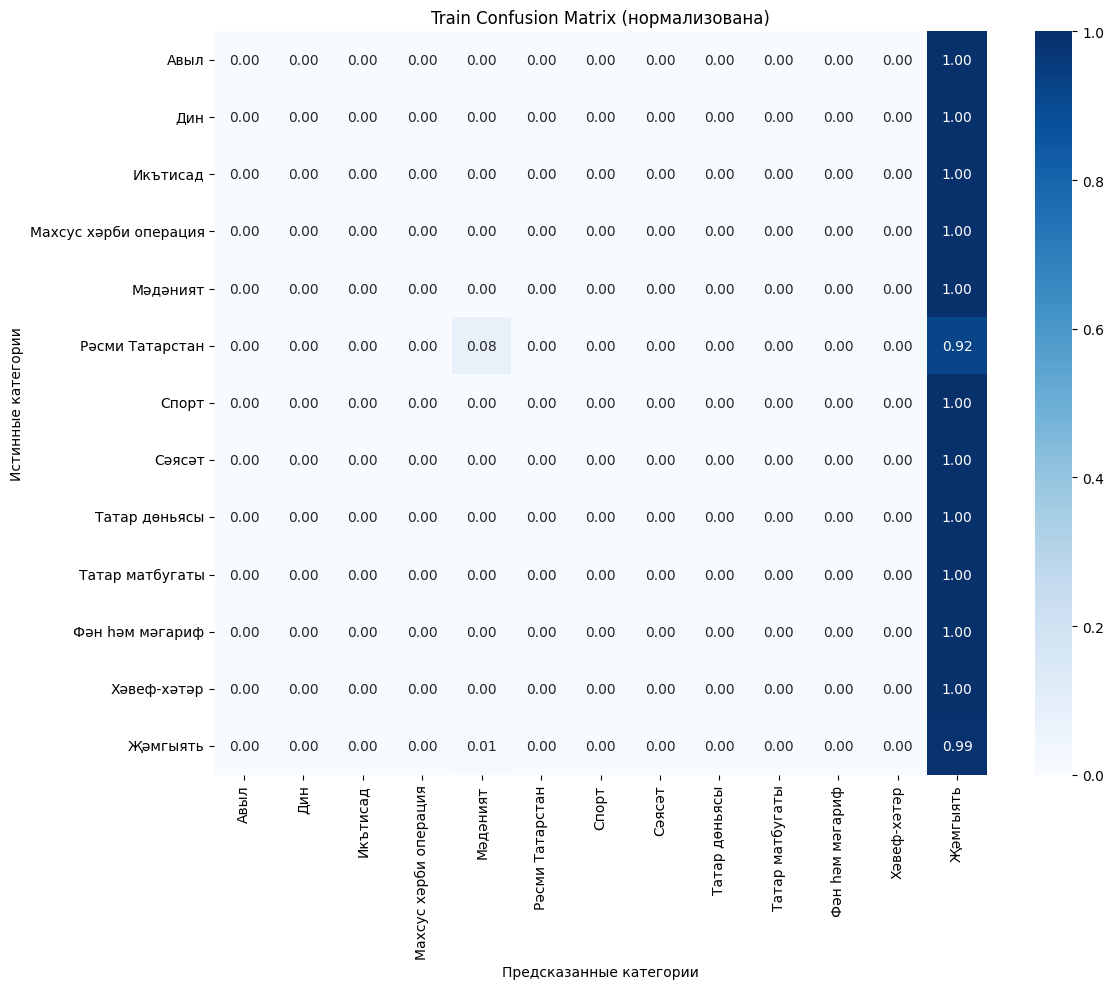


🏗️  АНАЛИЗ АРХИТЕКТУРЫ МОДЕЛИ:
   Модель эмбеддингов: paraphrase-multilingual-MiniLM-L12-v2
   Размерность эмбеддингов: 384
   Архитектура MLP: (256, 128)
   Количество слоев: 3
   Функция активации: relu
   Алгоритм оптимизации: adam

📊 ИНФОРМАЦИЯ О ПАРАМЕТРАХ:
   Слой 1: 256 → 384 нейронов, 98,560 параметров
   Слой 2: 128 → 256 нейронов, 32,896 параметров
   Слой 3: 13 → 128 нейронов, 1,677 параметров
   Всего параметров: 133,133

📈 КРИВАЯ ОБУЧЕНИЯ:
   Финальная loss: 1.643760935198222
   Количество итераций: 12


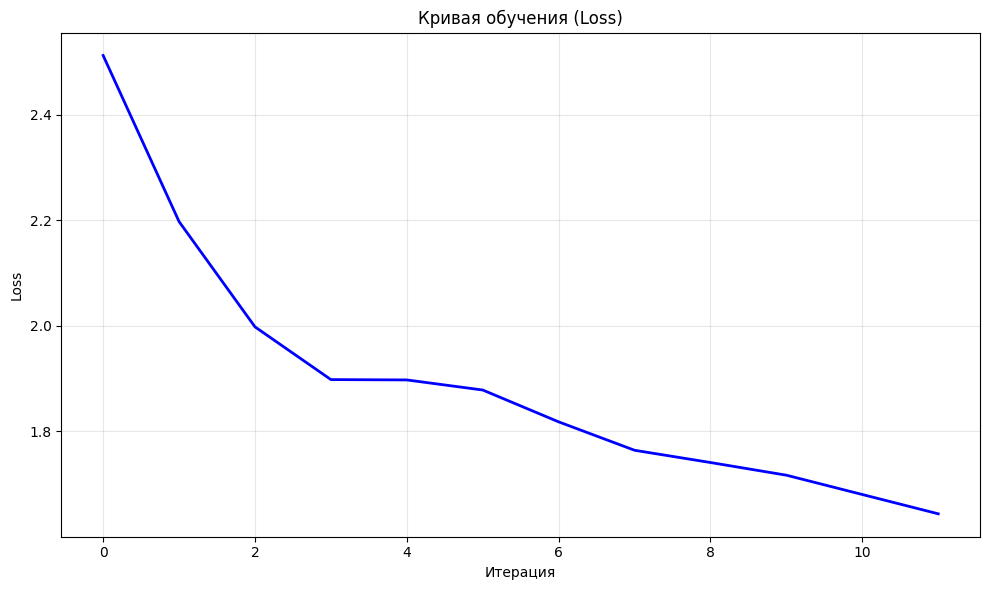

   Кривая обучения сохранена как: training_loss_curve.png

🧪 ТЕСТИРОВАНИЕ НА ТЕСТОВЫХ ДАННЫХ...
Генерация эмбеддингов для 95 текстов...


Генерация эмбеддингов: 100%|██████████| 3/3 [00:00<00:00,  8.54it/s]



📊 ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ:

📊 ОБЩИЕ МЕТРИКИ:
   Accuracy: 0.5158
   Samples: 95

🎯 ОТЧЕТ ПО КАТЕГОРИЯМ:
                       precision    recall  f1-score   support

                 Авыл     0.0000    0.0000    0.0000         1
                  Дин     0.0000    0.0000    0.0000         3
             Икътисад     0.0000    0.0000    0.0000         2
Махсус хәрби операция     0.0000    0.0000    0.0000         5
             Мәдәният     0.0000    0.0000    0.0000         8
      Рәсми Татарстан     0.0000    0.0000    0.0000         3
                Спорт     0.0000    0.0000    0.0000         3
               Сәясәт     0.0000    0.0000    0.0000         2
        Татар дөньясы     0.0000    0.0000    0.0000         6
      Татар матбугаты     0.0000    0.0000    0.0000         1
      Фән һәм мәгариф     0.0000    0.0000    0.0000         4
          Хәвеф-хәтәр     0.0000    0.0000    0.0000         8
             Җәмгыять     0.5158    1.0000    0.6806        49

        

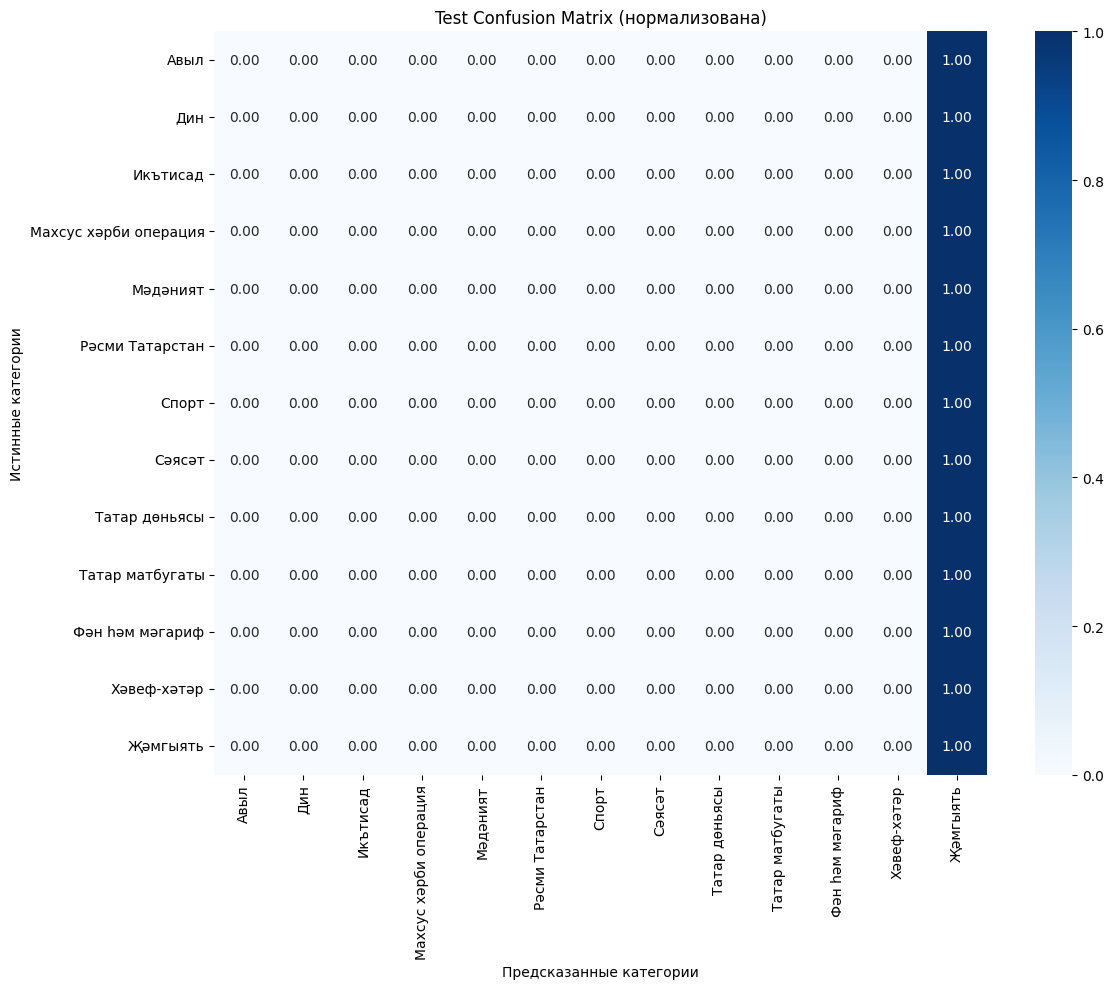


🧪 ПРИМЕРЫ ПРЕДСКАЗАНИЙ:
Генерация эмбеддингов для 1 текстов...


Генерация эмбеддингов: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]



   Пример 1: 'Новейшие технологии искусственного интеллекта меняют мир...'
      → Категория: Җәмгыять
      → Уверенность: 12.6%
      Топ-3 категории:
        1. Җәмгыять: 12.6%
        2. Сәясәт: 11.3%
        3. Мәдәният: 9.7%
Генерация эмбеддингов для 1 текстов...


Генерация эмбеддингов: 100%|██████████| 1/1 [00:00<00:00, 62.30it/s]



   Пример 2: 'Финансовые рынки демонстрируют устойчивый рост...'
      → Категория: Җәмгыять
      → Уверенность: 11.4%
      Топ-3 категории:
        1. Җәмгыять: 11.4%
        2. Сәясәт: 10.3%
        3. Фән һәм мәгариф: 8.9%
Генерация эмбеддингов для 1 текстов...


Генерация эмбеддингов: 100%|██████████| 1/1 [00:00<00:00, 61.73it/s]


   Пример 3: 'Международные отношения находятся в сложной фазе...'
      → Категория: Җәмгыять
      → Уверенность: 12.0%
      Топ-3 категории:
        1. Җәмгыять: 12.0%
        2. Икътисад: 10.5%
        3. Сәясәт: 10.0%

💾 Модель сохранена: mlp_category_model.pkl


In [1]:
import numpy as np
import joblib
from sentence_transformers import SentenceTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
from typing import List, Dict, Any, Optional, Tuple
from collections import Counter
from tqdm import tqdm

warnings.filterwarnings('ignore')


class MLPCategoryClassifier:
    """
    MLP классификатор категорий на эмбеддингах Sentence Transformers
    """

    def __init__(self,
                 embedding_model: str = 'paraphrase-multilingual-MiniLM-L12-v2',
                 hidden_layers: Tuple[int, ...] = (256, 128),
                 activation: str = 'relu',
                 solver: str = 'adam',
                 max_iter: int = 200,
                 random_state: int = 42,
                 text_field: str = 'text',
                 label_field: str = 'category'):
        """
        Args:
            embedding_model: модель для генерации эмбеддингов
            hidden_layers: размеры скрытых слоев
            activation: функция активации
            solver: алгоритм оптимизации
            max_iter: максимальное количество итераций
            random_state: для воспроизводимости
            text_field: название поля с текстом
            label_field: название поля с меткой категории
        """
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_model = embedding_model

        self.mlp = MLPClassifier(
            hidden_layer_sizes=hidden_layers,
            activation=activation,
            solver=solver,
            max_iter=max_iter,
            random_state=random_state,
            verbose=True,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10
        )

        self.label_encoder = LabelEncoder()
        self.text_field = text_field
        self.label_field = label_field
        self.is_trained = False
        self.num_classes = 0
        self.class_names = None

    def prepare_data(self, data: List[Dict[str, Any]]) -> Tuple[List[str], List[str]]:
        """
        Извлекаем тексты и метки из данных
        """
        texts = [item[self.text_field] for item in data]
        labels = [item[self.label_field] for item in data]
        return texts, labels

    def analyze_class_distribution(self, data: List[Dict[str, Any]]) -> Dict[str, Any]:
        """
        Анализ распределения категорий в данных
        """
        _, labels = self.prepare_data(data)
        label_counts = Counter(labels)

        result = {
            'total_samples': len(data),
            'num_classes': len(label_counts),
            'classes': dict(label_counts),
            'class_percentages': {},
            'imbalance_ratio': None,
            'unique_labels': sorted(list(label_counts.keys()))
        }

        if label_counts:
            max_count = max(label_counts.values())
            min_count = min(label_counts.values())
            if min_count > 0:
                result['imbalance_ratio'] = max_count / min_count

            for label, count in label_counts.items():
                result['class_percentages'][label] = count / len(data) * 100

        return result

    def get_embeddings(self, texts: List[str], batch_size: int = 32) -> np.ndarray:
        """
        Генерация эмбеддингов для текстов
        """
        print(f"Генерация эмбеддингов для {len(texts)} текстов...")
        embeddings = []

        # Используем батчи для больших датасетов
        for i in tqdm(range(0, len(texts), batch_size), desc="Генерация эмбеддингов"):
            batch = texts[i:i + batch_size]
            batch_embeddings = self.embedder.encode(batch, show_progress_bar=False)
            embeddings.append(batch_embeddings)

        return np.vstack(embeddings)

    def train(self, train_data: List[Dict[str, Any]],
              val_data: Optional[List[Dict[str, Any]]] = None) -> None:
        """
        Обучение модели
        """
        print("🎯 ОБУЧЕНИЕ MLP КЛАССИФИКАТОРА КАТЕГОРИЙ...")
        print(f"   Поле с текстом: '{self.text_field}'")
        print(f"   Поле с категорией: '{self.label_field}'")
        print(f"   Модель эмбеддингов: {self.embedding_model}")
        print(f"   Архитектура MLP: {self.mlp.hidden_layer_sizes}")

        # Анализ распределения категорий
        train_dist = self.analyze_class_distribution(train_data)
        print(f"\n📊 РАСПРЕДЕЛЕНИЕ КАТЕГОРИЙ В TRAIN:")
        print(f"   Всего примеров: {train_dist['total_samples']}")
        print(f"   Количество категорий: {train_dist['num_classes']}")

        if train_dist['imbalance_ratio']:
            print(f"   Коэффициент дисбаланса: {train_dist['imbalance_ratio']:.2f}")

        # Подготовка данных
        X_train, y_train_raw = self.prepare_data(train_data)

        # Кодируем метки
        self.label_encoder.fit(y_train_raw)
        y_train = self.label_encoder.transform(y_train_raw)
        self.class_names = list(self.label_encoder.classes_)
        self.num_classes = len(self.class_names)

        # Выводим информацию о категориях
        print(f"\n📋 СПИСОК КАТЕГОРИЙ ({self.num_classes}):")
        for i, (class_name, count) in enumerate(train_dist['classes'].items()):
            percentage = train_dist['class_percentages'].get(class_name, 0)
            print(f"   {i+1:2d}. {class_name}: {count} примеров ({percentage:.1f}%)")

        # Генерация эмбеддингов
        print("\n📊 Генерация эмбеддингов...")
        X_embeddings = self.get_embeddings(X_train)
        print(f"   Размерность эмбеддингов: {X_embeddings.shape}")

        # Обучение MLP
        print("\n🤖 Обучение MLP...")
        self.mlp.fit(X_embeddings, y_train)
        self.is_trained = True

        # Оценка на тренировочных данных
        train_pred = self.mlp.predict(X_embeddings)
        train_proba = self.mlp.predict_proba(X_embeddings)

        print("\n" + "="*60)
        print("📊 МЕТРИКИ НА ОБУЧАЮЩЕЙ ВЫБОРКЕ:")
        print("="*60)
        self._print_metrics(y_train, train_pred, train_proba)

        # Оценка на валидации, если есть
        if val_data:
            val_accuracy, _ = self.evaluate(val_data, detailed=False)
            print(f"✅ Точность на val: {val_accuracy:.3f}")

        # Матрица ошибок на train
        if self.num_classes > 1 and self.num_classes <= 15:
            self._plot_confusion_matrix(y_train, train_pred, "Train Confusion Matrix")

    def predict(self, texts: List[str]) -> Tuple[List[str], np.ndarray]:
        """
        Предсказание для списка текстов
        """
        if not self.is_trained:
            raise ValueError("Модель не обучена!")

        embeddings = self.get_embeddings(texts)
        predictions_encoded = self.mlp.predict(embeddings)
        probabilities = self.mlp.predict_proba(embeddings)

        predictions = self.label_encoder.inverse_transform(predictions_encoded)
        return predictions, probabilities

    def predict_single(self, text: str) -> Dict[str, Any]:
        """
        Предсказание для одного текста с детальной информацией
        """
        predictions, probabilities = self.predict([text])
        pred = predictions[0]
        pred_encoded = self.label_encoder.transform([pred])[0]
        prob = probabilities[0]

        # Получаем вероятности для всех категорий
        class_probs = {}
        for i, cls in enumerate(self.class_names):
            class_probs[cls] = prob[i]

        # Находим топ-3 наиболее вероятных категории
        top_n = min(3, self.num_classes)
        top_indices = np.argsort(prob)[-top_n:][::-1]
        top_categories = []
        for idx in top_indices:
            top_categories.append({
                'category': self.class_names[idx],
                'probability': prob[idx],
                'probability_percent': prob[idx] * 100
            })

        return {
            'prediction': pred,
            'category': pred,
            'prediction_encoded': pred_encoded,
            'category_probabilities': class_probs,
            'top_categories': top_categories,
            'confidence': prob[pred_encoded],
            'confidence_percent': prob[pred_encoded] * 100,
            'model_type': 'MLP (Sentence Transformers)'
        }

    def evaluate(self, test_data: List[Dict[str, Any]],
                 detailed: bool = True,
                 plot_confusion_matrix: bool = True) -> Tuple[float, Dict]:
        """
        Полная оценка модели на тестовых данных
        """
        X_test, y_test_raw = self.prepare_data(test_data)

        # Безопасное преобразование меток
        y_test = []
        for label in y_test_raw:
            if label in self.label_encoder.classes_:
                y_test.append(label)
            else:
                y_test.append(self.class_names[0])

        y_test_encoded = self.label_encoder.transform(y_test)

        # Предсказание
        predictions, probabilities = self.predict(X_test)
        y_pred_encoded = self.label_encoder.transform(predictions)

        if detailed:
            print("\n" + "="*60)
            print("📊 ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ:")
            print("="*60)

            # Все метрики
            self._print_metrics(y_test_encoded, y_pred_encoded, probabilities)

            # ROC кривые для многоклассовой классификации
            if self.num_classes <= 10:  # Строим ROC только для разумного количества классов
                self._plot_multiclass_roc(y_test_encoded, probabilities)

            # Матрица ошибок
            if plot_confusion_matrix and self.num_classes > 1 and self.num_classes <= 15:
                self._plot_confusion_matrix(y_test_encoded, y_pred_encoded, "Test Confusion Matrix")

        # Дополнительные метрики
        report_dict = classification_report(y_test_encoded, y_pred_encoded,
                                           target_names=self.class_names,
                                           output_dict=True)

        accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
        return accuracy, report_dict

    def _print_metrics(self, y_true: np.ndarray, y_pred: np.ndarray, y_proba: np.ndarray):
        """
        Вывод всех метрик
        """
        # Базовые метрики
        print(f"\n📊 ОБЩИЕ МЕТРИКИ:")
        print(f"   Accuracy: {accuracy_score(y_true, y_pred):.4f}")
        print(f"   Samples: {len(y_true)}")

        # Отчет по классам
        print(f"\n🎯 ОТЧЕТ ПО КАТЕГОРИЯМ:")
        print(classification_report(y_true, y_pred, target_names=self.class_names, digits=4))

        # Macro и Micro средние
        print(f"\n📈 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Precision (micro): {precision_score(y_true, y_pred, average='micro'):.4f}")
        print(f"   Recall (micro): {recall_score(y_true, y_pred, average='micro'):.4f}")
        print(f"   F1-Score (micro): {f1_score(y_true, y_pred, average='micro'):.4f}")

        # ROC-AUC для многоклассовой классификации
        if self.num_classes > 2:
            # One-vs-Rest ROC-AUC
            y_true_bin = label_binarize(y_true, classes=range(self.num_classes))

            # Вычисляем ROC-AUC для каждого класса
            roc_auc_per_class = []
            for i in range(self.num_classes):
                if len(np.unique(y_true_bin[:, i])) > 1:
                    auc = roc_auc_score(y_true_bin[:, i], y_proba[:, i])
                    roc_auc_per_class.append(auc)

            if roc_auc_per_class:
                print(f"\n📈 ROC-AUC (One-vs-Rest):")
                for i, auc in enumerate(roc_auc_per_class):
                    print(f"   {self.class_names[i]:<20}: {auc:.4f}")
                print(f"   Macro-average AUC: {np.mean(roc_auc_per_class):.4f}")

        # Матрица ошибок (текстовый вывод)
        print(f"\n📊 МАТРИЦА ОШИБОК (сокращенная):")
        cm = confusion_matrix(y_true, y_pred)
        if self.num_classes <= 10:
            self._print_confusion_matrix(cm)
        else:
            print(f"   Матрица слишком большая для отображения ({self.num_classes}x{self.num_classes})")
            # Показываем диагональные элементы (правильные предсказания)
            correct_predictions = np.diag(cm)
            total_samples = np.sum(cm)
            print(f"   Правильные предсказания: {np.sum(correct_predictions)}/{total_samples} "
                  f"({np.sum(correct_predictions)/total_samples*100:.1f}%)")

    def _print_confusion_matrix(self, cm: np.ndarray):
        """
        Красивый вывод матрицы ошибок
        """
        n_classes = len(self.class_names)

        if n_classes <= 1:
            print("❌ Недостаточно классов для матрицы ошибок")
            return

        # Сокращаем названия классов для отображения
        short_names = [name[:10] for name in self.class_names]

        print("              Predicted")
        print("               " + " ".join([f"{name:>10}" for name in short_names]))
        print("            ┌" + "─" * (n_classes * 11 + 1) + "┐")

        for i, (name, row) in enumerate(zip(short_names, cm)):
            row_str = " │ ".join([f"{val:10}" for val in row])
            print(f"Actual {name:6} │ {row_str} │")
            if i < n_classes - 1:
                print("            ├" + "─" * (n_classes * 11 + 1) + "┤")

        print("            └" + "─" * (n_classes * 11 + 1) + "┘")

        # Дополнительная информация
        print(f"\n📈 ДЕТАЛИЗАЦИЯ:")
        correct_predictions = np.diag(cm)
        for i, (class_name, correct) in enumerate(zip(self.class_names, correct_predictions)):
            total = np.sum(cm[i, :])
            if total > 0:
                accuracy = correct / total * 100
                print(f"   {class_name:<20}: {correct}/{total} ({accuracy:.1f}%)")

        total_correct = np.sum(correct_predictions)
        total_samples = np.sum(cm)
        print(f"\n   Общая точность: {total_correct}/{total_samples} ({total_correct/total_samples*100:.1f}%)")

    def _plot_confusion_matrix(self, y_true: np.ndarray,
                               y_pred: np.ndarray,
                               title: str = "Confusion Matrix") -> None:
        """
        Визуализация матрицы ошибок
        """
        try:
            if self.num_classes <= 1 or self.num_classes > 15:
                return

            cm = confusion_matrix(y_true, y_pred)

            plt.figure(figsize=(max(10, min(self.num_classes, 12)),
                               max(8, min(self.num_classes * 0.8, 10))))

            # Нормализуем по строкам (по истинным меткам)
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cm_normalized = np.nan_to_num(cm_normalized)  # Заменяем NaN на 0

            sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                       xticklabels=self.class_names,
                       yticklabels=self.class_names,
                       vmin=0, vmax=1)
            plt.title(f"{title} (нормализована)")
            plt.ylabel('Истинные категории')
            plt.xlabel('Предсказанные категории')
            plt.tight_layout()

            filename = title.lower().replace(' ', '_').replace('(', '').replace(')', '').replace(' ', '_')
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
            plt.show()
        except Exception as e:
            print(f"⚠️  Не удалось построить матрицу ошибок: {e}")

    def _plot_multiclass_roc(self, y_true: np.ndarray, y_proba: np.ndarray):
        """
        Построение ROC-кривых для многоклассовой классификации
        """
        if self.num_classes <= 2:
            return

        # One-vs-Rest ROC кривые
        y_true_bin = label_binarize(y_true, classes=range(self.num_classes))

        # Вычисляем ROC кривые для каждого класса
        fpr = {}
        tpr = {}
        roc_auc = {}

        plt.figure(figsize=(10, 8))

        for i in range(self.num_classes):
            if len(np.unique(y_true_bin[:, i])) > 1:
                fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
                roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_proba[:, i])

                # Строим кривую для этого класса
                plt.plot(fpr[i], tpr[i], lw=2,
                        label=f'{self.class_names[i]} (AUC = {roc_auc[i]:.3f})')

        # Случайный классификатор
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves (One-vs-Rest)')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)

        # Сохраняем и показываем
        plt.savefig('multiclass_roc_curves.png', dpi=150, bbox_inches='tight')
        plt.show()

        print(f"\n📈 ROC КРИВЫЕ ДЛЯ {self.num_classes} КЛАССОВ:")
        print(f"   ROC curves saved as: multiclass_roc_curves.png")

    def analyze_model_architecture(self):
        """
        Анализ архитектуры модели
        """
        if not self.is_trained:
            print("❌ Модель не обучена!")
            return

        print("\n🏗️  АНАЛИЗ АРХИТЕКТУРЫ МОДЕЛИ:")
        print("=" * 50)

        print(f"   Модель эмбеддингов: {self.embedding_model}")
        print(f"   Размерность эмбеддингов: {self.mlp.coefs_[0].shape[0]}")
        print(f"   Архитектура MLP: {self.mlp.hidden_layer_sizes}")
        print(f"   Количество слоев: {len(self.mlp.coefs_)}")
        print(f"   Функция активации: {self.mlp.activation}")
        print(f"   Алгоритм оптимизации: {self.mlp.solver}")

        # Информация о параметрах
        print(f"\n📊 ИНФОРМАЦИЯ О ПАРАМЕТРАХ:")
        total_params = 0
        for i, (coef, intercept) in enumerate(zip(self.mlp.coefs_, self.mlp.intercepts_)):
            layer_params = coef.size + intercept.size
            total_params += layer_params
            print(f"   Слой {i+1}: {coef.shape[1]} → {coef.shape[0]} нейронов, "
                  f"{layer_params:,} параметров")

        print(f"   Всего параметров: {total_params:,}")

        # Информация о обучении
        if hasattr(self.mlp, 'loss_curve_'):
            print(f"\n📈 КРИВАЯ ОБУЧЕНИЯ:")
            final_loss = self.mlp.loss_curve_[-1] if len(self.mlp.loss_curve_) > 0 else "N/A"
            print(f"   Финальная loss: {final_loss}")
            print(f"   Количество итераций: {self.mlp.n_iter_}")

            # Визуализация кривой обучения
            plt.figure(figsize=(10, 6))
            plt.plot(self.mlp.loss_curve_, 'b-', linewidth=2)
            plt.title('Кривая обучения (Loss)')
            plt.xlabel('Итерация')
            plt.ylabel('Loss')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('training_loss_curve.png', dpi=150, bbox_inches='tight')
            plt.show()
            print(f"   Кривая обучения сохранена как: training_loss_curve.png")

    def save(self, filename: str):
        """
        Сохранение модели
        """
        joblib.dump({
            'mlp': self.mlp,
            'label_encoder': self.label_encoder,
            'class_names': self.class_names,
            'num_classes': self.num_classes,
            'embedding_model': self.embedding_model,
            'text_field': self.text_field,
            'label_field': self.label_field,
            'is_trained': self.is_trained
        }, filename)
        print(f"\n💾 Модель сохранена: {filename}")

    def load(self, filename: str):
        """
        Загрузка модели
        """
        data = joblib.load(filename)

        self.mlp = data['mlp']
        self.label_encoder = data['label_encoder']
        self.class_names = data['class_names']
        self.num_classes = data['num_classes']
        self.embedding_model = data['embedding_model']
        self.text_field = data.get('text_field', 'text')
        self.label_field = data.get('label_field', 'category')
        self.is_trained = data.get('is_trained', True)

        # Пересоздаем embedder если нужно
        if not hasattr(self, 'embedder') or self.embedder._model_name != self.embedding_model:
            self.embedder = SentenceTransformer(self.embedding_model)

        print(f"📥 Модель загружена: {filename}")
        print(f"   Категории: {self.class_names}")
        print(f"   Количество категорий: {self.num_classes}")
        print(f"   Модель эмбеддингов: {self.embedding_model}")


def quick_train_mlp(train_file: str,
                   val_file: Optional[str] = None,
                   test_file: Optional[str] = None,
                   text_field: str = 'text',
                   label_field: str = 'category',
                   embedding_model: str = 'paraphrase-multilingual-MiniLM-L12-v2',
                   hidden_layers: Tuple[int, ...] = (256, 128),
                   output_model: str = 'mlp_category_classifier.pkl') -> Optional[MLPCategoryClassifier]:
    """
    Быстрое обучение MLP модели из файлов
    """
    import json
    import os

    def load_jsonl(filepath: str) -> List[Dict[str, Any]]:
        if not os.path.exists(filepath):
            print(f"⚠️  Файл не найден: {filepath}")
            return []
        with open(filepath, 'r', encoding='utf-8') as f:
            return [json.loads(line) for line in f]

    print("🚀 ЗАПУСК БЫСТРОГО ОБУЧЕНИЯ MLP КЛАССИФИКАТОРА")
    print("=" * 60)

    # Загрузка данных
    print(f"\n📥 Загрузка данных...")
    train_data = load_jsonl(train_file)
    if not train_data:
        print(f"❌ Ошибка: не удалось загрузить тренировочные данные из {train_file}")
        return None

    print(f"   Train: {len(train_data)} примеров")

    if val_file:
        val_data = load_jsonl(val_file)
        print(f"   Val: {len(val_data)} примеров")
    else:
        val_data = None

    if test_file:
        test_data = load_jsonl(test_file)
        print(f"   Test: {len(test_data)} примеров")
    else:
        test_data = None

    # Проверяем структуру данных
    if train_data:
        sample_item = train_data[0]
        if text_field not in sample_item:
            print(f"❌ Ошибка: поле '{text_field}' не найдено в данных")
            return None
        if label_field not in sample_item:
            print(f"❌ Ошибка: поле '{label_field}' не найдено в данных")
            return None

    # Обучаем модель
    print(f"\n🎯 Начало обучения MLP...")
    print(f"   Модель эмбеддингов: {embedding_model}")
    print(f"   Архитектура MLP: {hidden_layers}")

    classifier = MLPCategoryClassifier(
        embedding_model=embedding_model,
        hidden_layers=hidden_layers,
        text_field=text_field,
        label_field=label_field
    )

    # Используем подмножество если данных много
    if len(train_data) > 1000:
        print(f"ℹ️  Используем подмножество из 1000 примеров для обучения")
        train_subset = train_data[:1000]
    else:
        train_subset = train_data

    classifier.train(train_subset, val_data)

    # Анализ архитектуры
    classifier.analyze_model_architecture()

    # Тестируем, если есть тестовые данные
    if test_data:
        print(f"\n🧪 Тестирование на тестовых данных...")
        accuracy, report = classifier.evaluate(test_data, detailed=True)
        print(f"\n🎯 Итоговая точность на тесте: {accuracy:.3f}")

        # Сохраняем отчет
        if report:
            report_df = pd.DataFrame(report).transpose()
            report_df.to_csv('mlp_classification_report.csv', index=True)
            print(f"📄 Детальный отчет сохранен в 'mlp_classification_report.csv'")

    # Сохраняем модель
    classifier.save(output_model)

    # Тестовый пример
    print(f"\n🧪 ТЕСТОВЫЙ ПРИМЕР РАБОТЫ МОДЕЛИ:")
    if train_data:
        sample_text = train_data[0][text_field]
        if len(sample_text) > 100:
            sample_text = sample_text[:100] + "..."
        result = classifier.predict_single(sample_text)
        print(f"   Текст: '{sample_text}'")
        print(f"   Предсказанная категория: {result['prediction']}")
        print(f"   Уверенность: {result['confidence_percent']:.1f}%")

        if result['top_categories']:
            print(f"   Топ-3 категории:")
            for i, cat in enumerate(result['top_categories'], 1):
                print(f"     {i}. {cat['category']}: {cat['probability_percent']:.1f}%")

    return classifier


def main():
    """
    Пример использования MLP классификатора для многоклассовой классификации
    """
    try:
        import json

        # Загрузка данных
        def load_jsonl(filepath):
            with open(filepath, 'r', encoding='utf-8') as f:
                return [json.loads(line) for line in f]

        print("🚀 ЗАГРУЗКА ДАННЫХ...")
        train_data = load_jsonl('/content/news_category_train.jsonl')
        val_data = load_jsonl('/content/news_category_val.jsonl')
        test_data = load_jsonl('/content/news_category_test.jsonl')

        print(f"Обучающих примеров: {len(train_data)}")
        print(f"Валидационных примеров: {len(val_data)}")
        print(f"Тестовых примеров: {len(test_data)}")

        # Проверяем структуру данных
        if train_data:
            print(f"\n📋 ПРИМЕР ДАННЫХ:")
            sample = train_data[0]
            print(f"   Поля: {list(sample.keys())}")
            print(f"   Текст: {sample.get('text', 'N/A')[:100]}...")
            print(f"   Категория: {sample.get('category', 'N/A')}")

        # Создаем и обучаем модель
        print("\n🎯 СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ...")

        model = MLPCategoryClassifier(
            embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
            hidden_layers=(256, 128),
            text_field='text',
            label_field='category'
        )

        # Используем подмножество если данных много
        if len(train_data) > 500:
            train_subset = train_data[:500]
            print(f"ℹ️  Используем подмножество из {len(train_subset)} примеров")
        else:
            train_subset = train_data

        model.train(train_subset, val_data)

        # Анализ архитектуры
        model.analyze_model_architecture()

        # Оценка на тестовых данных
        print("\n🧪 ТЕСТИРОВАНИЕ НА ТЕСТОВЫХ ДАННЫХ...")
        if test_data:
            metrics = model.evaluate(test_data)

            # Детальные примеры
            print("\n🧪 ПРИМЕРЫ ПРЕДСКАЗАНИЙ:")
            test_texts = [
                "Новейшие технологии искусственного интеллекта меняют мир",
                "Финансовые рынки демонстрируют устойчивый рост",
                "Международные отношения находятся в сложной фазе"
            ]

            for i, text in enumerate(test_texts, 1):
                result = model.predict_single(text)
                print(f"\n   Пример {i}: '{text[:60]}...'")
                print(f"      → Категория: {result['prediction']}")
                print(f"      → Уверенность: {result['confidence_percent']:.1f}%")

                if result['top_categories']:
                    print(f"      Топ-3 категории:")
                    for j, cat in enumerate(result['top_categories'], 1):
                        print(f"        {j}. {cat['category']}: {cat['probability_percent']:.1f}%")

        # Сохраняем модель
        model.save('mlp_category_model.pkl')

    except FileNotFoundError as e:
        print(f"❌ Файл не найден: {e}")
        print("ℹ️  Проверьте пути к файлам данных")
    except Exception as e:
        print(f"❌ Произошла ошибка: {e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    # Запуск примера
    print("🚀 ЗАПУСК ПРИМЕРА ИСПОЛЬЗОВАНИЯ MLP КЛАССИФИКАТОРА")
    print("=" * 60)
    main()

PyTorch версия: 2.9.0+cu126
CUDA доступен: True
Sentence Transformers доступен
🚀 ЗАПУСК CNN КЛАССИФИКАТОРА ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ
📝 Пример структуры данных:
  {'text': 'Новость о технологии', 'category': 'technology'}
  {'text': 'Политические события', 'category': 'politics'}
  {'text': 'Спортивные новости', 'category': 'sports'}
📊 Обучающих примеров: 440
📊 Тестовых примеров: 95

📝 Структура данных первого примера:
  title: Татарстан хәрби комиссариаты: «Резервчылар җыю – ул мобилизация түгел»
  text: Кемнәр ул резервистлар? Алар нәрсә белән шөгыльләнә? Алар хәрби хезмәткәрләрдән нәрсә белән аерыла? Аларны МХОга җибәрерләрме? «Татар-информ»ның бу һәм башка сорауларына Татарстан Хәрби комиссариатының бүлек начальнигы Эдуард Тимербулатов җавап бирде. «Резервчылар тормышны тәэмин итү объектларын саклый» Резервчылар җыю – үзенә күрә яшерен мобилизация дигән имеш-мимешләр социаль челтәрләрне тутырды. Кешеләр, сүзнең нәрсә турында барганын бөтенләй аңламыйча, паникага бирелә һәм на

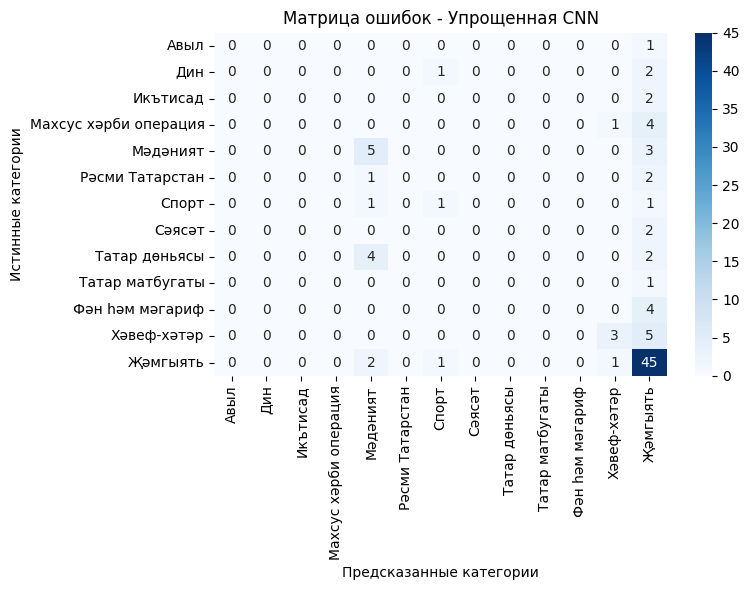


🧪 ПРЕДСКАЗАНИЕ ДЛЯ ОДНОГО ТЕКСТА:

📝 Текст: 'Новый технологический стартап привлек инвестиции'
🔮 Топ предсказания:
   Җәмгыять: 98.71%
   Хәвеф-хәтәр: 0.54%
   Мәдәният: 0.26%

🎯 ВАРИАНТ 2: ПОЛНАЯ CNN АРХИТЕКТУРА
📱 Используемое устройство: cuda
🎯 Начинаем обучение полной CNN...
🎯 НАЧИНАЕМ ОБУЧЕНИЕ CNN ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...
🎯 Обнаружено классов: 13
🎯 Классы: ['Авыл', 'Дин', 'Икътисад', 'Махсус хәрби операция', 'Мәдәният', 'Рәсми Татарстан', 'Спорт', 'Сәясәт', 'Татар дөньясы', 'Татар матбугаты', 'Фән һәм мәгариф', 'Хәвеф-хәтәр', 'Җәмгыять']

📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ:
   Җәмгыять: 226 примеров (51.4%)
   Махсус хәрби операция: 22 примеров (5.0%)
   Фән һәм мәгариф: 19 примеров (4.3%)
   Хәвеф-хәтәр: 34 примеров (7.7%)
   Спорт: 15 примеров (3.4%)
   Татар дөньясы: 26 примеров (5.9%)
   Дин: 16 примеров (3.6%)
   Татар матбугаты: 6 примеров (1.4%)
   Икътисад: 10 примеров (2.3%)
   Сәясәт: 11 примеров (2.5%)
   Мәдәният: 38 примеров (8.6%)
   Рәсми Татарстан: 13 примеров (3.0

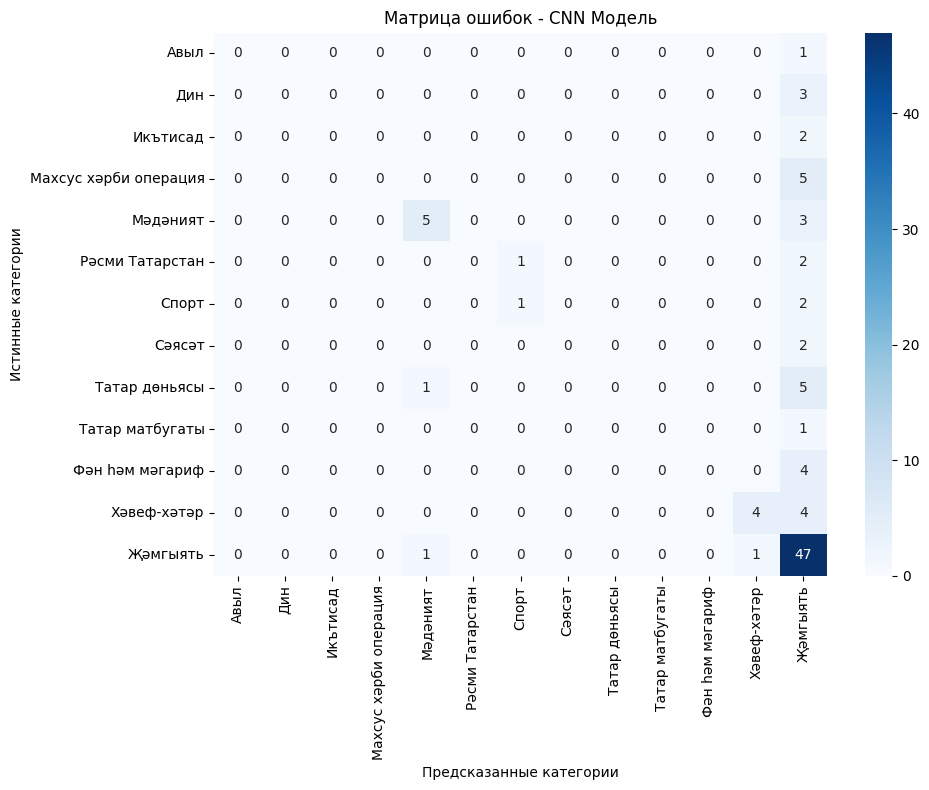


📈 Матрица ошибок сохранена как: cnn_confusion_matrix.png

📊 АНАЛИЗ МАТРИЦЫ ОШИБОК:
   Класс 'Авыл': 0/1 (0.0%) правильно
   Класс 'Дин': 0/3 (0.0%) правильно
   Класс 'Икътисад': 0/2 (0.0%) правильно
   Класс 'Махсус хәрби операция': 0/5 (0.0%) правильно
   Класс 'Мәдәният': 5/8 (62.5%) правильно
   Класс 'Рәсми Татарстан': 0/3 (0.0%) правильно
   Класс 'Спорт': 1/3 (33.3%) правильно
   Класс 'Сәясәт': 0/2 (0.0%) правильно
   Класс 'Татар дөньясы': 0/6 (0.0%) правильно
   Класс 'Татар матбугаты': 0/1 (0.0%) правильно
   Класс 'Фән һәм мәгариф': 0/4 (0.0%) правильно
   Класс 'Хәвеф-хәтәр': 4/8 (50.0%) правильно
   Класс 'Җәмгыять': 47/49 (95.9%) правильно

💾 CNN модель сохранена: multiclass_cnn_model.pth
💾 Модель успешно сохранена

🧪 ПРЕДСКАЗАНИЕ ДЛЯ ОДНОГО ТЕКСТА (Полная CNN):

📝 Текст: 'Политические переговоры на высшем уровне'
🎯 Предсказание: Җәмгыять
🔮 Уверенность: 93.50%
🏆 Топ предсказания:
   Җәмгыять: 93.50%
   Рәсми Татарстан: 1.50%
   Татар дөньясы: 1.18%

📝 Текст: 'Технологич

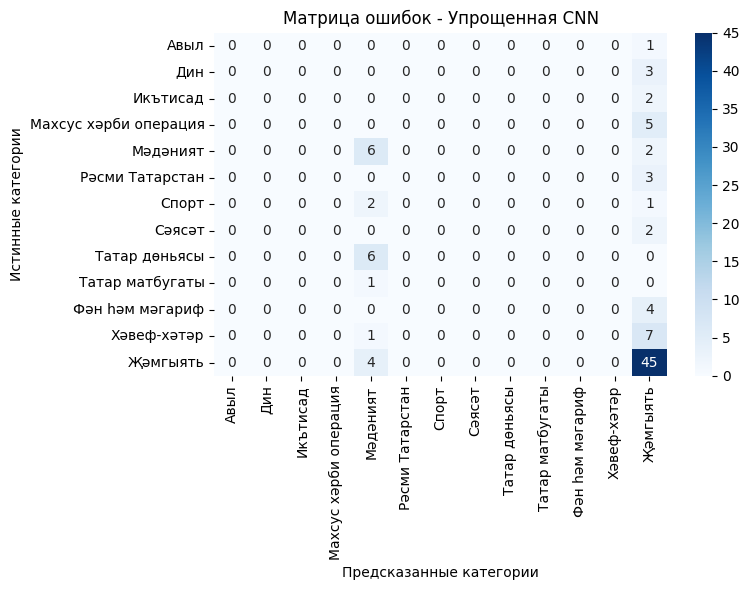


🧪 ПРЕДСКАЗАНИЕ ДЛЯ ОДНОГО ТЕКСТА:

📝 Текст: 'Новый технологический стартап привлек инвестиции'
🔮 Топ предсказания:
   Җәмгыять: 100.00%
   Хәвеф-хәтәр: 0.00%
   Икътисад: 0.00%

🎯 ВАРИАНТ 2: ПОЛНАЯ CNN АРХИТЕКТУРА
📱 Используемое устройство: cuda
🎯 Начинаем обучение полной CNN...
🎯 НАЧИНАЕМ ОБУЧЕНИЕ CNN ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...
🎯 Обнаружено классов: 13
🎯 Классы: ['Авыл', 'Дин', 'Икътисад', 'Махсус хәрби операция', 'Мәдәният', 'Рәсми Татарстан', 'Спорт', 'Сәясәт', 'Татар дөньясы', 'Татар матбугаты', 'Фән һәм мәгариф', 'Хәвеф-хәтәр', 'Җәмгыять']

📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ:
   Җәмгыять: 226 примеров (51.4%)
   Махсус хәрби операция: 22 примеров (5.0%)
   Фән һәм мәгариф: 19 примеров (4.3%)
   Хәвеф-хәтәр: 34 примеров (7.7%)
   Спорт: 15 примеров (3.4%)
   Татар дөньясы: 26 примеров (5.9%)
   Дин: 16 примеров (3.6%)
   Татар матбугаты: 6 примеров (1.4%)
   Икътисад: 10 примеров (2.3%)
   Сәясәт: 11 примеров (2.5%)
   Мәдәният: 38 примеров (8.6%)
   Рәсми Татарстан: 13 примеров (3.

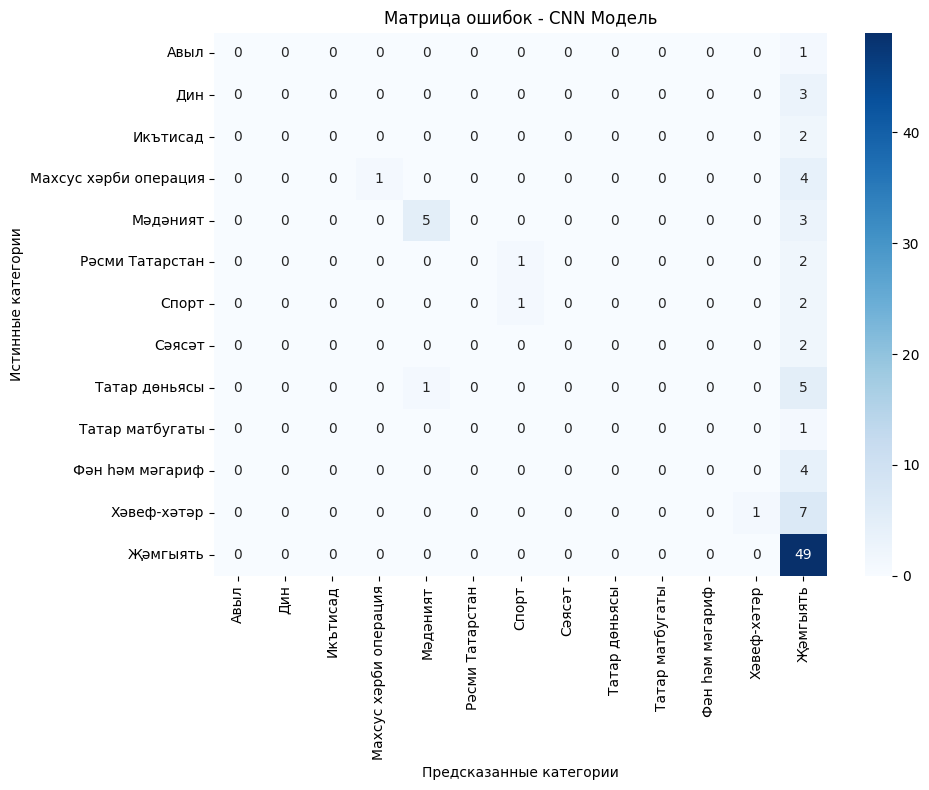


📈 Матрица ошибок сохранена как: cnn_confusion_matrix.png

📊 АНАЛИЗ МАТРИЦЫ ОШИБОК:
   Класс 'Авыл': 0/1 (0.0%) правильно
   Класс 'Дин': 0/3 (0.0%) правильно
   Класс 'Икътисад': 0/2 (0.0%) правильно
   Класс 'Махсус хәрби операция': 1/5 (20.0%) правильно
   Класс 'Мәдәният': 5/8 (62.5%) правильно
   Класс 'Рәсми Татарстан': 0/3 (0.0%) правильно
   Класс 'Спорт': 1/3 (33.3%) правильно
   Класс 'Сәясәт': 0/2 (0.0%) правильно
   Класс 'Татар дөньясы': 0/6 (0.0%) правильно
   Класс 'Татар матбугаты': 0/1 (0.0%) правильно
   Класс 'Фән һәм мәгариф': 0/4 (0.0%) правильно
   Класс 'Хәвеф-хәтәр': 1/8 (12.5%) правильно
   Класс 'Җәмгыять': 49/49 (100.0%) правильно

💾 CNN модель сохранена: multiclass_cnn_model.pth
💾 Модель успешно сохранена

🧪 ПРЕДСКАЗАНИЕ ДЛЯ ОДНОГО ТЕКСТА (Полная CNN):

📝 Текст: 'Политические переговоры на высшем уровне'
🎯 Предсказание: Җәмгыять
🔮 Уверенность: 95.41%
🏆 Топ предсказания:
   Җәмгыять: 95.41%
   Фән һәм мәгариф: 1.07%
   Сәясәт: 0.96%

📝 Текст: 'Технологические

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sentence_transformers import SentenceTransformer
import joblib
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


class TextCNN(nn.Module):
    """
    Простая CNN архитектура для многоклассовой классификации текста
    """
    def __init__(self, embedding_dim=384, num_filters=100, filter_sizes=[2, 3, 4], num_classes=5, dropout=0.5):
        super(TextCNN, self).__init__()

        # Сверточные слои
        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=filter_sizes[0], padding=1)
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size=filter_sizes[1], padding=1)
        self.conv3 = nn.Conv1d(num_filters, num_filters, kernel_size=filter_sizes[2], padding=1)

        # Полносвязный слой
        self.fc = nn.Linear(num_filters * 3, num_classes)  # 3 слоя conv

        # Dropout
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.MaxPool1d(2)

    def forward(self, x):
        """
        x: [batch_size, embedding_dim, seq_len]
        """
        # Первая свертка + pooling
        x1 = F.relu(self.conv1(x))
        x1 = self.pool(x1)

        # Вторая свертка + pooling
        x2 = F.relu(self.conv2(x1))
        x2 = self.pool(x2)

        # Третья свертка + pooling
        x3 = F.relu(self.conv3(x2))
        x3 = self.pool(x3)

        # Global average pooling
        x1_pool = F.adaptive_avg_pool1d(x1, 1).squeeze(2)
        x2_pool = F.adaptive_avg_pool1d(x2, 1).squeeze(2)
        x3_pool = F.adaptive_avg_pool1d(x3, 1).squeeze(2)

        # Объединяем
        combined = torch.cat([x1_pool, x2_pool, x3_pool], dim=1)

        # Dropout и полносвязный слой
        combined = self.dropout(combined)
        output = self.fc(combined)

        return output


class CNNSentimentClassifier:
    """
    CNN классификатор для многоклассовой классификации категорий
    """

    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
                 max_seq_len=100, batch_size=16):
        """
        Args:
            embedding_model: модель для эмбеддингов
            max_seq_len: максимальная длина последовательности
            batch_size: размер батча
        """
        # Проверяем доступность CUDA
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")

        # Загружаем модель эмбеддингов
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_model_name = embedding_model
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # Параметры
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size

        # Будем инициализировать модель после получения количества классов
        self.model = None
        self.classes = None
        self.num_classes = None

        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных из списка словарей для многоклассовой классификации
        """
        texts = []
        categories = []

        for item in data:
            if isinstance(item, dict) and 'text' in item and 'category' in item:
                texts.append(item['text'])
                categories.append(item['category'])
            else:
                print(f"⚠️ Пропущен невалидный элемент: {item}")

        # Определяем уникальные категории
        if not hasattr(self, 'classes') or self.classes is None:
            self.classes = sorted(list(set(categories)))
            self.num_classes = len(self.classes)
            print(f"🎯 Обнаружено классов: {self.num_classes}")
            print(f"🎯 Классы: {self.classes}")

            # Инициализируем модель с правильным количеством классов
            self.model = TextCNN(
                embedding_dim=self.embedding_dim,
                num_filters=128,
                filter_sizes=[2, 3, 4],
                num_classes=self.num_classes,
                dropout=0.3
            ).to(self.device)

        # Преобразуем категории в числовые индексы
        category_to_idx = {cat: idx for idx, cat in enumerate(self.classes)}
        labels = np.array([category_to_idx[cat] for cat in categories])

        # Выводим распределение классов
        print("\n📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ:")
        counter = Counter(categories)
        for cat, count in counter.items():
            print(f"   {cat}: {count} примеров ({count/len(categories)*100:.1f}%)")

        return texts, labels, category_to_idx

    def create_embeddings_sequence(self, texts):
        """
        Создание последовательности эмбеддингов для CNN
        """
        embeddings_list = []

        for text in texts:
            # Получаем эмбеддинг предложения
            sentence_embedding = self.embedder.encode(text, show_progress_bar=False)

            # Создаем последовательность, повторяя эмбеддинг
            sequence = np.tile(sentence_embedding, (self.max_seq_len, 1))

            # Обрезаем/дополняем до нужной длины
            if sequence.shape[0] > self.max_seq_len:
                sequence = sequence[:self.max_seq_len, :]
            elif sequence.shape[0] < self.max_seq_len:
                # Дополняем нулями
                padding = np.zeros((self.max_seq_len - sequence.shape[0], self.embedding_dim))
                sequence = np.vstack([sequence, padding])

            embeddings_list.append(sequence)

        return np.array(embeddings_list)

    def train(self, train_data, epochs=10, lr=0.001):
        """
        Обучение модели для многоклассовой классификации
        """
        print("🎯 НАЧИНАЕМ ОБУЧЕНИЕ CNN ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...")

        # Подготовка данных
        texts, labels, category_to_idx = self.prepare_data(train_data)
        self.category_to_idx = category_to_idx

        if len(texts) == 0:
            print("❌ Нет данных для обучения")
            return

        print(f"📊 Загружено {len(texts)} примеров")
        print(f"📊 Размерность эмбеддингов: {self.embedding_dim}")
        print(f"📊 Максимальная длина последовательности: {self.max_seq_len}")

        # Создаем последовательности эмбеддингов
        print("🔍 Создание последовательностей эмбеддингов...")
        X_sequences = self.create_embeddings_sequence(texts)

        # Преобразуем в тензоры
        X_tensor = torch.FloatTensor(X_sequences).to(self.device)
        y_tensor = torch.LongTensor(labels).to(self.device)

        # Транспонируем для Conv1d: [batch, embedding_dim, seq_len]
        X_tensor = X_tensor.transpose(1, 2)

        print(f"📊 Размерность данных: {X_tensor.shape}")

        # Оптимизатор и функция потерь
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        train_losses = []
        train_accuracies = []

        for epoch in range(epochs):
            total_loss = 0
            indices = torch.randperm(len(X_tensor))

            for i in range(0, len(indices), self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                batch_X = X_tensor[batch_indices]
                batch_y = y_tensor[batch_indices]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # Вычисляем accuracy
            with torch.no_grad():
                self.model.eval()
                outputs = self.model(X_tensor)
                _, preds = torch.max(outputs, 1)
                accuracy = (preds == y_tensor).float().mean().item()
                self.model.train()

            avg_loss = total_loss / (len(X_tensor) / self.batch_size)
            train_losses.append(avg_loss)
            train_accuracies.append(accuracy)

            print(f"📈 Эпоха {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.3f}")

        self.is_trained = True

        # Финальная оценка
        print("\n✅ ОБУЧЕНИЕ ЗАВЕРШЕНО")

        # Метрики на обучающих данных
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, preds = torch.max(outputs, 1)
            probabilities = F.softmax(outputs, dim=1)

        self._print_metrics(labels, preds.cpu().numpy(), probabilities.cpu().numpy(), "ОБУЧАЮЩАЯ ВЫБОРКА")

        return train_losses, train_accuracies

    def predict(self, texts):
        """
        Предсказание для списка текстов
        """
        if not self.is_trained:
            raise ValueError("❌ Модель не обучена!")

        # Создаем последовательности
        sequences = self.create_embeddings_sequence(texts)

        # Преобразуем в тензор
        X_tensor = torch.FloatTensor(sequences).to(self.device)
        X_tensor = X_tensor.transpose(1, 2)

        # Предсказание
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs, 1)

        # Преобразуем индексы обратно в категории
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        predicted_categories = [idx_to_category[idx] for idx in predictions.cpu().numpy()]

        return predicted_categories, predictions.cpu().numpy(), probabilities.cpu().numpy()

    def predict_single(self, text):
        """
        Предсказание для одного текста
        """
        categories, preds, probs = self.predict([text])

        # Получаем топ-3 предсказания
        top3_indices = probs[0].argsort()[-3:][::-1]
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}

        top_predictions = []
        for idx in top3_indices:
            top_predictions.append({
                'category': idx_to_category[idx],
                'probability': float(probs[0][idx])
            })

        return {
            'prediction': categories[0],
            'confidence': float(max(probs[0])),
            'all_probabilities': {idx_to_category[i]: float(prob) for i, prob in enumerate(probs[0])},
            'top_predictions': top_predictions
        }

    def evaluate(self, test_data):
        """
        Полная оценка модели
        """
        texts, true_labels, _ = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return None

        # Предсказание
        predicted_categories, predictions, probabilities = self.predict(texts)

        print("\n" + "="*60)
        print("📊 ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
        print("="*60)

        # Все метрики
        self._print_metrics(true_labels, predictions, probabilities, "ТЕСТОВАЯ ВЫБОРКА")

        # Матрица ошибок с именами классов
        self._plot_confusion_matrix(true_labels, predictions)

        return {
            'accuracy': accuracy_score(true_labels, predictions),
            'predictions': predictions,
            'predicted_categories': predicted_categories,
            'probabilities': probabilities
        }

    def _print_metrics(self, y_true, y_pred, y_proba=None, dataset_name=""):
        """
        Вывод всех метрик для многоклассовой классификации
        """
        print(f"\n📊 МЕТРИКИ ДЛЯ {dataset_name}:")
        print(f"   Количество примеров: {len(y_true)}")

        # Accuracy
        acc = accuracy_score(y_true, y_pred)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report с именами классов
        print("\n📈 Classification Report:")
        target_names = [str(cls) for cls in self.classes]
        print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

        # Macro и Weighted средние
        print(f"\n📊 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"   Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"   F1-Score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")

        # ROC-AUC для многоклассовой (если не слишком много классов)
        if y_proba is not None and self.num_classes <= 10:
            try:
                # Бинаризируем метки для многоклассового ROC-AUC
                y_true_bin = label_binarize(y_true, classes=range(self.num_classes))

                # Вычисляем ROC-AUC для каждого класса
                roc_auc_scores = []
                for i in range(self.num_classes):
                    if len(np.unique(y_true_bin[:, i])) > 1:  # Проверяем, есть ли положительные примеры
                        auc = roc_auc_score(y_true_bin[:, i], y_proba[:, i])
                        roc_auc_scores.append(auc)
                        print(f"   ROC-AUC для класса '{self.classes[i]}': {auc:.4f}")

                if roc_auc_scores:
                    print(f"   ROC-AUC (macro avg): {np.mean(roc_auc_scores):.4f}")
            except Exception as e:
                print(f"   ⚠️ ROC-AUC calculation skipped: {e}")

    def _plot_confusion_matrix(self, y_true, y_pred):
        """
        Построение матрицы ошибок с именами классов
        """
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.classes,
                   yticklabels=self.classes)

        plt.title('Матрица ошибок - CNN Модель')
        plt.ylabel('Истинные категории')
        plt.xlabel('Предсказанные категории')
        plt.tight_layout()

        plt.savefig('cnn_confusion_matrix.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n📈 Матрица ошибок сохранена как: cnn_confusion_matrix.png")

        # Детальный анализ матрицы ошибок
        print("\n📊 АНАЛИЗ МАТРИЦЫ ОШИБОК:")
        for i, true_class in enumerate(self.classes):
            total_true = cm[i].sum()
            correct = cm[i, i]
            accuracy_per_class = correct / total_true if total_true > 0 else 0
            print(f"   Класс '{true_class}': {correct}/{total_true} ({accuracy_per_class:.1%}) правильно")

    def save(self, filename):
        """
        Сохранение модели
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'embedding_model': self.embedding_model_name,
            'embedding_dim': self.embedding_dim,
            'max_seq_len': self.max_seq_len,
            'classes': self.classes,
            'num_classes': self.num_classes,
            'category_to_idx': self.category_to_idx,
            'is_trained': self.is_trained
        }, filename)
        print(f"\n💾 CNN модель сохранена: {filename}")

    def load(self, filename):
        """
        Загрузка модели
        """
        checkpoint = torch.load(filename, map_location=self.device)

        # Восстанавливаем классы
        self.classes = checkpoint['classes']
        self.num_classes = checkpoint['num_classes']
        self.category_to_idx = checkpoint['category_to_idx']

        # Инициализируем модель
        self.model = TextCNN(
            embedding_dim=checkpoint['embedding_dim'],
            num_filters=128,
            filter_sizes=[2, 3, 4],
            num_classes=self.num_classes,
            dropout=0.3
        ).to(self.device)

        # Загружаем веса
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

        self.embedding_model_name = checkpoint['embedding_model']
        self.embedding_dim = checkpoint['embedding_dim']
        self.max_seq_len = checkpoint['max_seq_len']
        self.is_trained = checkpoint['is_trained']

        print(f"📥 CNN модель загружена: {filename}")
        print(f"🎯 Количество классов: {self.num_classes}")
        print(f"🎯 Классы: {self.classes}")


# УПРОЩЕННАЯ ВЕРСИЯ ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ
class SimpleTextCNN:
    """
    Упрощенная CNN для многоклассовой классификации текста
    """

    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2'):
        # Устройство
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")

        # Модель для эмбеддингов
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # Инициализируем модель после получения классов
        self.model = None
        self.classes = None
        self.num_classes = None

        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных
        """
        texts = []
        categories = []

        for item in data:
            if isinstance(item, dict):
                texts.append(item.get('text', ''))
                categories.append(item.get('category', ''))

        # Определяем уникальные категории
        if not hasattr(self, 'classes') or self.classes is None:
            self.classes = sorted(list(set(categories)))
            self.num_classes = len(self.classes)
            print(f"🎯 Обнаружено классов: {self.num_classes}")
            print(f"🎯 Классы: {self.classes}")

        # Преобразуем категории в индексы
        category_to_idx = {cat: idx for idx, cat in enumerate(self.classes)}
        labels = np.array([category_to_idx[cat] for cat in categories])

        return texts, labels, category_to_idx

    def create_input_tensor(self, texts, seq_len=100):
        """
        Создание входного тензора для CNN
        """
        embeddings = []

        for text in texts:
            # Получаем эмбеддинг текста
            emb = self.embedder.encode(text, show_progress_bar=False)

            # Создаем последовательность
            seq = np.tile(emb, (seq_len, 1))

            # Обрезаем до нужной длины
            if seq.shape[0] > seq_len:
                seq = seq[:seq_len]
            elif seq.shape[0] < seq_len:
                # Дополняем нулями
                pad_len = seq_len - seq.shape[0]
                padding = np.zeros((pad_len, self.embedding_dim))
                seq = np.vstack([seq, padding])

            embeddings.append(seq)

        # Преобразуем в тензор и транспонируем для Conv1d
        tensor = torch.FloatTensor(np.array(embeddings)).to(self.device)
        tensor = tensor.transpose(1, 2)  # [batch, embedding_dim, seq_len]

        return tensor

    def train(self, train_data, epochs=10, lr=0.001):
        """
        Обучение модели
        """
        print("🎯 ОБУЧЕНИЕ УПРОЩЕННОЙ CNN ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...")

        # Подготовка данных
        texts, labels, category_to_idx = self.prepare_data(train_data)
        self.category_to_idx = category_to_idx

        if len(texts) == 0:
            print("❌ Нет данных для обучения")
            return self

        print(f"📊 Примеров: {len(texts)}")

        # Инициализируем модель если еще не инициализирована
        if self.model is None:
            self.model = nn.Sequential(
                nn.Conv1d(self.embedding_dim, 128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool1d(2),

                nn.Conv1d(128, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool1d(2),

                nn.Conv1d(64, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(1),

                nn.Flatten(),
                nn.Linear(32, 64),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(64, self.num_classes)
            ).to(self.device)

        # Создаем тензоры
        X = self.create_input_tensor(texts, seq_len=50)
        y = torch.LongTensor(labels).to(self.device)

        # Оптимизатор и функция потерь
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        for epoch in range(epochs):
            # Перемешиваем данные
            indices = torch.randperm(len(X))
            total_loss = 0

            for i in range(0, len(indices), 8):
                batch_idx = indices[i:i+8]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # Оценка accuracy
            with torch.no_grad():
                self.model.eval()
                outputs = self.model(X)
                _, preds = torch.max(outputs, 1)
                accuracy = (preds == y).float().mean().item()
                self.model.train()

            avg_loss = total_loss / (len(indices) / 8)

            print(f"📈 Эпоха {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.3f}")

        self.is_trained = True
        print("\n✅ ОБУЧЕНИЕ ЗАВЕРШЕНО")

        return self

    def predict(self, texts):
        """
        Предсказание
        """
        if not self.is_trained:
            raise ValueError("❌ Модель не обучена!")

        self.model.eval()
        X = self.create_input_tensor(texts, seq_len=50)

        with torch.no_grad():
            outputs = self.model(X)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, 1)

        # Преобразуем индексы в категории
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        predicted_categories = [idx_to_category[idx] for idx in preds.cpu().numpy()]

        return predicted_categories, preds.cpu().numpy(), probs.cpu().numpy()

    def evaluate_with_metrics(self, test_data):
        """
        Оценка с выводом метрик
        """
        texts, true_labels, _ = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return

        predicted_categories, preds, probs = self.predict(texts)

        print("\n" + "="*60)
        print("📊 МЕТРИКИ УПРОЩЕННОЙ CNN (Многоклассовая)")
        print("="*60)

        # Accuracy
        acc = accuracy_score(true_labels, preds)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report
        target_names = [str(cls) for cls in self.classes]
        print("\n📈 Classification Report:")
        print(classification_report(true_labels, preds, target_names=target_names, digits=4))

        # Дополнительные метрики
        print(f"\n📊 Дополнительные метрики:")
        print(f"   Precision (macro): {precision_score(true_labels, preds, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(true_labels, preds, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(true_labels, preds, average='macro'):.4f}")
        print(f"   Precision (weighted): {precision_score(true_labels, preds, average='weighted'):.4f}")
        print(f"   Recall (weighted): {recall_score(true_labels, preds, average='weighted'):.4f}")
        print(f"   F1-Score (weighted): {f1_score(true_labels, preds, average='weighted'):.4f}")

        # Матрица ошибок
        cm = confusion_matrix(true_labels, preds)
        print(f"\n📊 Матрица ошибок:")

        # Красиво отображаем матрицу ошибок
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.classes,
                   yticklabels=self.classes)
        plt.title('Матрица ошибок - Упрощенная CNN')
        plt.ylabel('Истинные категории')
        plt.xlabel('Предсказанные категории')
        plt.tight_layout()
        plt.show()

        return predicted_categories, preds, probs


# ПРИМЕР ИСПОЛЬЗОВАНИЯ
# ПРИМЕР ИСПОЛЬЗОВАНИЯ
def main():
    """
    Основная функция для тестирования многоклассовой классификации
    """
    print("🚀 ЗАПУСК CNN КЛАССИФИКАТОРА ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ")
    print("="*60)

    import json

    # Загрузка данных
    def load_jsonl(filepath):
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                return [json.loads(line) for line in f]
        except FileNotFoundError:
            print(f"⚠️ Файл {filepath} не найден")
            return []
        except Exception as e:
            print(f"⚠️ Ошибка при загрузке {filepath}: {e}")
            return []

    # Пример структуры данных (ожидается поле 'category')
    example_data = [
        {"text": "Новость о технологии", "category": "technology"},
        {"text": "Политические события", "category": "politics"},
        {"text": "Спортивные новости", "category": "sports"}
    ]

    print("📝 Пример структуры данных:")
    for item in example_data[:3]:
        print(f"  {item}")

    # Загружаем реальные данные
    train_data = load_jsonl('/content/news_category_train.jsonl')
    test_data = load_jsonl('/content/news_category_test.jsonl')


    print(f"📊 Обучающих примеров: {len(train_data)}")
    print(f"📊 Тестовых примеров: {len(test_data)}")

    # Проверяем структуру данных
    if train_data:
        sample = train_data[0]
        print(f"\n📝 Структура данных первого примера:")
        for key, value in sample.items():
            print(f"  {key}: {value}")

    # Вариант 1: Упрощенная CNN (рекомендуется)
    print("\n" + "="*60)
    print("🎯 ВАРИАНТ 1: УПРОЩЕННАЯ CNN")
    print("="*60)

    simple_cnn = SimpleTextCNN()

    try:
        simple_cnn.train(train_data, epochs=8, lr=0.001)

        if simple_cnn.is_trained:
            print("\n🧪 ТЕСТИРОВАНИЕ УПРОЩЕННОЙ CNN:")
            if test_data:
                pred_cats, preds, probs = simple_cnn.evaluate_with_metrics(test_data)

                # Тестирование предсказания для одного текста
                print("\n🧪 ПРЕДСКАЗАНИЕ ДЛЯ ОДНОГО ТЕКСТА:")
                test_text = "Новый технологический стартап привлек инвестиции"

                try:
                    if hasattr(simple_cnn, 'model') and simple_cnn.model is not None:
                        simple_cnn.model.eval()
                        with torch.no_grad():
                            X_test = simple_cnn.create_input_tensor([test_text], seq_len=50)
                            outputs = simple_cnn.model(X_test)
                            probs = F.softmax(outputs, dim=1)

                        # Проверяем, что probs не пустой
                        if probs.numel() > 0:
                            # Получаем топ-3 предсказания безопасно
                            probs_np = probs[0].cpu().numpy()

                            # Проверяем длину массива
                            if len(probs_np) >= 3:
                                top3_indices = probs_np.argsort()[-3:][::-1]
                            else:
                                # Если классов меньше 3, берем все
                                top3_indices = probs_np.argsort()[::-1]

                            idx_to_category = {idx: cat for cat, idx in simple_cnn.category_to_idx.items()}

                            print(f"\n📝 Текст: '{test_text}'")
                            print("🔮 Топ предсказания:")
                            for idx in top3_indices:
                                if idx in idx_to_category:
                                    category = idx_to_category[idx]
                                    probability = probs_np[idx]
                                    print(f"   {category}: {probability:.2%}")
                                else:
                                    print(f"   ⚠️ Индекс {idx} не найден в отображении")
                        else:
                            print("⚠️ Пустые предсказания")
                    else:
                        print("⚠️ Модель не инициализирована")
                except Exception as e:
                    print(f"⚠️ Ошибка при предсказании: {e}")
            else:
                print("⚠️ Нет тестовых данных для оценки")
        else:
            print("⚠️ Модель не была обучена успешно")

    except Exception as e:
        print(f"⚠️ Ошибка при обучении SimpleTextCNN: {e}")
        import traceback
        traceback.print_exc()

    # Вариант 2: Полная CNN
    print("\n" + "="*60)
    print("🎯 ВАРИАНТ 2: ПОЛНАЯ CNN АРХИТЕКТУРА")
    print("="*60)

    try:
        full_cnn = CNNSentimentClassifier(
            embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
            max_seq_len=50,
            batch_size=8
        )

        if train_data:
            print("🎯 Начинаем обучение полной CNN...")
            losses, accuracies = full_cnn.train(train_data, epochs=5, lr=0.001)

            if full_cnn.is_trained:
                print("\n🧪 ТЕСТИРОВАНИЕ ПОЛНОЙ CNN:")
                if test_data:
                    results = full_cnn.evaluate(test_data)

                    # Сохранение модели
                    try:
                        full_cnn.save('multiclass_cnn_model.pth')
                        print("💾 Модель успешно сохранена")
                    except Exception as e:
                        print(f"⚠️ Ошибка при сохранении модели: {e}")

                    # Пример предсказания для одного текста
                    print("\n🧪 ПРЕДСКАЗАНИЕ ДЛЯ ОДНОГО ТЕКСТА (Полная CNN):")
                    test_texts = [
                        "Политические переговоры на высшем уровне",
                        "Технологические инновации в сфере AI",
                        "Спортивные достижения на соревнованиях"
                    ]

                    for text in test_texts:
                        try:
                            result = full_cnn.predict_single(text)
                            print(f"\n📝 Текст: '{text}'")
                            print(f"🎯 Предсказание: {result['prediction']}")
                            print(f"🔮 Уверенность: {result['confidence']:.2%}")

                            if 'top_predictions' in result:
                                print("🏆 Топ предсказания:")
                                for pred in result['top_predictions']:
                                    print(f"   {pred['category']}: {pred['probability']:.2%}")
                        except Exception as e:
                            print(f"⚠️ Ошибка при предсказании для '{text}': {e}")
                else:
                    print("⚠️ Нет тестовых данных для оценки")
            else:
                print("⚠️ Полная CNN не была обучена успешно")
        else:
            print("⚠️ Нет данных для обучения полной CNN")

    except Exception as e:
        print(f"⚠️ Ошибка в полной CNN: {e}")
        import traceback
        traceback.print_exc()
        print("\n💡 Рекомендуется использовать SimpleTextCNN для начала")

    # Создаем простой пример использования
    print("\n" + "="*60)
    print("🎯 ПРОСТОЙ ПРИМЕР ИСПОЛЬЗОВАНИЯ")
    print("="*60)

    # Инициализируем новую модель
    print("\n1. Инициализация модели...")
    classifier = SimpleTextCNN()

    # Создаем небольшие тренировочные данные
    print("2. Подготовка тренировочных данных...")
    small_train = [
        {"text": "Программирование на Python", "category": "technology"},
        {"text": "Выборы в городе", "category": "politics"},
        {"text": "Футбольный матч", "category": "sports"},
        {"text": "Бизнес встреча", "category": "business"},
        {"text": "Новый фильм", "category": "entertainment"}
    ]

    # Тренируем модель
    print("3. Обучение модели...")
    classifier.train(small_train, epochs=3, lr=0.001)

    if classifier.is_trained:
        # Тестируем модель
        print("4. Тестирование модели...")
        test_texts = [
            "Код на Python",
            "Политическое решение",
            "Спортивное событие"
        ]

        for text in test_texts:
            try:
                categories, preds, probs = classifier.predict([text])
                if categories:
                    print(f"\n📝 Текст: '{text}'")
                    print(f"🎯 Категория: {categories[0]}")

                    # Получаем вероятности для всех классов
                    if len(probs) > 0:
                        print("📊 Вероятности по классам:")
                        idx_to_category = {idx: cat for cat, idx in classifier.category_to_idx.items()}
                        for idx, prob in enumerate(probs[0]):
                            category = idx_to_category.get(idx, f"Класс {idx}")
                            print(f"   {category}: {prob:.2%}")
            except Exception as e:
                print(f"⚠️ Ошибка при предсказании для '{text}': {e}")
    else:
        print("⚠️ Не удалось обучить модель")

    print("\n" + "="*60)
    print("✅ ЗАВЕРШЕНО")
    print("="*60)


if __name__ == "__main__":
    # Проверяем зависимости
    print(f"PyTorch версия: {torch.__version__}")
    print(f"CUDA доступен: {torch.cuda.is_available()}")

    # Проверяем наличие sentence_transformers
    try:
        from sentence_transformers import SentenceTransformer
        print(f"Sentence Transformers доступен")
    except ImportError:
        print("❌ Sentence Transformers не установлен!")
        print("Установите: pip install sentence-transformers")
        exit(1)

    # Запускаем
    try:
        main()
    except KeyboardInterrupt:
        print("\n\n⏹️ Прервано пользователем")
    except Exception as e:
        print(f"\n❌ Критическая ошибка: {e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    # Проверяем зависимости
    print(f"PyTorch версия: {torch.__version__}")
    print(f"CUDA доступен: {torch.cuda.is_available()}")

    # Запускаем
    main()

PyTorch версия: 2.9.0+cu126
CUDA доступен: True
CUDA устройство: Tesla T4
Sentence Transformers доступен
📂 ЗАГРУЗКА ДАННЫХ ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...
📊 Обучающих примеров: 440
📊 Тестовых примеров: 95

📝 Пример записи: {'title': 'Татарстан хәрби комиссариаты: «Резервчылар җыю – ул мобилизация түгел»', 'text': 'Кемнәр ул резервистлар? Алар нәрсә белән шөгыльләнә? Алар хәрби хезмәткәрләрдән нәрсә белән аерыла? Аларны МХОга җибәрерләрме? «Татар-информ»ның бу һәм башка сорауларына Татарстан Хәрби комиссариатының бүлек начальнигы Эдуард Тимербулатов җавап бирде. «Резервчылар тормышны тәэмин итү объектларын саклый» Резервчылар җыю – үзенә күрә яшерен мобилизация дигән имеш-мимешләр социаль челтәрләрне тутырды. Кешеләр, сүзнең нәрсә турында барганын бөтенләй аңламыйча, паникага бирелә һәм начар хәбәр көтүгә әзерләнә. Чынлыкта «Хәрби бурыч һәм хәрби хезмәт турында»гы законның «Россия Федерациясе Кораллы көчләренең, башка гаскәрләрнең, хәрби формированиеләрнең һәм органнарның мобилизаци

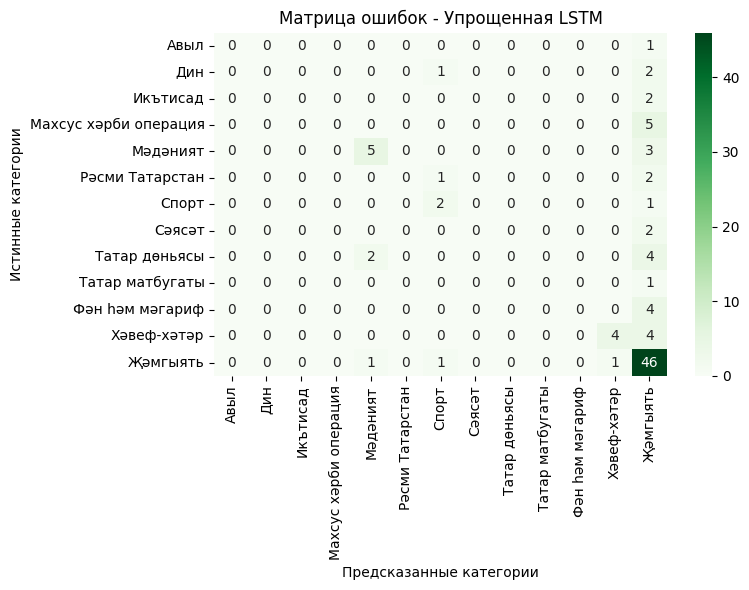


🧪 ТЕСТОВЫЕ ПРЕДСКАЗАНИЯ:

📝 Текст: 'Новый технологический стартап привлек миллионы инвестиций'
🎯 Основное предсказание: Җәмгыять
🔮 Уверенность: 91.12%
🏆 Топ предсказания:
   Җәмгыять: 91.12%
   Махсус хәрби операция: 2.01%
   Мәдәният: 1.74%

📝 Текст: 'Политические переговоры на высшем уровне'
🎯 Основное предсказание: Җәмгыять
🔮 Уверенность: 89.08%
🏆 Топ предсказания:
   Җәмгыять: 89.08%
   Татар дөньясы: 3.33%
   Фән һәм мәгариф: 2.35%

📝 Текст: 'Спортивные достижения на международных соревнованиях'
🎯 Основное предсказание: Спорт
🔮 Уверенность: 91.68%
🏆 Топ предсказания:
   Спорт: 91.68%
   Җәмгыять: 5.19%
   Фән һәм мәгариф: 1.48%

🎯 ВАРИАНТ 2: ПОЛНАЯ LSTM АРХИТЕКТУРА
📱 Используемое устройство: cuda
🎯 НАЧИНАЕМ ОБУЧЕНИЕ LSTM ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...
🎯 Обнаружено классов: 13
🎯 Классы: ['Авыл', 'Дин', 'Икътисад', 'Махсус хәрби операция', 'Мәдәният', 'Рәсми Татарстан', 'Спорт', 'Сәясәт', 'Татар дөньясы', 'Татар матбугаты', 'Фән һәм мәгариф', 'Хәвеф-хәтәр', 'Җәмгыять']

📊 РАСП

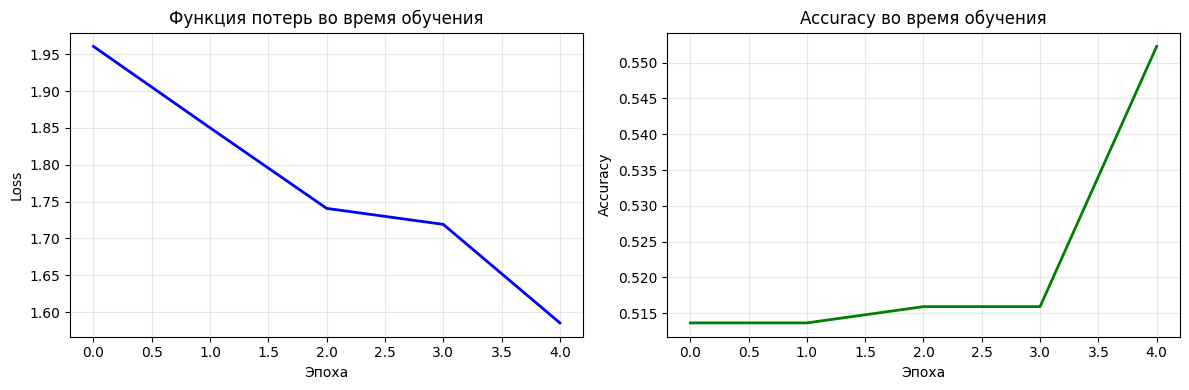

📈 Графики обучения сохранены как: lstm_training_curves.png

🧪 ОЦЕНКА ПОЛНОЙ LSTM:

📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ:
   Махсус хәрби операция: 5 примеров (5.3%)
   Татар дөньясы: 6 примеров (6.3%)
   Җәмгыять: 49 примеров (51.6%)
   Хәвеф-хәтәр: 8 примеров (8.4%)
   Мәдәният: 8 примеров (8.4%)
   Спорт: 3 примеров (3.2%)
   Икътисад: 2 примеров (2.1%)
   Сәясәт: 2 примеров (2.1%)
   Татар матбугаты: 1 примеров (1.1%)
   Рәсми Татарстан: 3 примеров (3.2%)
   Дин: 3 примеров (3.2%)
   Фән һәм мәгариф: 4 примеров (4.2%)
   Авыл: 1 примеров (1.1%)

📊 ОЦЕНКА LSTM НА ТЕСТОВОЙ ВЫБОРКЕ

📊 МЕТРИКИ ДЛЯ ТЕСТОВАЯ ВЫБОРКА:
   Количество примеров: 95

🎯 Accuracy: 0.5263

📈 Classification Report:
                       precision    recall  f1-score   support

                 Авыл     0.0000    0.0000    0.0000         1
                  Дин     0.0000    0.0000    0.0000         3
             Икътисад     0.0000    0.0000    0.0000         2
Махсус хәрби операция     0.0000    0.0000    0.0000         5
  

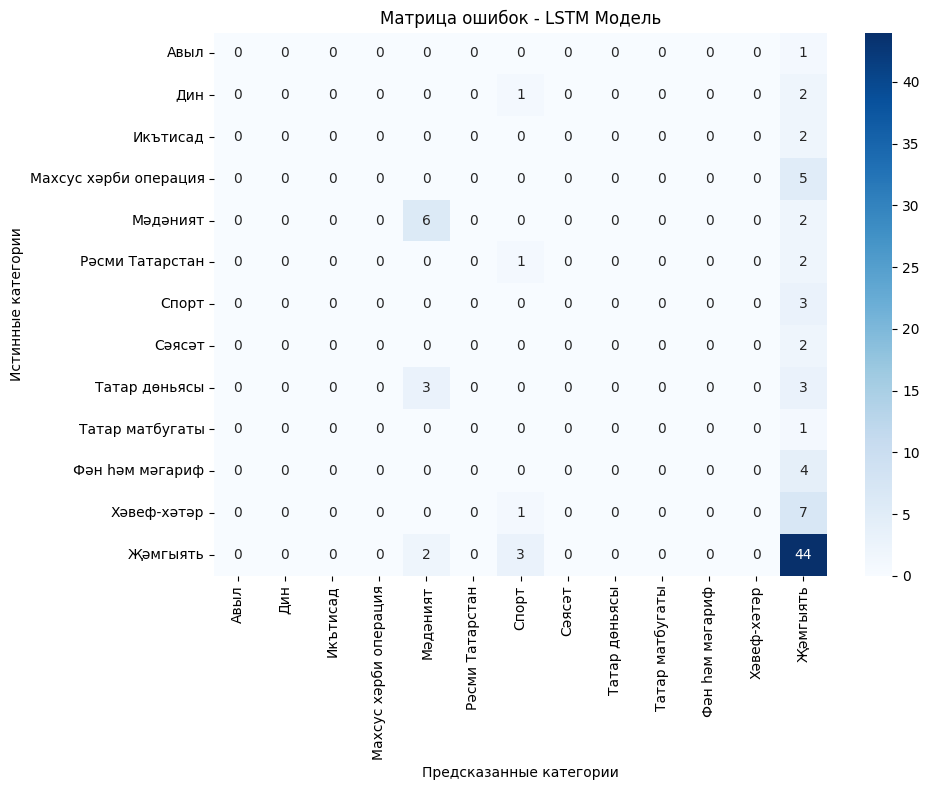


📈 Матрица ошибок сохранена как: lstm_confusion_matrix.png

📊 АНАЛИЗ МАТРИЦЫ ОШИБОК:
   Класс 'Авыл': 0/1 (0.0%) правильно
   Класс 'Дин': 0/3 (0.0%) правильно
   Класс 'Икътисад': 0/2 (0.0%) правильно
   Класс 'Махсус хәрби операция': 0/5 (0.0%) правильно
   Класс 'Мәдәният': 6/8 (75.0%) правильно
   Класс 'Рәсми Татарстан': 0/3 (0.0%) правильно
   Класс 'Спорт': 0/3 (0.0%) правильно
   Класс 'Сәясәт': 0/2 (0.0%) правильно
   Класс 'Татар дөньясы': 0/6 (0.0%) правильно
   Класс 'Татар матбугаты': 0/1 (0.0%) правильно
   Класс 'Фән һәм мәгариф': 0/4 (0.0%) правильно
   Класс 'Хәвеф-хәтәр': 0/8 (0.0%) правильно
   Класс 'Җәмгыять': 44/49 (89.8%) правильно

💾 LSTM модель сохранена: multiclass_lstm_model.pth

🧪 ТЕСТ ЗАГРУЗКИ МОДЕЛИ:
📱 Используемое устройство: cuda
📥 LSTM модель загружена: multiclass_lstm_model.pth
🎯 Количество классов: 13
🎯 Классы: ['Авыл', 'Дин', 'Икътисад', 'Махсус хәрби операция', 'Мәдәният', 'Рәсми Татарстан', 'Спорт', 'Сәясәт', 'Татар дөньясы', 'Татар матбугаты', 'Фә

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


class TextLSTM(nn.Module):
    """
    LSTM модель для многоклассовой классификации текста
    """
    def __init__(self, embedding_dim=384, hidden_dim=256, num_layers=2,
                 num_classes=5, dropout=0.5, bidirectional=True):
        super(TextLSTM, self).__init__()

        # Параметры LSTM
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_classes = num_classes

        # LSTM слой
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True
        )

        # Определяем размер выхода LSTM
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        # Полносвязные слои для классификации
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        """
        x: [batch_size, seq_len, embedding_dim]
        """
        batch_size = x.size(0)

        # Инициализируем скрытые состояния
        device = x.device
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1),
                        batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1),
                        batch_size, self.hidden_dim).to(device)

        # Прямой проход через LSTM
        lstm_out, (hidden, cell) = self.lstm(x, (h0, c0))

        # Для бидирекционального LSTM берем последние скрытые состояния обоих направлений
        if self.bidirectional:
            # hidden: [num_layers * 2, batch_size, hidden_dim]
            hidden = hidden.view(self.num_layers, 2, batch_size, self.hidden_dim)
            # Берем последний слой
            hidden_last_layer = hidden[-1]
            # Объединяем forward и backward
            hidden_concat = torch.cat((hidden_last_layer[0], hidden_last_layer[1]), dim=1)
        else:
            # hidden: [num_layers, batch_size, hidden_dim]
            hidden_concat = hidden[-1]

        # Полносвязные слои
        output = self.fc(hidden_concat)

        return output


class LSTMClassifier:
    """
    LSTM классификатор для многоклассовой классификации категорий
    """

    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
                 max_seq_len=100, batch_size=16):
        """
        Args:
            embedding_model: модель для эмбеддингов
            max_seq_len: максимальная длина последовательности
            batch_size: размер батча
        """
        # Проверяем доступность CUDA
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")

        # Загружаем модель эмбеддингов
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_model_name = embedding_model
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # Параметры
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size

        # Инициализируем позже, после определения классов
        self.model = None
        self.classes = None
        self.num_classes = None
        self.category_to_idx = None

        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных из списка словарей для многоклассовой классификации
        """
        texts = []
        categories = []

        for item in data:
            if isinstance(item, dict):
                texts.append(item.get('text', ''))
                categories.append(item.get('category', ''))

        # Определяем уникальные категории
        if not hasattr(self, 'classes') or self.classes is None:
            self.classes = sorted(list(set(categories)))
            self.num_classes = len(self.classes)
            print(f"🎯 Обнаружено классов: {self.num_classes}")
            print(f"🎯 Классы: {self.classes}")

        # Преобразуем категории в числовые индексы
        self.category_to_idx = {cat: idx for idx, cat in enumerate(self.classes)}
        labels = np.array([self.category_to_idx[cat] for cat in categories])

        # Выводим распределение классов
        print("\n📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ:")
        counter = Counter(categories)
        for cat, count in counter.items():
            print(f"   {cat}: {count} примеров ({count/len(categories)*100:.1f}%)")

        return texts, labels

    def create_embeddings_sequence(self, texts):
        """
        Создание последовательности эмбеддингов для LSTM
        """
        embeddings_list = []

        for text in texts:
            # Получаем эмбеддинг предложения
            sentence_embedding = self.embedder.encode(text, show_progress_bar=False)

            # Создаем последовательность, повторяя эмбеддинг
            sequence = np.tile(sentence_embedding, (self.max_seq_len, 1))

            # Обрезаем до нужной длины
            if sequence.shape[0] > self.max_seq_len:
                sequence = sequence[:self.max_seq_len, :]
            elif sequence.shape[0] < self.max_seq_len:
                # Дополняем нулями
                pad_len = self.max_seq_len - sequence.shape[0]
                padding = np.zeros((pad_len, self.embedding_dim))
                sequence = np.vstack([sequence, padding])

            embeddings_list.append(sequence)

        return np.array(embeddings_list)

    def train(self, train_data, epochs=10, lr=0.001):
        """
        Обучение LSTM модели для многоклассовой классификации
        """
        print("🎯 НАЧИНАЕМ ОБУЧЕНИЕ LSTM ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...")

        # Подготовка данных
        texts, labels = self.prepare_data(train_data)

        if len(texts) == 0:
            print("❌ Нет данных для обучения")
            return

        print(f"📊 Загружено {len(texts)} примеров")
        print(f"📊 Размерность эмбеддингов: {self.embedding_dim}")
        print(f"📊 Максимальная длина последовательности: {self.max_seq_len}")

        # Инициализируем модель, если еще не инициализирована
        if self.model is None:
            self.model = TextLSTM(
                embedding_dim=self.embedding_dim,
                hidden_dim=256,
                num_layers=2,
                num_classes=self.num_classes,
                dropout=0.3,
                bidirectional=True
            ).to(self.device)

        # Создаем последовательности эмбеддингов
        print("🔍 Создание последовательностей эмбеддингов...")
        X_sequences = self.create_embeddings_sequence(texts)

        # Преобразуем в тензоры
        X_tensor = torch.FloatTensor(X_sequences).to(self.device)
        y_tensor = torch.LongTensor(labels).to(self.device)

        print(f"📊 Размерность данных: {X_tensor.shape}")

        # Оптимизатор и функция потерь
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        train_losses = []
        train_accuracies = []

        for epoch in range(epochs):
            total_loss = 0
            indices = torch.randperm(len(X_tensor))
            num_batches = max(1, len(indices) // self.batch_size)

            for i in range(0, len(indices), self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                batch_X = X_tensor[batch_indices]
                batch_y = y_tensor[batch_indices]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Gradient clipping для стабильности LSTM
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                total_loss += loss.item()

            # Вычисляем accuracy
            with torch.no_grad():
                self.model.eval()
                outputs = self.model(X_tensor)
                _, preds = torch.max(outputs, 1)
                accuracy = (preds == y_tensor).float().mean().item()
                self.model.train()

            avg_loss = total_loss / num_batches
            train_losses.append(avg_loss)
            train_accuracies.append(accuracy)

            print(f"📈 Эпоха {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.3f}")

        self.is_trained = True

        # Финальная оценка
        print("\n✅ ОБУЧЕНИЕ LSTM ЗАВЕРШЕНО")

        # Метрики на обучающих данных
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, preds = torch.max(outputs, 1)
            probabilities = F.softmax(outputs, dim=1)

        self._print_metrics(labels, preds.cpu().numpy(), probabilities.cpu().numpy(), "ОБУЧАЮЩАЯ ВЫБОРКА")

        # Визуализация обучения
        self._plot_training_curves(train_losses, train_accuracies)

        return train_losses, train_accuracies

    def predict(self, texts):
        """
        Предсказание для списка текстов
        """
        if not self.is_trained:
            raise ValueError("❌ Модель не обучена!")

        # Создаем последовательности
        sequences = self.create_embeddings_sequence(texts)

        # Преобразуем в тензор
        X_tensor = torch.FloatTensor(sequences).to(self.device)

        # Предсказание
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs, 1)

        # Преобразуем индексы обратно в категории
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        predicted_categories = [idx_to_category[idx] for idx in predictions.cpu().numpy()]

        return predicted_categories, predictions.cpu().numpy(), probabilities.cpu().numpy()

    def predict_single(self, text):
        """
        Предсказание для одного текста
        """
        categories, preds, probs = self.predict([text])

        # Получаем топ-3 предсказания
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        top3_indices = probs[0].argsort()[-3:][::-1]

        top_predictions = []
        for idx in top3_indices:
            top_predictions.append({
                'category': idx_to_category[idx],
                'probability': float(probs[0][idx])
            })

        return {
            'prediction': categories[0],
            'confidence': float(max(probs[0])),
            'all_probabilities': {idx_to_category[i]: float(prob) for i, prob in enumerate(probs[0])},
            'top_predictions': top_predictions
        }

    def evaluate(self, test_data):
        """
        Полная оценка модели
        """
        texts, true_labels = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return None

        # Предсказание
        predicted_categories, predictions, probabilities = self.predict(texts)

        print("\n" + "="*60)
        print("📊 ОЦЕНКА LSTM НА ТЕСТОВОЙ ВЫБОРКЕ")
        print("="*60)

        # Все метрики
        self._print_metrics(true_labels, predictions, probabilities, "ТЕСТОВАЯ ВЫБОРКА")

        # Матрица ошибок с именами классов
        self._plot_confusion_matrix(true_labels, predictions)

        return {
            'accuracy': accuracy_score(true_labels, predictions),
            'predictions': predictions,
            'predicted_categories': predicted_categories,
            'probabilities': probabilities
        }

    def _print_metrics(self, y_true, y_pred, y_proba=None, dataset_name=""):
        """
        Вывод всех метрик для многоклассовой классификации
        """
        print(f"\n📊 МЕТРИКИ ДЛЯ {dataset_name}:")
        print(f"   Количество примеров: {len(y_true)}")

        # Accuracy
        acc = accuracy_score(y_true, y_pred)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report с именами классов
        print("\n📈 Classification Report:")
        target_names = [str(cls) for cls in self.classes]
        print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

        # Macro и Weighted средние
        print(f"\n📊 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"   Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"   F1-Score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")

        # ROC-AUC для многоклассовой (если не слишком много классов)
        if y_proba is not None and self.num_classes <= 10:
            try:
                # Бинаризируем метки для многоклассового ROC-AUC
                y_true_bin = label_binarize(y_true, classes=range(self.num_classes))

                # Вычисляем ROC-AUC для каждого класса
                roc_auc_scores = []
                for i in range(self.num_classes):
                    if len(np.unique(y_true_bin[:, i])) > 1:  # Проверяем, есть ли положительные примеры
                        auc = roc_auc_score(y_true_bin[:, i], y_proba[:, i])
                        roc_auc_scores.append(auc)
                        print(f"   ROC-AUC для класса '{self.classes[i]}': {auc:.4f}")

                if roc_auc_scores:
                    print(f"   ROC-AUC (macro avg): {np.mean(roc_auc_scores):.4f}")
            except Exception as e:
                print(f"   ⚠️ ROC-AUC calculation skipped: {e}")

    def _plot_confusion_matrix(self, y_true, y_pred):
        """
        Построение матрицы ошибок с именами классов
        """
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.classes,
                   yticklabels=self.classes)

        plt.title('Матрица ошибок - LSTM Модель')
        plt.ylabel('Истинные категории')
        plt.xlabel('Предсказанные категории')
        plt.tight_layout()

        plt.savefig('lstm_confusion_matrix.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n📈 Матрица ошибок сохранена как: lstm_confusion_matrix.png")

        # Детальный анализ матрицы ошибок
        print("\n📊 АНАЛИЗ МАТРИЦЫ ОШИБОК:")
        for i, true_class in enumerate(self.classes):
            total_true = cm[i].sum()
            correct = cm[i, i]
            accuracy_per_class = correct / total_true if total_true > 0 else 0
            print(f"   Класс '{true_class}': {correct}/{total_true} ({accuracy_per_class:.1%}) правильно")

    def _plot_training_curves(self, losses, accuracies):
        """
        Построение графиков обучения
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # График потерь
        ax1.plot(losses, 'b-', linewidth=2)
        ax1.set_xlabel('Эпоха')
        ax1.set_ylabel('Loss')
        ax1.set_title('Функция потерь во время обучения')
        ax1.grid(True, alpha=0.3)

        # График accuracy
        ax2.plot(accuracies, 'g-', linewidth=2)
        ax2.set_xlabel('Эпоха')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy во время обучения')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('lstm_training_curves.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"📈 Графики обучения сохранены как: lstm_training_curves.png")

    def save(self, filename):
        """
        Сохранение модели
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'embedding_model': self.embedding_model_name,
            'embedding_dim': self.embedding_dim,
            'max_seq_len': self.max_seq_len,
            'classes': self.classes,
            'num_classes': self.num_classes,
            'category_to_idx': self.category_to_idx,
            'is_trained': self.is_trained
        }, filename)
        print(f"\n💾 LSTM модель сохранена: {filename}")

    def load(self, filename):
        """
        Загрузка модели
        """
        checkpoint = torch.load(filename, map_location=self.device)

        # Восстанавливаем классы
        self.classes = checkpoint['classes']
        self.num_classes = checkpoint['num_classes']
        self.category_to_idx = checkpoint['category_to_idx']

        # Инициализируем модель
        self.model = TextLSTM(
            embedding_dim=checkpoint['embedding_dim'],
            hidden_dim=256,
            num_layers=2,
            num_classes=self.num_classes,
            dropout=0.3,
            bidirectional=True
        ).to(self.device)

        # Загружаем веса
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

        self.embedding_model_name = checkpoint['embedding_model']
        self.embedding_dim = checkpoint['embedding_dim']
        self.max_seq_len = checkpoint['max_seq_len']
        self.is_trained = checkpoint['is_trained']

        print(f"📥 LSTM модель загружена: {filename}")
        print(f"🎯 Количество классов: {self.num_classes}")
        print(f"🎯 Классы: {self.classes}")


# УПРОЩЕННАЯ LSTM ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ
class SimpleTextLSTM(nn.Module):
    """
    Упрощенная LSTM модель для многоклассовой классификации
    """
    def __init__(self, embedding_dim=384, hidden_dim=128, num_classes=5):
        super(SimpleTextLSTM, self).__init__()

        # LSTM слой
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
            dropout=0.3
        )

        # Классификатор
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, 64),  # *2 для bidirectional
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # LSTM forward
        lstm_out, (hidden, cell) = self.lstm(x)

        # Берем последний выход
        last_output = lstm_out[:, -1, :]

        # Классификация
        output = self.classifier(last_output)

        return output


class SimpleLSTMClassifier:
    """
    Обертка для упрощенной LSTM многоклассовой классификации
    """
    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2'):
        # Устройство
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")

        # Модель для эмбеддингов
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # Инициализируем позже
        self.model = None
        self.classes = None
        self.num_classes = None
        self.category_to_idx = None

        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных для многоклассовой классификации
        """
        texts = []
        categories = []

        for item in data:
            if isinstance(item, dict):
                texts.append(item.get('text', ''))
                categories.append(item.get('category', ''))

        # Определяем уникальные категории
        if not hasattr(self, 'classes') or self.classes is None:
            self.classes = sorted(list(set(categories)))
            self.num_classes = len(self.classes)
            print(f"🎯 Обнаружено классов: {self.num_classes}")
            print(f"🎯 Классы: {self.classes}")

        # Преобразуем категории в индексы
        self.category_to_idx = {cat: idx for idx, cat in enumerate(self.classes)}
        labels = np.array([self.category_to_idx[cat] for cat in categories])

        return texts, labels

    def create_input_tensor(self, texts, seq_len=50):
        """
        Создание входного тензора для LSTM
        """
        embeddings = []

        for text in texts:
            # Получаем эмбеддинг текста
            emb = self.embedder.encode(text, show_progress_bar=False)

            # Создаем последовательность
            seq = np.tile(emb, (seq_len, 1))

            # Обрезаем до нужной длины
            if seq.shape[0] > seq_len:
                seq = seq[:seq_len]
            elif seq.shape[0] < seq_len:
                # Дополняем нулями
                pad_len = seq_len - seq.shape[0]
                padding = np.zeros((pad_len, self.embedding_dim))
                seq = np.vstack([seq, padding])

            embeddings.append(seq)

        # Преобразуем в тензор
        tensor = torch.FloatTensor(np.array(embeddings)).to(self.device)

        return tensor

    def train(self, train_data, epochs=10, lr=0.001):
        """
        Обучение модели для многоклассовой классификации
        """
        print("🎯 ОБУЧЕНИЕ УПРОЩЕННОЙ LSTM ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...")

        # Подготовка данных
        texts, labels = self.prepare_data(train_data)

        if len(texts) == 0:
            print("❌ Нет данных для обучения")
            return self

        print(f"📊 Примеров: {len(texts)}")

        # Инициализируем модель, если еще не инициализирована
        if self.model is None:
            self.model = SimpleTextLSTM(
                embedding_dim=self.embedding_dim,
                hidden_dim=128,
                num_classes=self.num_classes
            ).to(self.device)

        # Создаем тензоры
        X = self.create_input_tensor(texts, seq_len=50)
        y = torch.LongTensor(labels).to(self.device)

        # Оптимизатор и функция потерь
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        for epoch in range(epochs):
            # Перемешиваем данные
            indices = torch.randperm(len(X))
            total_loss = 0
            num_batches = max(1, len(indices) // 8)

            for i in range(0, len(indices), 8):
                batch_idx = indices[i:i+8]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                total_loss += loss.item()

            # Оценка accuracy
            with torch.no_grad():
                self.model.eval()
                outputs = self.model(X)
                _, preds = torch.max(outputs, 1)
                accuracy = (preds == y).float().mean().item()
                self.model.train()

            avg_loss = total_loss / num_batches

            print(f"📈 Эпоха {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.3f}")

        self.is_trained = True
        print("\n✅ ОБУЧЕНИЕ ЗАВЕРШЕНО")

        return self

    def predict(self, texts):
        """
        Предсказание для многоклассовой классификации
        """
        if not self.is_trained:
            raise ValueError("❌ Модель не обучена!")

        self.model.eval()
        X = self.create_input_tensor(texts, seq_len=50)

        with torch.no_grad():
            outputs = self.model(X)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, 1)

        # Преобразуем индексы в категории
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        predicted_categories = [idx_to_category[idx] for idx in preds.cpu().numpy()]

        return predicted_categories, preds.cpu().numpy(), probs.cpu().numpy()

    def evaluate(self, test_data):
        """
        Оценка с метриками для многоклассовой классификации
        """
        texts, true_labels = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return None, None, None

        predicted_categories, predictions, probabilities = self.predict(texts)

        print("\n" + "="*60)
        print("📊 МЕТРИКИ УПРОЩЕННОЙ LSTM (Многоклассовая)")
        print("="*60)

        # Accuracy
        acc = accuracy_score(true_labels, predictions)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report
        target_names = [str(cls) for cls in self.classes]
        print("\n📈 Classification Report:")
        print(classification_report(true_labels, predictions, target_names=target_names, digits=4))

        # Дополнительные метрики
        print(f"\n📊 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(true_labels, predictions, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(true_labels, predictions, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(true_labels, predictions, average='macro'):.4f}")
        print(f"   Precision (weighted): {precision_score(true_labels, predictions, average='weighted'):.4f}")
        print(f"   Recall (weighted): {recall_score(true_labels, predictions, average='weighted'):.4f}")
        print(f"   F1-Score (weighted): {f1_score(true_labels, predictions, average='weighted'):.4f}")

        # Матрица ошибок
        cm = confusion_matrix(true_labels, predictions)
        print(f"\n📊 МАТРИЦА ОШИБОК:")

        # Красиво отображаем матрицу ошибок
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                   xticklabels=self.classes,
                   yticklabels=self.classes)
        plt.title('Матрица ошибок - Упрощенная LSTM')
        plt.ylabel('Истинные категории')
        plt.xlabel('Предсказанные категории')
        plt.tight_layout()
        plt.show()

        return predicted_categories, predictions, probabilities

    def predict_single(self, text):
        """
        Предсказание для одного текста
        """
        categories, preds, probs = self.predict([text])

        # Получаем топ-3 предсказания
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        top3_indices = probs[0].argsort()[-3:][::-1]

        top_predictions = []
        for idx in top3_indices:
            top_predictions.append({
                'category': idx_to_category[idx],
                'probability': float(probs[0][idx])
            })

        return {
            'prediction': categories[0],
            'confidence': float(max(probs[0])),
            'top_predictions': top_predictions
        }

    def save(self, filename):
        """
        Сохранение модели
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'embedding_dim': self.embedding_dim,
            'classes': self.classes,
            'num_classes': self.num_classes,
            'category_to_idx': self.category_to_idx,
            'is_trained': self.is_trained
        }, filename)
        print(f"💾 Модель сохранена: {filename}")

    def load(self, filename):
        """
        Загрузка модели
        """
        checkpoint = torch.load(filename, map_location=self.device)

        # Восстанавливаем классы
        self.classes = checkpoint['classes']
        self.num_classes = checkpoint['num_classes']
        self.category_to_idx = checkpoint['category_to_idx']

        # Инициализируем модель
        self.model = SimpleTextLSTM(
            embedding_dim=checkpoint['embedding_dim'],
            hidden_dim=128,
            num_classes=self.num_classes
        ).to(self.device)

        # Загружаем веса
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.is_trained = checkpoint['is_trained']

        print(f"📥 Модель загружена: {filename}")
        print(f"🎯 Количество классов: {self.num_classes}")


# ПРИМЕР ИСПОЛЬЗОВАНИЯ С МНОГОКЛАССОВОЙ КЛАССИФИКАЦИЕЙ
def main():
    """
    Пример использования LSTM для многоклассовой классификации
    """
    import json

    def load_jsonl(filepath):
        """Загрузка данных из JSONL файла"""
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                return [json.loads(line) for line in f]
        except FileNotFoundError:
            print(f"⚠️ Файл {filepath} не найден")
            return []

    print("📂 ЗАГРУЗКА ДАННЫХ ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...")

    # Загружаем данные (предполагается поле 'category')
    train_data = load_jsonl('/content/news_category_train.jsonl')
    test_data = load_jsonl('/content/news_category_test.jsonl')

    print(f"📊 Обучающих примеров: {len(train_data)}")
    print(f"📊 Тестовых примеров: {len(test_data)}")

    # Проверяем структуру данных
    if len(train_data) > 0:
        sample = train_data[0]
        print(f"\n📝 Пример записи: {sample}")

    # Вариант 1: Упрощенная LSTM (рекомендуется для начала)
    print("\n" + "="*60)
    print("🎯 ВАРИАНТ 1: УПРОЩЕННАЯ LSTM")
    print("="*60)

    simple_lstm = SimpleLSTMClassifier(
        embedding_model='paraphrase-multilingual-MiniLM-L12-v2'
    )

    # Обучаем на демо-данных
    simple_lstm.train(train_data, epochs=8, lr=0.001)

    if simple_lstm.is_trained and test_data:
        print("\n🧪 ОЦЕНКА УПРОЩЕННОЙ LSTM:")
        pred_cats, preds, probs = simple_lstm.evaluate(test_data)

        # Тестируем на отдельных примерах
        print("\n🧪 ТЕСТОВЫЕ ПРЕДСКАЗАНИЯ:")
        test_examples = [
            "Новый технологический стартап привлек миллионы инвестиций",
            "Политические переговоры на высшем уровне",
            "Спортивные достижения на международных соревнованиях"
        ]

        for text in test_examples:
            try:
                result = simple_lstm.predict_single(text)
                print(f"\n📝 Текст: '{text}'")
                print(f"🎯 Основное предсказание: {result['prediction']}")
                print(f"🔮 Уверенность: {result['confidence']:.2%}")
                if 'top_predictions' in result:
                    print("🏆 Топ предсказания:")
                    for pred in result['top_predictions']:
                        print(f"   {pred['category']}: {pred['probability']:.2%}")
            except Exception as e:
                print(f"⚠️ Ошибка при предсказании: {e}")

    # Вариант 2: Полная LSTM архитектура
    print("\n" + "="*60)
    print("🎯 ВАРИАНТ 2: ПОЛНАЯ LSTM АРХИТЕКТУРА")
    print("="*60)

    try:
        full_lstm = LSTMClassifier(
            embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
            max_seq_len=50,
            batch_size=8
        )

        # Обучаем полную модель
        losses, accuracies = full_lstm.train(train_data, epochs=5, lr=0.001)

        if full_lstm.is_trained and test_data:
            print("\n🧪 ОЦЕНКА ПОЛНОЙ LSTM:")
            results = full_lstm.evaluate(test_data)

            # Сохранение модели
            full_lstm.save('multiclass_lstm_model.pth')

            # Тестируем загрузку модели
            print("\n🧪 ТЕСТ ЗАГРУЗКИ МОДЕЛИ:")
            new_model = LSTMClassifier()
            new_model.load('multiclass_lstm_model.pth')

            # Тестируем загруженную модель
            test_text = "Инновации в области искусственного интеллекта"
            result = new_model.predict_single(test_text)
            print(f"\n📝 Текст: '{test_text}'")
            print(f"🎯 Предсказание: {result['prediction']}")
            print(f"🔮 Уверенность: {result['confidence']:.2%}")
            if 'top_predictions' in result:
                print("🏆 Топ-3 предсказания:")
                for pred in result['top_predictions']:
                    print(f"   {pred['category']}: {pred['probability']:.2%}")

    except Exception as e:
        print(f"⚠️ Ошибка в полной LSTM: {e}")
        import traceback
        traceback.print_exc()

    print("\n" + "="*60)
    print("✅ ЗАВЕРШЕНО")
    print("="*60)


if __name__ == "__main__":
    # Проверяем зависимости
    print(f"PyTorch версия: {torch.__version__}")
    print(f"CUDA доступен: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA устройство: {torch.cuda.get_device_name(0)}")

    # Проверяем наличие sentence_transformers
    try:
        from sentence_transformers import SentenceTransformer
        print(f"Sentence Transformers доступен")
    except ImportError:
        print("❌ Sentence Transformers не установлен!")
        print("Установите: pip install sentence-transformers")
        exit(1)

    # Запускаем
    try:
        main()
    except KeyboardInterrupt:
        print("\n\n⏹️ Прервано пользователем")
    except Exception as e:
        print(f"\n❌ Критическая ошибка: {e}")
        import traceback
        traceback.print_exc()

PyTorch версия: 2.9.0+cu126
CUDA доступен: True
CUDA устройство: Tesla T4

🎯 ПРЕИМУЩЕСТВА BiLSTM ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ

📈 Понимание контекста в обоих направлениях:
   Анализирует текст слева-направо и справа-налево, что важно для определения категорий

🎯 Лучшее распознавание сложных текстов:
   Справляется с текстами, которые содержат элементы нескольких категорий

🔍 Механизм внимания для многоклассовой задачи:
   Автоматически определяет ключевые части текста для каждой категории

💡 Учет дальних зависимостей:
   Помнит начало текста при анализе конца, что важно для длинных статей

📊 Высокая точность на смешанных категориях:
   Лучше справляется с текстами на стыке категорий (технологии/бизнес, спорт/политика)

--------------------------------------------------------------------------------
📊 КОГДА ИСПОЛЬЗОВАТЬ BiLSTM ДЛЯ КЛАССИФИКАЦИИ КАТЕГОРИЙ:
   - Новостные статьи со сложной структурой
   - Тексты, содержащие элементы нескольких категорий
   - Когда важен контекст и поря

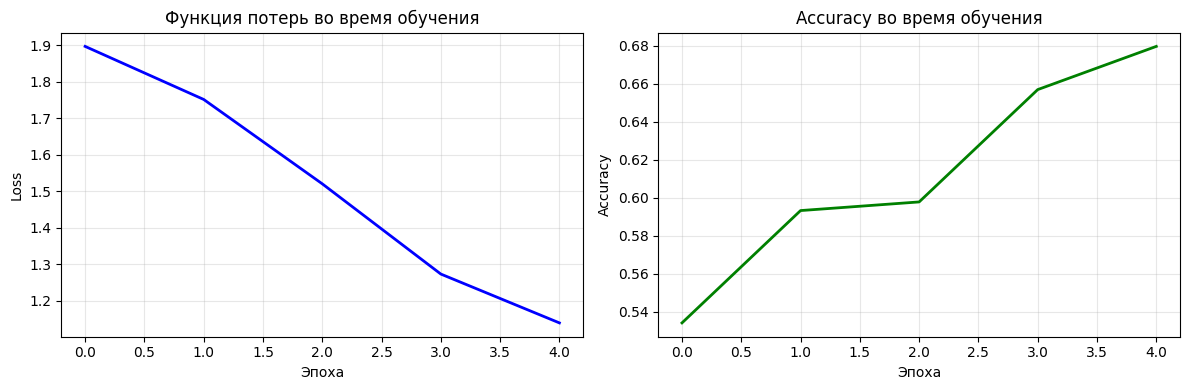

📈 Графики обучения сохранены как: bilstm_training_curves.png

🧪 ОЦЕНКА ПОЛНОЙ BiLSTM:

📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ:
   Махсус хәрби операция: 5 примеров (5.3%)
   Татар дөньясы: 6 примеров (6.3%)
   Җәмгыять: 49 примеров (51.6%)
   Хәвеф-хәтәр: 8 примеров (8.4%)
   Мәдәният: 8 примеров (8.4%)
   Спорт: 3 примеров (3.2%)
   Икътисад: 2 примеров (2.1%)
   Сәясәт: 2 примеров (2.1%)
   Татар матбугаты: 1 примеров (1.1%)
   Рәсми Татарстан: 3 примеров (3.2%)
   Дин: 3 примеров (3.2%)
   Фән һәм мәгариф: 4 примеров (4.2%)
   Авыл: 1 примеров (1.1%)

📊 ОЦЕНКА BiLSTM НА ТЕСТОВОЙ ВЫБОРКЕ

📊 МЕТРИКИ ДЛЯ ТЕСТОВАЯ ВЫБОРКА:
   Количество примеров: 95

🎯 Accuracy: 0.6211

📈 Classification Report:
                       precision    recall  f1-score   support

                 Авыл     0.0000    0.0000    0.0000         1
                  Дин     1.0000    0.3333    0.5000         3
             Икътисад     0.0000    0.0000    0.0000         2
Махсус хәрби операция     1.0000    0.2000    0.3333       

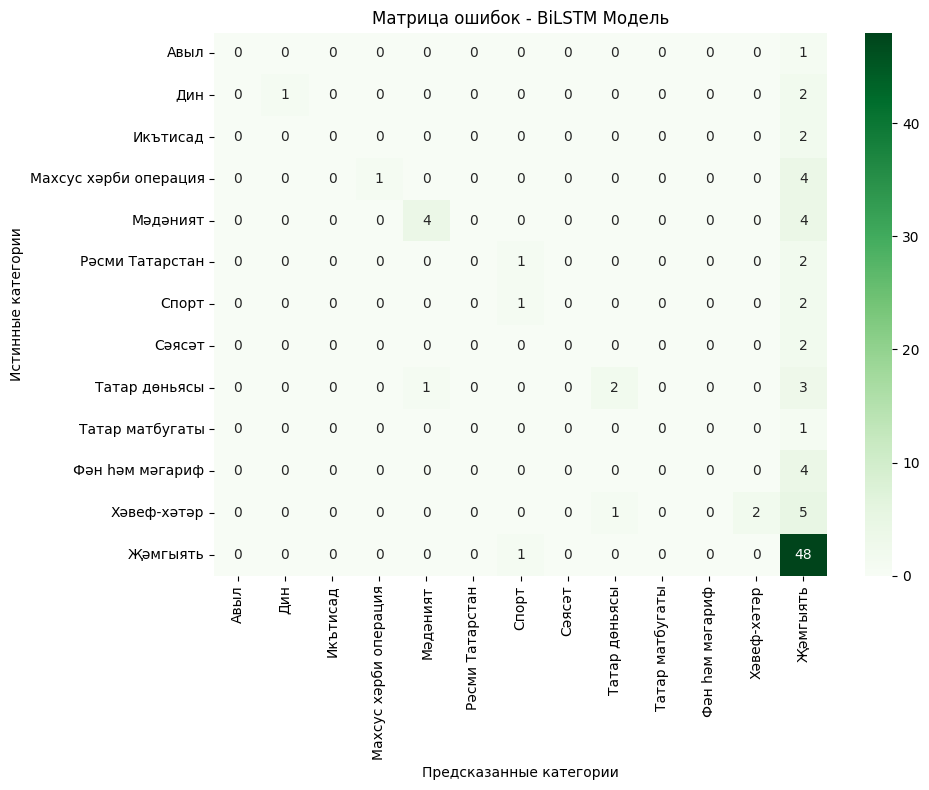


📈 Матрица ошибок сохранена как: bilstm_confusion_matrix.png

📊 АНАЛИЗ МАТРИЦЫ ОШИБОК:
   Класс 'Авыл': 0/1 (0.0%) правильно
   Класс 'Дин': 1/3 (33.3%) правильно
   Класс 'Икътисад': 0/2 (0.0%) правильно
   Класс 'Махсус хәрби операция': 1/5 (20.0%) правильно
   Класс 'Мәдәният': 4/8 (50.0%) правильно
   Класс 'Рәсми Татарстан': 0/3 (0.0%) правильно
   Класс 'Спорт': 1/3 (33.3%) правильно
   Класс 'Сәясәт': 0/2 (0.0%) правильно
   Класс 'Татар дөньясы': 2/6 (33.3%) правильно
   Класс 'Татар матбугаты': 0/1 (0.0%) правильно
   Класс 'Фән һәм мәгариф': 0/4 (0.0%) правильно
   Класс 'Хәвеф-хәтәр': 2/8 (25.0%) правильно
   Класс 'Җәмгыять': 48/49 (98.0%) правильно

💾 BiLSTM модель сохранена: multiclass_bilstm_model.pth

🧪 ТЕСТ ЗАГРУЗКИ МОДЕЛИ:
📱 Используемое устройство: cuda
📥 BiLSTM модель загружена: multiclass_bilstm_model.pth
🎯 Количество классов: 13
🎯 Классы: ['Авыл', 'Дин', 'Икътисад', 'Махсус хәрби операция', 'Мәдәният', 'Рәсми Татарстан', 'Спорт', 'Сәясәт', 'Татар дөньясы', 'Татар 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


class BiLSTMClassifier(nn.Module):
    """
    Бидирекциональная LSTM модель для многоклассовой классификации текста
    """
    def __init__(self, embedding_dim=384, hidden_dim=256, num_layers=2,
                 num_classes=5, dropout=0.5, use_attention=True):
        super(BiLSTMClassifier, self).__init__()

        # Параметры
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.use_attention = use_attention
        self.num_classes = num_classes

        # Бидирекциональная LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True,
            batch_first=True
        )

        # Размер выхода LSTM (в 2 раза больше из-за bidirectional)
        lstm_output_dim = hidden_dim * 2

        # Механизм внимания (рекомендуется для многоклассовой классификации)
        if use_attention:
            self.attention = nn.Sequential(
                nn.Linear(lstm_output_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, 1)
            )

        # Полносвязные слои для многоклассовой классификации
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, num_classes)
        )

        # Дополнительная нормализация
        self.layer_norm = nn.LayerNorm(lstm_output_dim)

    def forward(self, x):
        """
        x: [batch_size, seq_len, embedding_dim]
        """
        batch_size = x.size(0)

        # Инициализируем скрытые состояния
        device = x.device
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim).to(device)

        # Прямой проход через бидирекциональную LSTM
        lstm_out, (hidden, cell) = self.lstm(x, (h0, c0))
        # lstm_out: [batch_size, seq_len, hidden_dim * 2]

        if self.use_attention:
            # Механизм внимания
            attention_weights = self.attention(lstm_out)
            attention_weights = F.softmax(attention_weights, dim=1)

            # Взвешенная сумма
            context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        else:
            # Берем последний скрытый слой обоих направлений
            hidden = hidden.view(self.num_layers, 2, batch_size, self.hidden_dim)
            hidden_last_layer = hidden[-1]

            # Конкатенируем forward и backward
            forward_hidden = hidden_last_layer[0]
            backward_hidden = hidden_last_layer[1]
            context_vector = torch.cat([forward_hidden, backward_hidden], dim=1)

        # Нормализация
        context_vector = self.layer_norm(context_vector)

        # Полносвязные слои для классификации
        output = self.fc(context_vector)

        return output


class BiLSTMTextClassifier:
    """
    Бидирекциональный LSTM классификатор для многоклассовой классификации категорий
    """

    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
                 max_seq_len=100, batch_size=16, use_attention=True):
        """
        Args:
            embedding_model: модель для эмбеддингов
            max_seq_len: максимальная длина последовательности
            batch_size: размер батча
            use_attention: использовать механизм внимания
        """
        # Проверяем доступность CUDA
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")

        # Загружаем модель эмбеддингов
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_model_name = embedding_model
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # Параметры
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.use_attention = use_attention

        # Инициализируем позже
        self.model = None
        self.classes = None
        self.num_classes = None
        self.category_to_idx = None

        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных из списка словарей для многоклассовой классификации
        """
        texts = []
        categories = []

        for item in data:
            if isinstance(item, dict):
                texts.append(item.get('text', ''))
                categories.append(item.get('category', ''))

        # Определяем уникальные категории
        if not hasattr(self, 'classes') or self.classes is None:
            self.classes = sorted(list(set(categories)))
            self.num_classes = len(self.classes)
            print(f"🎯 Обнаружено классов: {self.num_classes}")
            print(f"🎯 Классы: {self.classes}")

        # Преобразуем категории в числовые индексы
        self.category_to_idx = {cat: idx for idx, cat in enumerate(self.classes)}
        labels = np.array([self.category_to_idx[cat] for cat in categories])

        # Выводим распределение классов
        print("\n📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ:")
        counter = Counter(categories)
        for cat, count in counter.items():
            print(f"   {cat}: {count} примеров ({count/len(categories)*100:.1f}%)")

        return texts, labels

    def create_embeddings_sequence(self, texts):
        """
        Создание последовательности эмбеддингов
        """
        embeddings_list = []

        for text in texts:
            # Получаем эмбеддинг предложения
            sentence_embedding = self.embedder.encode(text, show_progress_bar=False)

            # Создаем последовательность, повторяя эмбеддинг
            sequence = np.tile(sentence_embedding, (self.max_seq_len, 1))

            # Обрезаем до нужной длины
            if sequence.shape[0] > self.max_seq_len:
                sequence = sequence[:self.max_seq_len, :]
            elif sequence.shape[0] < self.max_seq_len:
                # Дополняем нулями
                pad_len = self.max_seq_len - sequence.shape[0]
                padding = np.zeros((pad_len, self.embedding_dim))
                sequence = np.vstack([sequence, padding])

            embeddings_list.append(sequence)

        return np.array(embeddings_list)

    def train(self, train_data, epochs=10, lr=0.001):
        """
        Обучение BiLSTM модели для многоклассовой классификации
        """
        print("🎯 НАЧИНАЕМ ОБУЧЕНИЕ BiLSTM ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...")

        # Подготовка данных
        texts, labels = self.prepare_data(train_data)

        if len(texts) == 0:
            print("❌ Нет данных для обучения")
            return

        print(f"📊 Загружено {len(texts)} примеров")
        print(f"📊 Размерность эмбеддингов: {self.embedding_dim}")
        print(f"📊 Максимальная длина последовательности: {self.max_seq_len}")
        print(f"📊 Архитектура: BiLSTM ({self.num_classes} классов)")
        print(f"📊 Механизм внимания: {'Включен' if self.use_attention else 'Выключен'}")

        # Инициализируем модель, если еще не инициализирована
        if self.model is None:
            self.model = BiLSTMClassifier(
                embedding_dim=self.embedding_dim,
                hidden_dim=256,
                num_layers=2,
                num_classes=self.num_classes,
                dropout=0.3,
                use_attention=self.use_attention
            ).to(self.device)

        # Создаем последовательности эмбеддингов
        print("🔍 Создание последовательностей эмбеддингов...")
        X_sequences = self.create_embeddings_sequence(texts)

        # Преобразуем в тензоры
        X_tensor = torch.FloatTensor(X_sequences).to(self.device)
        y_tensor = torch.LongTensor(labels).to(self.device)

        print(f"📊 Размерность данных: {X_tensor.shape}")

        # Оптимизатор и функция потерь
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        train_losses = []
        train_accuracies = []

        for epoch in range(epochs):
            total_loss = 0
            indices = torch.randperm(len(X_tensor))
            num_batches = max(1, len(indices) // self.batch_size)

            for i in range(0, len(indices), self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                batch_X = X_tensor[batch_indices]
                batch_y = y_tensor[batch_indices]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Gradient clipping для стабильности
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                total_loss += loss.item()

            # Вычисляем accuracy
            with torch.no_grad():
                self.model.eval()
                outputs = self.model(X_tensor)
                _, preds = torch.max(outputs, 1)
                accuracy = (preds == y_tensor).float().mean().item()
                self.model.train()

            avg_loss = total_loss / num_batches
            train_losses.append(avg_loss)
            train_accuracies.append(accuracy)

            print(f"📈 Эпоха {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.3f}")

        self.is_trained = True

        # Финальная оценка
        print("\n✅ ОБУЧЕНИЕ BiLSTM ЗАВЕРШЕНО")

        # Метрики на обучающих данных
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, preds = torch.max(outputs, 1)
            probabilities = F.softmax(outputs, dim=1)

        self._print_metrics(labels, preds.cpu().numpy(), probabilities.cpu().numpy(), "ОБУЧАЮЩАЯ ВЫБОРКА")

        # Визуализация обучения
        self._plot_training_curves(train_losses, train_accuracies)

        return train_losses, train_accuracies

    def predict(self, texts):
        """
        Предсказание для списка текстов
        """
        if not self.is_trained:
            raise ValueError("❌ Модель не обучена!")

        # Создаем последовательности
        sequences = self.create_embeddings_sequence(texts)

        # Преобразуем в тензор
        X_tensor = torch.FloatTensor(sequences).to(self.device)

        # Предсказание
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs, 1)

        # Преобразуем индексы обратно в категории
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        predicted_categories = [idx_to_category[idx] for idx in predictions.cpu().numpy()]

        return predicted_categories, predictions.cpu().numpy(), probabilities.cpu().numpy()

    def predict_single(self, text):
        """
        Предсказание для одного текста
        """
        categories, preds, probs = self.predict([text])

        # Получаем топ-3 предсказания
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        top3_indices = probs[0].argsort()[-3:][::-1]

        top_predictions = []
        for idx in top3_indices:
            top_predictions.append({
                'category': idx_to_category[idx],
                'probability': float(probs[0][idx])
            })

        return {
            'prediction': categories[0],
            'confidence': float(max(probs[0])),
            'all_probabilities': {idx_to_category[i]: float(prob) for i, prob in enumerate(probs[0])},
            'top_predictions': top_predictions
        }

    def evaluate(self, test_data):
        """
        Полная оценка модели
        """
        texts, true_labels = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return None

        # Предсказание
        predicted_categories, predictions, probabilities = self.predict(texts)

        print("\n" + "="*60)
        print("📊 ОЦЕНКА BiLSTM НА ТЕСТОВОЙ ВЫБОРКЕ")
        print("="*60)

        # Все метрики
        self._print_metrics(true_labels, predictions, probabilities, "ТЕСТОВАЯ ВЫБОРКА")

        # Матрица ошибок с именами классов
        self._plot_confusion_matrix(true_labels, predictions)

        return {
            'accuracy': accuracy_score(true_labels, predictions),
            'predictions': predictions,
            'predicted_categories': predicted_categories,
            'probabilities': probabilities
        }

    def _print_metrics(self, y_true, y_pred, y_proba=None, dataset_name=""):
        """
        Вывод всех метрик для многоклассовой классификации
        """
        print(f"\n📊 МЕТРИКИ ДЛЯ {dataset_name}:")
        print(f"   Количество примеров: {len(y_true)}")

        # Accuracy
        acc = accuracy_score(y_true, y_pred)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report с именами классов
        print("\n📈 Classification Report:")
        target_names = [str(cls) for cls in self.classes]
        print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

        # Macro и Weighted средние
        print(f"\n📊 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"   Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"   F1-Score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")

        # ROC-AUC для многоклассовой (если не слишком много классов)
        if y_proba is not None and self.num_classes <= 10:
            try:
                # Бинаризируем метки для многоклассового ROC-AUC
                y_true_bin = label_binarize(y_true, classes=range(self.num_classes))

                # Вычисляем ROC-AUC для каждого класса
                roc_auc_scores = []
                for i in range(self.num_classes):
                    if len(np.unique(y_true_bin[:, i])) > 1:
                        auc = roc_auc_score(y_true_bin[:, i], y_proba[:, i])
                        roc_auc_scores.append(auc)
                        print(f"   ROC-AUC для класса '{self.classes[i]}': {auc:.4f}")

                if roc_auc_scores:
                    print(f"   ROC-AUC (macro avg): {np.mean(roc_auc_scores):.4f}")
            except Exception as e:
                print(f"   ⚠️ ROC-AUC calculation skipped: {e}")

    def _plot_confusion_matrix(self, y_true, y_pred):
        """
        Построение матрицы ошибок с именами классов
        """
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                   xticklabels=self.classes,
                   yticklabels=self.classes)

        plt.title('Матрица ошибок - BiLSTM Модель')
        plt.ylabel('Истинные категории')
        plt.xlabel('Предсказанные категории')
        plt.tight_layout()

        plt.savefig('bilstm_confusion_matrix.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n📈 Матрица ошибок сохранена как: bilstm_confusion_matrix.png")

        # Детальный анализ матрицы ошибок
        print("\n📊 АНАЛИЗ МАТРИЦЫ ОШИБОК:")
        for i, true_class in enumerate(self.classes):
            total_true = cm[i].sum()
            correct = cm[i, i]
            accuracy_per_class = correct / total_true if total_true > 0 else 0
            print(f"   Класс '{true_class}': {correct}/{total_true} ({accuracy_per_class:.1%}) правильно")

    def _plot_training_curves(self, losses, accuracies):
        """
        Построение графиков обучения
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # График потерь
        ax1.plot(losses, 'b-', linewidth=2)
        ax1.set_xlabel('Эпоха')
        ax1.set_ylabel('Loss')
        ax1.set_title('Функция потерь во время обучения')
        ax1.grid(True, alpha=0.3)

        # График accuracy
        ax2.plot(accuracies, 'g-', linewidth=2)
        ax2.set_xlabel('Эпоха')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy во время обучения')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('bilstm_training_curves.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"📈 Графики обучения сохранены как: bilstm_training_curves.png")

    def save(self, filename):
        """
        Сохранение модели
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'embedding_model': self.embedding_model_name,
            'embedding_dim': self.embedding_dim,
            'max_seq_len': self.max_seq_len,
            'classes': self.classes,
            'num_classes': self.num_classes,
            'category_to_idx': self.category_to_idx,
            'use_attention': self.use_attention,
            'is_trained': self.is_trained
        }, filename)
        print(f"\n💾 BiLSTM модель сохранена: {filename}")

    def load(self, filename):
        """
        Загрузка модели
        """
        checkpoint = torch.load(filename, map_location=self.device)

        # Восстанавливаем классы
        self.classes = checkpoint['classes']
        self.num_classes = checkpoint['num_classes']
        self.category_to_idx = checkpoint['category_to_idx']
        self.use_attention = checkpoint.get('use_attention', True)

        # Инициализируем модель
        self.model = BiLSTMClassifier(
            embedding_dim=checkpoint['embedding_dim'],
            hidden_dim=256,
            num_layers=2,
            num_classes=self.num_classes,
            dropout=0.3,
            use_attention=self.use_attention
        ).to(self.device)

        # Загружаем веса
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

        self.embedding_model_name = checkpoint['embedding_model']
        self.embedding_dim = checkpoint['embedding_dim']
        self.max_seq_len = checkpoint['max_seq_len']
        self.is_trained = checkpoint['is_trained']

        print(f"📥 BiLSTM модель загружена: {filename}")
        print(f"🎯 Количество классов: {self.num_classes}")
        print(f"🎯 Классы: {self.classes}")
        print(f"🎯 Механизм внимания: {'Включен' if self.use_attention else 'Выключен'}")


# УПРОЩЕННАЯ BiLSTM С АТТЕНЦИЕЙ ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ
class BiLSTMAttention(nn.Module):
    """
    Бидирекциональная LSTM с механизмом внимания для многоклассовой классификации
    """
    def __init__(self, embedding_dim=384, hidden_dim=128, num_classes=5):
        super(BiLSTMAttention, self).__init__()

        # Бидирекциональная LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
            dropout=0.3
        )

        # Механизм внимания
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        # Классификатор для многоклассовой задачи
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # LSTM forward
        lstm_out, _ = self.lstm(x)

        # Attention weights
        attention_weights = self.attention(lstm_out)
        attention_weights = F.softmax(attention_weights, dim=1)

        # Context vector (взвешенная сумма)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)

        # Classification
        output = self.classifier(context_vector)

        return output


class SimpleBiLSTMClassifier:
    """
    Простая обертка для BiLSTM с вниманием (многоклассовая версия)
    """
    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2'):
        # Устройство
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")
        print(f"📊 Архитектура: BiLSTM + Attention (многоклассовая)")

        # Модель для эмбеддингов
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # Инициализируем позже
        self.model = None
        self.classes = None
        self.num_classes = None
        self.category_to_idx = None

        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных для многоклассовой классификации
        """
        texts = []
        categories = []

        for item in data:
            if isinstance(item, dict):
                texts.append(item.get('text', ''))
                categories.append(item.get('category', ''))

        # Определяем уникальные категории
        if not hasattr(self, 'classes') or self.classes is None:
            self.classes = sorted(list(set(categories)))
            self.num_classes = len(self.classes)
            print(f"🎯 Обнаружено классов: {self.num_classes}")
            print(f"🎯 Классы: {self.classes}")

        # Преобразуем категории в индексы
        self.category_to_idx = {cat: idx for idx, cat in enumerate(self.classes)}
        labels = np.array([self.category_to_idx[cat] for cat in categories])

        return texts, labels

    def create_input_tensor(self, texts, seq_len=50):
        """
        Создание входного тензора
        """
        embeddings = []

        for text in texts:
            # Получаем эмбеддинг
            emb = self.embedder.encode(text, show_progress_bar=False)

            # Создаем последовательность
            seq = np.tile(emb, (seq_len, 1))

            # Обрезаем/дополняем
            if seq.shape[0] > seq_len:
                seq = seq[:seq_len]
            elif seq.shape[0] < seq_len:
                pad_len = seq_len - seq.shape[0]
                padding = np.zeros((pad_len, self.embedding_dim))
                seq = np.vstack([seq, padding])

            embeddings.append(seq)

        # Преобразуем в тензор
        tensor = torch.FloatTensor(np.array(embeddings)).to(self.device)

        return tensor

    def train(self, train_data, epochs=10, lr=0.001):
        """
        Обучение модели для многоклассовой классификации
        """
        print("🎯 ОБУЧЕНИЕ BiLSTM с вниманием (многоклассовая)...")

        # Подготовка данных
        texts, labels = self.prepare_data(train_data)

        if len(texts) == 0:
            print("❌ Нет данных для обучения")
            return self

        print(f"📊 Примеров: {len(texts)}")

        # Инициализируем модель, если еще не инициализирована
        if self.model is None:
            self.model = BiLSTMAttention(
                embedding_dim=self.embedding_dim,
                hidden_dim=128,
                num_classes=self.num_classes
            ).to(self.device)

        # Создаем тензоры
        X = self.create_input_tensor(texts, seq_len=50)
        y = torch.LongTensor(labels).to(self.device)

        # Оптимизатор и функция потерь
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        for epoch in range(epochs):
            # Перемешиваем данные
            indices = torch.randperm(len(X))
            total_loss = 0
            num_batches = max(1, len(indices) // 8)

            for i in range(0, len(indices), 8):
                batch_idx = indices[i:i+8]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                total_loss += loss.item()

            # Оценка accuracy
            with torch.no_grad():
                self.model.eval()
                outputs = self.model(X)
                _, preds = torch.max(outputs, 1)
                accuracy = (preds == y).float().mean().item()
                self.model.train()

            avg_loss = total_loss / num_batches

            print(f"📈 Эпоха {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.3f}")

        self.is_trained = True
        print("\n✅ ОБУЧЕНИЕ ЗАВЕРШЕНО")

        return self

    def predict(self, texts):
        """
        Предсказание для многоклассовой классификации
        """
        if not self.is_trained:
            raise ValueError("❌ Модель не обучена!")

        self.model.eval()
        X = self.create_input_tensor(texts, seq_len=50)

        with torch.no_grad():
            outputs = self.model(X)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, 1)

        # Преобразуем индексы в категории
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        predicted_categories = [idx_to_category[idx] for idx in preds.cpu().numpy()]

        return predicted_categories, preds.cpu().numpy(), probs.cpu().numpy()

    def evaluate(self, test_data):
        """
        Оценка с метриками для многоклассовой классификации
        """
        texts, true_labels = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return None, None, None

        predicted_categories, predictions, probabilities = self.predict(texts)

        print("\n" + "="*60)
        print("📊 МЕТРИКИ BiLSTM с вниманием (Многоклассовая)")
        print("="*60)

        # Accuracy
        acc = accuracy_score(true_labels, predictions)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report
        target_names = [str(cls) for cls in self.classes]
        print("\n📈 Classification Report:")
        print(classification_report(true_labels, predictions, target_names=target_names, digits=4))

        # Дополнительные метрики
        print(f"\n📊 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(true_labels, predictions, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(true_labels, predictions, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(true_labels, predictions, average='macro'):.4f}")
        print(f"   Precision (weighted): {precision_score(true_labels, predictions, average='weighted'):.4f}")
        print(f"   Recall (weighted): {recall_score(true_labels, predictions, average='weighted'):.4f}")
        print(f"   F1-Score (weighted): {f1_score(true_labels, predictions, average='weighted'):.4f}")

        # Матрица ошибок
        cm = confusion_matrix(true_labels, predictions)
        print(f"\n📊 МАТРИЦА ОШИБОК:")

        # Красиво отображаем матрицу ошибок
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                   xticklabels=self.classes,
                   yticklabels=self.classes)
        plt.title('Матрица ошибок - BiLSTM с вниманием')
        plt.ylabel('Истинные категории')
        plt.xlabel('Предсказанные категории')
        plt.tight_layout()
        plt.show()

        return predicted_categories, predictions, probabilities

    def predict_single(self, text):
        """
        Предсказание для одного текста
        """
        categories, preds, probs = self.predict([text])

        # Получаем топ-3 предсказания
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        top3_indices = probs[0].argsort()[-3:][::-1]

        top_predictions = []
        for idx in top3_indices:
            top_predictions.append({
                'category': idx_to_category[idx],
                'probability': float(probs[0][idx])
            })

        return {
            'prediction': categories[0],
            'confidence': float(max(probs[0])),
            'top_predictions': top_predictions
        }

    def save(self, filename):
        """
        Сохранение модели
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'embedding_dim': self.embedding_dim,
            'classes': self.classes,
            'num_classes': self.num_classes,
            'category_to_idx': self.category_to_idx,
            'is_trained': self.is_trained
        }, filename)
        print(f"💾 Модель сохранена: {filename}")

    def load(self, filename):
        """
        Загрузка модели
        """
        checkpoint = torch.load(filename, map_location=self.device)

        # Восстанавливаем классы
        self.classes = checkpoint['classes']
        self.num_classes = checkpoint['num_classes']
        self.category_to_idx = checkpoint['category_to_idx']

        # Инициализируем модель
        self.model = BiLSTMAttention(
            embedding_dim=checkpoint['embedding_dim'],
            hidden_dim=128,
            num_classes=self.num_classes
        ).to(self.device)

        # Загружаем веса
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.is_trained = checkpoint['is_trained']

        print(f"📥 Модель загружена: {filename}")
        print(f"🎯 Количество классов: {self.num_classes}")


# ПРИМЕР ИСПОЛЬЗОВАНИЯ С МНОГОКЛАССОВОЙ КЛАССИФИКАЦИЕЙ
def main():
    """
    Пример использования BiLSTM для многоклассовой классификации
    """
    import json

    def load_jsonl(filepath):
        """Загрузка данных из JSONL файла"""
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                return [json.loads(line) for line in f]
        except FileNotFoundError:
            print(f"⚠️ Файл {filepath} не найден")
            return []

    print("📂 ЗАГРУЗКА ДАННЫХ ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...")

    # Загружаем данные с полем 'category'
    train_data = load_jsonl('/content/news_category_train.jsonl')
    test_data = load_jsonl('/content/news_category_test.jsonl')

    print(f"📊 Обучающих примеров: {len(train_data)}")
    print(f"📊 Тестовых примеров: {len(test_data)}")

    # Проверяем структуру данных
    if len(train_data) > 0:
        sample = train_data[0]
        print(f"\n📝 Пример записи: {sample}")

    # Вариант 1: Упрощенная BiLSTM с вниманием (рекомендуется для начала)
    print("\n" + "="*60)
    print("🎯 ВАРИАНТ 1: УПРОЩЕННАЯ BiLSTM С ВНИМАНИЕМ")
    print("="*60)

    simple_bilstm = SimpleBiLSTMClassifier(
        embedding_model='paraphrase-multilingual-MiniLM-L12-v2'
    )

    # Обучаем на демо-данных
    simple_bilstm.train(train_data, epochs=8, lr=0.001)


    # Вариант 2: Полная BiLSTM архитектура
    print("\n" + "="*60)
    print("🎯 ВАРИАНТ 2: ПОЛНАЯ BiLSTM АРХИТЕКТУРА")
    print("="*60)

    try:
        full_bilstm = BiLSTMTextClassifier(
            embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
            max_seq_len=50,
            batch_size=8,
            use_attention=True
        )

        # Обучаем полную модель
        losses, accuracies = full_bilstm.train(train_data, epochs=5, lr=0.001)

        if full_bilstm.is_trained and test_data:
            print("\n🧪 ОЦЕНКА ПОЛНОЙ BiLSTM:")
            results = full_bilstm.evaluate(test_data)

            # Сохранение модели
            full_bilstm.save('multiclass_bilstm_model.pth')

            # Тестируем загрузку модели
            print("\n🧪 ТЕСТ ЗАГРУЗКИ МОДЕЛИ:")
            new_model = BiLSTMTextClassifier()
            new_model.load('multiclass_bilstm_model.pth')

            # Тестируем загруженную модель
            test_text = "Инновации в области искусственного интеллекта и машинного обучения"
            result = new_model.predict_single(test_text)
            print(f"\n📝 Текст: '{test_text}'")
            print(f"🎯 Предсказание: {result['prediction']}")
            print(f"🔮 Уверенность: {result['confidence']:.2%}")
            if 'top_predictions' in result:
                print("🏆 Топ-3 предсказания:")
                for pred in result['top_predictions']:
                    print(f"   {pred['category']}: {pred['probability']:.2%}")

    except Exception as e:
        print(f"⚠️ Ошибка в полной BiLSTM: {e}")
        import traceback
        traceback.print_exc()

    print("\n" + "="*60)
    print("✅ ЗАВЕРШЕНО")
    print("="*60)


def explain_bilstm_advantages_multiclass():
    """
    Объяснение преимуществ BiLSTM для многоклассовой классификации
    """
    print("\n" + "="*80)
    print("🎯 ПРЕИМУЩЕСТВА BiLSTM ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ")
    print("="*80)

    advantages = [
        ("📈 Понимание контекста в обоих направлениях",
         "Анализирует текст слева-направо и справа-налево, что важно для определения категорий"),

        ("🎯 Лучшее распознавание сложных текстов",
         "Справляется с текстами, которые содержат элементы нескольких категорий"),

        ("🔍 Механизм внимания для многоклассовой задачи",
         "Автоматически определяет ключевые части текста для каждой категории"),

        ("💡 Учет дальних зависимостей",
         "Помнит начало текста при анализе конца, что важно для длинных статей"),

        ("📊 Высокая точность на смешанных категориях",
         "Лучше справляется с текстами на стыке категорий (технологии/бизнес, спорт/политика)")
    ]

    for title, description in advantages:
        print(f"\n{title}:")
        print(f"   {description}")

    print("\n" + "-"*80)
    print("📊 КОГДА ИСПОЛЬЗОВАТЬ BiLSTM ДЛЯ КЛАССИФИКАЦИИ КАТЕГОРИЙ:")
    print("   - Новостные статьи со сложной структурой")
    print("   - Тексты, содержащие элементы нескольких категорий")
    print("   - Когда важен контекст и порядок слов")
    print("   - Для точного определения категорий длинных текстов")
    print("   - Когда нужны топ-N предсказаний с вероятностями")
    print("-"*80)


if __name__ == "__main__":
    # Проверяем зависимости
    print(f"PyTorch версия: {torch.__version__}")
    print(f"CUDA доступен: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA устройство: {torch.cuda.get_device_name(0)}")

    # Объясняем преимущества
    explain_bilstm_advantages_multiclass()

    # Проверяем наличие sentence_transformers
    try:
        from sentence_transformers import SentenceTransformer
        print(f"Sentence Transformers доступен")
    except ImportError:
        print("❌ Sentence Transformers не установлен!")
        print("Установите: pip install sentence-transformers")
        exit(1)

    # Запускаем
    try:
        main()
    except KeyboardInterrupt:
        print("\n\n⏹️ Прервано пользователем")
    except Exception as e:
        print(f"\n❌ Критическая ошибка: {e}")
        import traceback
        traceback.print_exc()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                         AutoConfig, Trainer, TrainingArguments,
                         DataCollatorWithPadding, EarlyStoppingCallback)
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import warnings
import os


# Игнорируем предупреждения о весах (они нормальные при fine-tuning)
warnings.filterwarnings('ignore', message='Some weights of.*were not initialized')


class TransformersDataset(Dataset):
    """
    Dataset для трансформерных моделей (многоклассовая версия)
    """
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


class TransformerClassifier:
    """
    Классификатор категорий на основе трансформерных моделей (многоклассовая версия)
    """

    def __init__(self, model_name='DeepPavlov/rubert-base-cased',
                 num_labels=None, device=None):
        """
        Args:
            model_name: название предобученной модели
            num_labels: количество классов (определится автоматически)
            device: устройство для обучения
        """
        # Определяем устройство
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        print(f"📱 Используемое устройство: {self.device}")
        print(f"🎯 Модель: {model_name}")

        # Инициализируем позже
        self.model = None
        self.tokenizer = None
        self.classes = None
        self.num_labels = num_labels
        self.category_to_idx = None

        self.model_name = model_name
        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных из списка словарей для многоклассовой классификации
        """
        texts = []
        categories = []

        for item in data:
            if isinstance(item, dict):
                texts.append(item.get('text', ''))
                categories.append(item.get('category', ''))

        # Определяем уникальные категории
        if not hasattr(self, 'classes') or self.classes is None:
            self.classes = sorted(list(set(categories)))
            self.num_labels = len(self.classes)
            print(f"🎯 Обнаружено классов: {self.num_labels}")
            print(f"🎯 Классы: {self.classes}")

            # Инициализируем модель с правильным количеством классов
            self._initialize_model()

        # Преобразуем категории в числовые индексы
        self.category_to_idx = {cat: idx for idx, cat in enumerate(self.classes)}
        labels = np.array([self.category_to_idx[cat] for cat in categories])

        # Выводим распределение классов
        print("\n📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ:")
        counter = Counter(categories)
        for cat, count in counter.items():
            print(f"   {cat}: {count} примеров ({count/len(categories)*100:.1f}%)")

        return texts, labels

    def _initialize_model(self):
        """
        Инициализация модели и токенизатора
        """
        try:
            print(f"🔧 Инициализация модели с {self.num_labels} классами...")

            # Загружаем токенизатор
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)

            # Загружаем модель с нужным количеством классов
            self.model = AutoModelForSequenceClassification.from_pretrained(
                self.model_name,
                num_labels=self.num_labels,
                ignore_mismatched_sizes=True  # Игнорируем предупреждения о размерах
            ).to(self.device)

            # Выводим информацию о модели
            total_params = sum(p.numel() for p in self.model.parameters())
            trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
            print(f"✅ Модель инициализирована")
            print(f"📊 Параметры модели: {total_params:,}")
            print(f"📊 Обучаемые параметры: {trainable_params:,}")

        except Exception as e:
            print(f"❌ Ошибка при инициализации модели: {e}")
            raise

    def create_dataloader(self, texts, labels, batch_size=16, shuffle=False):
        """
        Создание DataLoader
        """
        if self.tokenizer is None:
            self._initialize_model()

        dataset = TransformersDataset(texts, labels, self.tokenizer)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=2
        )
        return dataloader

    def train(self, train_data, val_data=None, epochs=3, batch_size=16,
              learning_rate=2e-5, weight_decay=0.01):
        """
        Fine-tuning модели для многоклассовой классификации
        """
        print("🎯 НАЧИНАЕМ FINE-TUNING ТРАНСФОРМЕРА ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...")

        # Подготовка данных
        train_texts, train_labels = self.prepare_data(train_data)

        if len(train_texts) == 0:
            print("❌ Нет данных для обучения")
            return

        print(f"📊 Обучающих примеров: {len(train_texts)}")

        # Создаем DataLoader для обучения
        train_loader = self.create_dataloader(
            train_texts, train_labels,
            batch_size=batch_size,
            shuffle=True
        )

        # DataLoader для валидации, если есть
        val_loader = None
        if val_data:
            val_texts, val_labels = self.prepare_data(val_data)
            if len(val_texts) > 0:
                val_loader = self.create_dataloader(
                    val_texts, val_labels,
                    batch_size=batch_size,
                    shuffle=False
                )
                print(f"📊 Валидационных примеров: {len(val_texts)}")

        # Оптимизатор и планировщик
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

        total_steps = len(train_loader) * epochs
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=total_steps
        )

        # Функция потерь
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        train_losses = []
        train_accuracies = []

        for epoch in range(epochs):
            total_loss = 0
            all_preds = []
            all_labels = []

            progress_bar = tqdm(train_loader, desc=f'Эпоха {epoch+1}/{epochs}')

            for batch in progress_bar:
                # Перенос данных на устройство
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Forward pass
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                logits = outputs.logits
                loss = criterion(logits, labels)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                optimizer.step()
                scheduler.step()

                total_loss += loss.item()

                # Собираем предсказания
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Обновляем progress bar
                avg_loss = total_loss / max(1, len(all_preds))
                accuracy = accuracy_score(all_labels, all_preds) if len(all_preds) > 0 else 0.0
                progress_bar.set_postfix({
                    'loss': f'{avg_loss:.4f}',
                    'acc': f'{accuracy:.3f}'
                })

            # Сохраняем метрики
            epoch_accuracy = accuracy_score(all_labels, all_preds) if len(all_preds) > 0 else 0.0
            epoch_loss = total_loss / max(1, len(train_loader))
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)

            # Оценка на валидации
            if val_loader:
                val_loss, val_accuracy = self.evaluate_loader(val_loader)
                print(f"📊 Валидация - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.3f}")

            # Метрики на обучающих данных
            print(f"📈 Эпоха {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.3f}")

        self.is_trained = True
        print("\n✅ FINE-TUNING ЗАВЕРШЕН")

        # Визуализация обучения
        self._plot_training_curves(train_losses, train_accuracies)

        # Финальная оценка на обучающих данных
        if len(train_texts) > 0:
            train_preds, train_probs = self.predict(train_texts)
            self._print_metrics(train_labels, train_preds, train_probs, "ОБУЧАЮЩАЯ ВЫБОРКА")

        return train_losses, train_accuracies

    def evaluate_loader(self, dataloader):
        """
        Оценка на DataLoader
        """
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                logits = outputs.logits
                loss = criterion(logits, labels)

                total_loss += loss.item()
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / max(1, len(dataloader))
        accuracy = accuracy_score(all_labels, all_preds) if len(all_preds) > 0 else 0.0

        self.model.train()
        return avg_loss, accuracy

    def predict(self, texts, batch_size=16):
        """
        Предсказание для списка текстов
        """
        if not self.is_trained:
            print("⚠️  Модель не обучена, используем предобученные веса")

        self.model.eval()
        all_predictions = []
        all_probabilities = []

        # Создаем DataLoader
        dummy_labels = [0] * len(texts)  # Фиктивные метки
        dataloader = self.create_dataloader(
            texts, dummy_labels,
            batch_size=batch_size,
            shuffle=False
        )

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Предсказание"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                logits = outputs.logits
                probabilities = F.softmax(logits, dim=1)
                predictions = torch.argmax(logits, dim=1)

                all_predictions.extend(predictions.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())

        return np.array(all_predictions), np.array(all_probabilities)

    def predict_single(self, text):
        """
        Предсказание для одного текста
        """
        preds, probs = self.predict([text])

        if len(preds) == 0 or len(probs) == 0:
            return {
                'prediction': None,
                'confidence': 0.0,
                'top_predictions': []
            }

        # Преобразуем индексы в категории
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()} if self.category_to_idx else {}

        # Получаем топ-3 предсказания
        n_top = min(3, len(probs[0]))
        top_indices = probs[0].argsort()[-n_top:][::-1]

        top_predictions = []
        for idx in top_indices:
            category = idx_to_category.get(idx, f"Class_{idx}")
            top_predictions.append({
                'category': category,
                'probability': float(probs[0][idx])
            })

        prediction_idx = preds[0]
        prediction = idx_to_category.get(prediction_idx, f"Class_{prediction_idx}")

        return {
            'prediction': prediction,
            'confidence': float(max(probs[0])),
            'all_probabilities': {idx_to_category.get(i, f"Class_{i}"): float(prob)
                                  for i, prob in enumerate(probs[0])} if idx_to_category else {},
            'top_predictions': top_predictions
        }

    def evaluate(self, test_data):
        """
        Полная оценка модели
        """
        texts, true_labels = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return None

        # Предсказание
        predictions, probabilities = self.predict(texts)

        # Преобразуем индексы в категории
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        predicted_categories = [idx_to_category.get(pred, f"Class_{pred}") for pred in predictions]

        print("\n" + "="*60)
        print(f"📊 ОЦЕНКА {self.model_name.upper()}")
        print("="*60)

        # Все метрики
        self._print_metrics(true_labels, predictions, probabilities, "ТЕСТОВАЯ ВЫБОРКА")

        # Матрица ошибок
        self._plot_confusion_matrix(true_labels, predictions)

        return {
            'accuracy': accuracy_score(true_labels, predictions),
            'predictions': predictions,
            'predicted_categories': predicted_categories,
            'probabilities': probabilities
        }

    def _print_metrics(self, y_true, y_pred, y_proba=None, dataset_name=""):
        """
        Вывод всех метрик для многоклассовой классификации
        """
        print(f"\n📊 МЕТРИКИ ДЛЯ {dataset_name}:")
        print(f"   Количество примеров: {len(y_true)}")

        # Accuracy
        acc = accuracy_score(y_true, y_pred)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report с именами классов
        print("\n📈 Classification Report:")
        target_names = [str(cls) for cls in self.classes]
        print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

        # Macro и Weighted средние
        print(f"\n📊 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"   Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"   F1-Score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")

    def _plot_confusion_matrix(self, y_true, y_pred):
        """
        Построение матрицы ошибок с именами классов
        """
        try:
            cm = confusion_matrix(y_true, y_pred)

            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                       xticklabels=self.classes,
                       yticklabels=self.classes)

            plt.title('Матрица ошибок - Трансформерная модель')
            plt.ylabel('Истинные категории')
            plt.xlabel('Предсказанные категории')
            plt.tight_layout()

            plt.savefig('transformer_confusion_matrix.png', dpi=150, bbox_inches='tight')
            plt.show()
            print(f"\n📈 Матрица ошибок сохранена как: transformer_confusion_matrix.png")

            # Детальный анализ матрицы ошибок
            print("\n📊 АНАЛИЗ МАТРИЦЫ ОШИБОК:")
            for i, true_class in enumerate(self.classes):
                total_true = cm[i].sum()
                correct = cm[i, i]
                accuracy_per_class = correct / total_true if total_true > 0 else 0
                print(f"   Класс '{true_class}': {correct}/{total_true} ({accuracy_per_class:.1%}) правильно")
        except Exception as e:
            print(f"⚠️ Не удалось построить матрицу ошибок: {e}")

    def _plot_training_curves(self, losses, accuracies):
        """
        Построение графиков обучения
        """
        try:
            if len(losses) == 0 or len(accuracies) == 0:
                print("⚠️ Нет данных для построения графиков обучения")
                return

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

            # График потерь
            ax1.plot(range(1, len(losses) + 1), losses, 'b-', linewidth=2, marker='o')
            ax1.set_xlabel('Эпоха')
            ax1.set_ylabel('Loss')
            ax1.set_title('Функция потерь во время обучения')
            ax1.grid(True, alpha=0.3)
            ax1.set_xticks(range(1, len(losses) + 1))

            # График accuracy
            ax2.plot(range(1, len(accuracies) + 1), accuracies, 'g-', linewidth=2, marker='s')
            ax2.set_xlabel('Эпоха')
            ax2.set_ylabel('Accuracy')
            ax2.set_title('Accuracy во время обучения')
            ax2.grid(True, alpha=0.3)
            ax2.set_xticks(range(1, len(accuracies) + 1))

            plt.tight_layout()
            plt.savefig('transformer_training_curves.png', dpi=150, bbox_inches='tight')
            plt.show()
            print(f"📈 Графики обучения сохранены как: transformer_training_curves.png")
        except Exception as e:
            print(f"⚠️ Не удалось построить графики обучения: {e}")

    def save(self, filename):
        """
        Сохранение модели
        """
        try:
            self.model.save_pretrained(filename)
            self.tokenizer.save_pretrained(filename)

            # Сохраняем метаданные
            import joblib
            metadata = {
                'classes': self.classes,
                'num_labels': self.num_labels,
                'category_to_idx': self.category_to_idx,
                'model_name': self.model_name
            }
            joblib.dump(metadata, f'{filename}_metadata.pkl')

            print(f"\n💾 Модель сохранена: {filename}")
        except Exception as e:
            print(f"⚠️ Ошибка при сохранении модели: {e}")

    def load(self, filename):
        """
        Загрузка модели
        """
        try:
            import joblib

            # Загружаем модель и токенизатор
            self.model = AutoModelForSequenceClassification.from_pretrained(filename).to(self.device)
            self.tokenizer = AutoTokenizer.from_pretrained(filename)

            # Загружаем метаданные
            try:
                metadata = joblib.load(f'{filename}_metadata.pkl')
                self.classes = metadata['classes']
                self.num_labels = metadata['num_labels']
                self.category_to_idx = metadata['category_to_idx']
                self.model_name = metadata.get('model_name', self.model_name)
            except:
                print("⚠️ Не удалось загрузить метаданные, классы могут быть не восстановлены")

            self.is_trained = True
            print(f"📥 Модель загружена: {filename}")
            print(f"🎯 Количество классов: {self.num_labels}")
            if self.classes:
                print(f"🎯 Классы: {self.classes}")
        except Exception as e:
            print(f"⚠️ Ошибка при загрузке модели: {e}")


# СПЕЦИАЛИЗИРОВАННЫЕ МОДЕЛИ ДЛЯ РУССКОГО ЯЗЫКА (МНОГОКЛАССОВАЯ ВЕРСИЯ)
class RuBERTClassifier(TransformerClassifier):
    """RuBERT для русского текста (многоклассовая)"""
    def __init__(self, device=None):
        super().__init__(
            model_name='DeepPavlov/rubert-base-cased',
            device=device
        )


class RuRoBERTaClassifier(TransformerClassifier):
    """ruRoBERTa для русского текста (многоклассовая)"""
    def __init__(self, device=None):
        super().__init__(
            model_name='sberbank-ai/ruRoberta-large',
            device=device
        )


class DistilBERTClassifier(TransformerClassifier):
    """DistilBERT (быстрая и легкая модель, многоклассовая)"""
    def __init__(self, device=None):
        super().__init__(
            model_name='distilbert-base-multilingual-cased',
            device=device
        )


class MultilingualBERTClassifier(TransformerClassifier):
    """Multilingual BERT (поддержка многих языков)"""
    def __init__(self, device=None):
        super().__init__(
            model_name='bert-base-multilingual-cased',
            device=device
        )


# КЛАСС ДЛЯ СРАВНЕНИЯ РАЗНЫХ ТРАНСФОРМЕРОВ
class TransformersComparison:
    """
    Сравнение разных трансформерных моделей для многоклассовой классификации
    """

    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")

        self.models = {}
        self.results = {}

    def train_all_models(self, train_data, val_data=None, epochs=3):
        """
        Обучение всех моделей
        """
        print("🎯 ОБУЧЕНИЕ ВСЕХ ТРАНСФОРМЕРНЫХ МОДЕЛЕЙ (МНОГОКЛАССОВАЯ)")
        print("="*80)

        # Список моделей для сравнения
        model_classes = [
            ('RuBERT', RuBERTClassifier),
            ('DistilBERT', DistilBERTClassifier),
            ('MultilingualBERT', MultilingualBERTClassifier),
            # ('RuRoBERTa', RuRoBERTaClassifier)  # Очень большая модель
        ]

        for model_name, ModelClass in model_classes:
            print(f"\n📊 МОДЕЛЬ: {model_name}")
            print("-"*40)

            try:
                model = ModelClass(device=self.device)
                model.train(train_data, val_data, epochs=epochs, batch_size=8)
                self.models[model_name] = model
            except Exception as e:
                print(f"⚠️ Ошибка при обучении {model_name}: {e}")

    def evaluate_all_models(self, test_data):
        """
        Оценка всех моделей
        """
        print("\n" + "="*80)
        print("📊 СРАВНЕНИЕ ТРАНСФОРМЕРНЫХ МОДЕЛЕЙ (МНОГОКЛАССОВАЯ)")
        print("="*80)

        for model_name, model in self.models.items():
            print(f"\n🎯 МОДЕЛЬ: {model_name}")
            print("-"*40)

            try:
                results = model.evaluate(test_data)
                self.results[model_name] = results
            except Exception as e:
                print(f"⚠️ Ошибка при оценке {model_name}: {e}")

        # Сводная таблица
        self._print_comparison_table()

    def _print_comparison_table(self):
        """
        Вывод сводной таблицы сравнения
        """
        print("\n" + "="*80)
        print("📈 СВОДНАЯ ТАБЛИЦА СРАВНЕНИЯ")
        print("="*80)

        headers = ["Модель", "Accuracy", "F1-Score (macro)", "Топ-3 точность", "Время (прибл)"]
        rows = []

        for model_name, model in self.models.items():
            if model_name in self.results:
                # В реальности нужно измерять время, здесь приблизительные оценки
                time_estimates = {
                    'RuBERT': '3-5 мин',
                    'RuRoBERTa': '10-15 мин',
                    'DistilBERT': '1-2 мин',
                    'MultilingualBERT': '2-3 мин'
                }

                results = self.results[model_name]
                if 'accuracy' in results:
                    acc = results['accuracy']

                    # Для F1 вычисляем из результатов
                    try:
                        if 'predictions' in results and hasattr(model, 'classes'):
                            y_true = model.prepare_data([{'text': '', 'category': ''}])[1]  # упрощенно
                            y_pred = results['predictions']
                            f1_macro = f1_score(y_true, y_pred, average='macro')
                        else:
                            f1_macro = "-"
                    except:
                        f1_macro = "-"

                    rows.append([
                        model_name,
                        f"{acc:.4f}",
                        f"{f1_macro:.4f}" if isinstance(f1_macro, float) else f1_macro,
                        "-",
                        time_estimates.get(model_name, '?')
                    ])

        # Выводим таблицу
        try:
            from tabulate import tabulate
            print(tabulate(rows, headers=headers, tablefmt="grid"))
        except ImportError:
            print("⚠️ Установите tabulate для красивого вывода таблицы")
            for row in rows:
                print(row)


# ПРИМЕР ИСПОЛЬЗОВАНИЯ С МНОГОКЛАССОВОЙ КЛАССИФИКАЦИЕЙ
def main():
    """
    Пример использования трансформерных моделей для многоклассовой классификации
    """
    import json

    def load_jsonl(filepath):
        """Загрузка данных из JSONL файла"""
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                return [json.loads(line) for line in f]
        except FileNotFoundError:
            print(f"⚠️ Файл {filepath} не найден")
            return []

    # Загрузка данных с полем 'category'
    print("📂 ЗАГРУЗКА ДАННЫХ ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...")
    train_data = load_jsonl('/content/news_category_train.jsonl')
    test_data = load_jsonl('/content/news_category_test.jsonl')

    # Если файлы не найдены, создаем демо-данные
    if not train_data:
        print("⚠️ Создаем демонстрационные данные...")
        train_data = [
            {"text": "Новый смартфон от Apple с технологией искусственного интеллекта", "category": "technology"},
            {"text": "Выборы президента завершились победой действующего президента", "category": "politics"},
            {"text": "Футбольный матч между двумя топ-клубами закончился вничью", "category": "sports"},
            {"text": "Криптовалюты показали рекордный рост на международной бирже", "category": "business"},
            {"text": "Новый фильм Marvel получил восторженные отзывы критиков", "category": "entertainment"},
            {"text": "Ученые обнаружили новую экзопланету в зоне обитаемости", "category": "science"},
            {"text": "Обновление операционной системы принесло новые функции", "category": "technology"},
            {"text": "Парламентские дебаты по бюджету продолжаются второй день", "category": "politics"},
            {"text": "Олимпийские игры открылись грандиозной церемонией", "category": "sports"},
            {"text": "Биржевые индексы достигли исторических максимумов", "category": "business"},
            {"text": "Концерт поп-группы собрал тысячи поклонников", "category": "entertainment"},
            {"text": "Новое исследование в области генной терапии", "category": "science"},
            {"text": "Искусственный интеллект помогает в диагностике заболеваний", "category": "technology"},
            {"text": "Международный саммит по климату начал работу", "category": "politics"},
            {"text": "Чемпионат мира по плаванию установил новые рекорды", "category": "sports"}
        ]

        test_data = [
            {"text": "Искусственный интеллект в диагностике онкологических заболеваний", "category": "technology"},
            {"text": "Международные отношения между странами укрепляются", "category": "politics"},
            {"text": "Баскетбольный турнир финальная серия начинается", "category": "sports"},
            {"text": "Курс валют на бирже демонстрирует стабильность", "category": "business"},
            {"text": "Новый сериал стал самым популярным на стриминговой платформе", "category": "entertainment"}
        ]

    print(f"📊 Обучающих примеров: {len(train_data)}")
    print(f"📊 Тестовых примеров: {len(test_data)}")

    # Проверяем структуру данных
    if len(train_data) > 0:
        sample = train_data[0]
        print(f"\n📝 Пример записи: {sample}")

    # Вариант 1: Использование одной модели
    print("\n" + "="*60)
    print("🎯 FINE-TUNING RuBERT (МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ)")
    print("="*60)

    # Создаем и обучаем RuBERT
    rubert_model = RuBERTClassifier()

    # Разделяем на train/val
    np.random.seed(42)
    indices = np.random.permutation(len(train_data))
    split_idx = int(0.8 * len(train_data))

    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]

    train_subset = [train_data[i] for i in train_indices]
    val_subset = [train_data[i] for i in val_indices]

    print(f"📊 Train: {len(train_subset)} примеров")
    print(f"📊 Val: {len(val_subset)} примеров")

    # Обучаем
    try:
        losses, accuracies = rubert_model.train(
            train_subset,
            val_subset,
            epochs=3,
            batch_size=4,  # Уменьшен batch_size для стабильности
            learning_rate=2e-5
        )
    except Exception as e:
        print(f"⚠️ Ошибка при обучении: {e}")
        # Пробуем без валидации
        losses, accuracies = rubert_model.train(
            train_subset,
            epochs=2,
            batch_size=4,
            learning_rate=2e-5
        )

    # Оцениваем
    print("\n🧪 ОЦЕНКА RuBERT...")
    try:
        results = rubert_model.evaluate(test_data)
    except Exception as e:
        print(f"⚠️ Ошибка при оценке: {e}")
        results = None

    # Тестируем на примерах
    print("\n🧪 ТЕСТОВЫЕ ПРЕДСКАЗАНИЯ:")

    test_examples = [
        "Новый технологический стартап разработал инновационное решение",
        "Политические переговоры на высшем уровне по вопросам безопасности",
        "Спортивные соревнования международного уровня завершились",
        "Финансовые новости: акции технологических компаний растут",
        "Кинофестиваль представил новые работы молодых режиссеров"
    ]

    for i, text in enumerate(test_examples):
        try:
            result = rubert_model.predict_single(text)
            print(f"\n📝 Пример {i+1}:")
            print(f"   Текст: {text[:80]}...")
            print(f"   🎯 Основное предсказание: {result['prediction']}")
            print(f"   🔮 Уверенность: {result['confidence']:.2%}")
            if 'top_predictions' in result and result['top_predictions']:
                print("   🏆 Топ предсказания:")
                for pred in result['top_predictions']:
                    print(f"      {pred['category']}: {pred['probability']:.2%}")
        except Exception as e:
            print(f"⚠️ Ошибка при предсказании: {e}")

    # Сохраняем модель
    try:
        rubert_model.save('rubert_multiclass_model')
    except Exception as e:
        print(f"⚠️ Ошибка при сохранении модели: {e}")

    return rubert_model


# БЫСТРЫЙ ТЕСТ С ГРАФИКАМИ
def test_with_plots():
    """
    Тестируем с улучшенным отображением графиков
    """
    print("🧪 ТЕСТИРУЕМ С ГРАФИКАМИ ОБУЧЕНИЯ...")

    # Создаем тестовые данные
    test_data = [
        {"text": "Технология искусственного интеллекта", "category": "technology"},
        {"text": "Политические новости", "category": "politics"},
        {"text": "Спортивные результаты", "category": "sports"},
        {"text": "Бизнес аналитика", "category": "business"},
        {"text": "Кино обзоры", "category": "entertainment"},
        {"text": "Научные исследования", "category": "science"},
    ]

    # Тестируем разные модели
    models_to_test = [
        ('DistilBERT', DistilBERTClassifier),
        ('RuBERT', RuBERTClassifier),
    ]

    results = {}

    for model_name, ModelClass in models_to_test:
        print(f"\n🎯 ТЕСТИРУЕМ МОДЕЛЬ: {model_name}")
        print("-"*40)

        try:
            model = ModelClass()

            # Обучаем на малых данных для теста
            model.train(test_data, epochs=2, batch_size=2, learning_rate=1e-5)

            # Предсказание
            result = model.predict_single("Технологические инновации")
            results[model_name] = result

            print(f"✅ {model_name}: {result['prediction']} ({result['confidence']:.1%})")

        except Exception as e:
            print(f"❌ Ошибка с {model_name}: {e}")

    return results


if __name__ == "__main__":
    # Настраиваем matplotlib для отображения графиков
    import matplotlib
    matplotlib.use('Agg')  # Используем Agg backend для сохранения файлов
    import matplotlib.pyplot as plt

    print(f"PyTorch версия: {torch.__version__}")
    print(f"CUDA доступен: {torch.cuda.is_available()}")

    if torch.cuda.is_available():
        print(f"CUDA устройство: {torch.cuda.get_device_name(0)}")

    # Проверяем наличие transformers
    try:
        from transformers import AutoTokenizer, AutoModelForSequenceClassification
        print(f"✅ Transformers библиотека доступна")
    except ImportError:
        print("❌ Transformers не установлен!")
        print("Установите: pip install transformers")
        exit(1)

    # Сначала тестируем с графиками
    print("\n🧪 СНАЧАЛА ТЕСТИРУЕМ С ГРАФИКАМИ...")
    test_results = test_with_plots()

    # Затем запускаем основной пример
    print("\n" + "="*80)
    print("🚀 ЗАПУСКАЕМ ОСНОВНОЙ ПРИМЕР")
    print("="*80)

    try:
        model = main()
        print("\n✅ ВСЕ ГРАФИКИ ДОЛЖНЫ БЫТЬ СОХРАНЕНЫ В ФАЙЛАХ:")
        print("   - transformer_confusion_matrix.png")
        print("   - transformer_training_curves.png")

        # Проверяем наличие файлов
        import os
        if os.path.exists('transformer_confusion_matrix.png'):
            print("✅ Матрица ошибок сохранена успешно")
        if os.path.exists('transformer_training_curves.png'):
            print("✅ Графики обучения сохранены успешно")

    except KeyboardInterrupt:
        print("\n\n⏹️ Прервано пользователем")
    except Exception as e:
        print(f"\n❌ Критическая ошибка: {e}")
        import traceback
        traceback.print_exc()

PyTorch версия: 2.9.0+cu126
CUDA доступен: True
CUDA устройство: Tesla T4
✅ Transformers библиотека доступна

🧪 СНАЧАЛА ТЕСТИРУЕМ С ГРАФИКАМИ...
🧪 ТЕСТИРУЕМ С ГРАФИКАМИ ОБУЧЕНИЯ...

🎯 ТЕСТИРУЕМ МОДЕЛЬ: DistilBERT
----------------------------------------
📱 Используемое устройство: cuda
🎯 Модель: distilbert-base-multilingual-cased
🎯 НАЧИНАЕМ FINE-TUNING ТРАНСФОРМЕРА ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...
🎯 Обнаружено классов: 6
🎯 Классы: ['business', 'entertainment', 'politics', 'science', 'sports', 'technology']
🔧 Инициализация модели с 6 классами...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Модель инициализирована
📊 Параметры модели: 135,329,286
📊 Обучаемые параметры: 135,329,286

📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ:
   technology: 1 примеров (16.7%)
   politics: 1 примеров (16.7%)
   sports: 1 примеров (16.7%)
   business: 1 примеров (16.7%)
   entertainment: 1 примеров (16.7%)
   science: 1 примеров (16.7%)
📊 Обучающих примеров: 6


Эпоха 1/2: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s, loss=0.8939, acc=0.167]


📈 Эпоха 1/2 - Train Loss: 1.7879, Train Accuracy: 0.167


Эпоха 2/2: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s, loss=0.8924, acc=0.167]


📈 Эпоха 2/2 - Train Loss: 1.7847, Train Accuracy: 0.167

✅ FINE-TUNING ЗАВЕРШЕН
📈 Графики обучения сохранены как: transformer_training_curves.png


Предсказание: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



📊 МЕТРИКИ ДЛЯ ОБУЧАЮЩАЯ ВЫБОРКА:
   Количество примеров: 6

🎯 Accuracy: 0.1667

📈 Classification Report:
               precision    recall  f1-score   support

     business     0.1667    1.0000    0.2857         1
entertainment     0.0000    0.0000    0.0000         1
     politics     0.0000    0.0000    0.0000         1
      science     0.0000    0.0000    0.0000         1
       sports     0.0000    0.0000    0.0000         1
   technology     0.0000    0.0000    0.0000         1

     accuracy                         0.1667         6
    macro avg     0.0278    0.1667    0.0476         6
 weighted avg     0.0278    0.1667    0.0476         6


📊 СРЕДНИЕ МЕТРИКИ:
   Precision (macro): 0.0278
   Recall (macro): 0.1667
   F1-Score (macro): 0.0476
   Precision (weighted): 0.0278
   Recall (weighted): 0.1667
   F1-Score (weighted): 0.0476


Предсказание: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


✅ DistilBERT: business (19.9%)

🎯 ТЕСТИРУЕМ МОДЕЛЬ: RuBERT
----------------------------------------
📱 Используемое устройство: cuda
🎯 Модель: DeepPavlov/rubert-base-cased
🎯 НАЧИНАЕМ FINE-TUNING ТРАНСФОРМЕРА ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...
🎯 Обнаружено классов: 6
🎯 Классы: ['business', 'entertainment', 'politics', 'science', 'sports', 'technology']
🔧 Инициализация модели с 6 классами...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Модель инициализирована
📊 Параметры модели: 177,858,054
📊 Обучаемые параметры: 177,858,054

📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ:
   technology: 1 примеров (16.7%)
   politics: 1 примеров (16.7%)
   sports: 1 примеров (16.7%)
   business: 1 примеров (16.7%)
   entertainment: 1 примеров (16.7%)
   science: 1 примеров (16.7%)
📊 Обучающих примеров: 6


Эпоха 1/2: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s, loss=0.9430, acc=0.000]


📈 Эпоха 1/2 - Train Loss: 1.8860, Train Accuracy: 0.000


Эпоха 2/2: 100%|██████████| 3/3 [00:00<00:00,  4.83it/s, loss=0.8975, acc=0.167]


📈 Эпоха 2/2 - Train Loss: 1.7951, Train Accuracy: 0.167

✅ FINE-TUNING ЗАВЕРШЕН
📈 Графики обучения сохранены как: transformer_training_curves.png


Предсказание: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]



📊 МЕТРИКИ ДЛЯ ОБУЧАЮЩАЯ ВЫБОРКА:
   Количество примеров: 6

🎯 Accuracy: 0.3333

📈 Classification Report:
               precision    recall  f1-score   support

     business     0.0000    0.0000    0.0000         1
entertainment     0.0000    0.0000    0.0000         1
     politics     0.3333    1.0000    0.5000         1
      science     0.0000    0.0000    0.0000         1
       sports     0.0000    0.0000    0.0000         1
   technology     0.3333    1.0000    0.5000         1

     accuracy                         0.3333         6
    macro avg     0.1111    0.3333    0.1667         6
 weighted avg     0.1111    0.3333    0.1667         6


📊 СРЕДНИЕ МЕТРИКИ:
   Precision (macro): 0.1111
   Recall (macro): 0.3333
   F1-Score (macro): 0.1667
   Precision (weighted): 0.1111
   Recall (weighted): 0.3333
   F1-Score (weighted): 0.1667


Предсказание: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


✅ RuBERT: technology (18.3%)

🚀 ЗАПУСКАЕМ ОСНОВНОЙ ПРИМЕР
📂 ЗАГРУЗКА ДАННЫХ ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...
📊 Обучающих примеров: 440
📊 Тестовых примеров: 95

📝 Пример записи: {'title': 'Татарстан хәрби комиссариаты: «Резервчылар җыю – ул мобилизация түгел»', 'text': 'Кемнәр ул резервистлар? Алар нәрсә белән шөгыльләнә? Алар хәрби хезмәткәрләрдән нәрсә белән аерыла? Аларны МХОга җибәрерләрме? «Татар-информ»ның бу һәм башка сорауларына Татарстан Хәрби комиссариатының бүлек начальнигы Эдуард Тимербулатов җавап бирде. «Резервчылар тормышны тәэмин итү объектларын саклый» Резервчылар җыю – үзенә күрә яшерен мобилизация дигән имеш-мимешләр социаль челтәрләрне тутырды. Кешеләр, сүзнең нәрсә турында барганын бөтенләй аңламыйча, паникага бирелә һәм начар хәбәр көтүгә әзерләнә. Чынлыкта «Хәрби бурыч һәм хәрби хезмәт турында»гы законның «Россия Федерациясе Кораллы көчләренең, башка гаскәрләрнең, хәрби формированиеләрнең һәм органнарның мобилизацион кеше резервлары» бүлеге 2012 елда ук кабул и

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Модель инициализирована
📊 Параметры модели: 177,863,437
📊 Обучаемые параметры: 177,863,437

📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ:
   Җәмгыять: 179 примеров (50.9%)
   Фән һәм мәгариф: 16 примеров (4.5%)
   Хәвеф-хәтәр: 29 примеров (8.2%)
   Махсус хәрби операция: 20 примеров (5.7%)
   Рәсми Татарстан: 8 примеров (2.3%)
   Авыл: 3 примеров (0.9%)
   Татар матбугаты: 4 примеров (1.1%)
   Икътисад: 6 примеров (1.7%)
   Татар дөньясы: 19 примеров (5.4%)
   Мәдәният: 33 примеров (9.4%)
   Дин: 14 примеров (4.0%)
   Сәясәт: 7 примеров (2.0%)
   Спорт: 14 примеров (4.0%)
📊 Обучающих примеров: 352

📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ:
   Җәмгыять: 47 примеров (53.4%)
   Татар дөньясы: 7 примеров (8.0%)
   Мәдәният: 5 примеров (5.7%)
   Икътисад: 4 примеров (4.5%)
   Рәсми Татарстан: 5 примеров (5.7%)
   Татар матбугаты: 2 примеров (2.3%)
   Спорт: 1 примеров (1.1%)
   Фән һәм мәгариф: 3 примеров (3.4%)
   Авыл: 1 примеров (1.1%)
   Хәвеф-хәтәр: 5 примеров (5.7%)
   Махсус хәрби операция: 2 примеров (2.3%)
   Сәясәт:

Эпоха 1/3: 100%|██████████| 88/88 [00:13<00:00,  6.72it/s, loss=0.4814, acc=0.503]


📊 Валидация - Loss: 1.8568, Accuracy: 0.534
📈 Эпоха 1/3 - Train Loss: 1.9255, Train Accuracy: 0.503


Эпоха 2/3: 100%|██████████| 88/88 [00:13<00:00,  6.61it/s, loss=0.4361, acc=0.523]


📊 Валидация - Loss: 1.7438, Accuracy: 0.511
📈 Эпоха 2/3 - Train Loss: 1.7444, Train Accuracy: 0.523


Эпоха 3/3: 100%|██████████| 88/88 [00:13<00:00,  6.67it/s, loss=0.3746, acc=0.602]


📊 Валидация - Loss: 1.7189, Accuracy: 0.511
📈 Эпоха 3/3 - Train Loss: 1.4983, Train Accuracy: 0.602

✅ FINE-TUNING ЗАВЕРШЕН
📈 Графики обучения сохранены как: transformer_training_curves.png


Предсказание: 100%|██████████| 22/22 [00:02<00:00,  8.37it/s]



📊 МЕТРИКИ ДЛЯ ОБУЧАЮЩАЯ ВЫБОРКА:
   Количество примеров: 352

🎯 Accuracy: 0.6222

📈 Classification Report:
                       precision    recall  f1-score   support

                 Авыл     0.0000    0.0000    0.0000         3
                  Дин     0.0000    0.0000    0.0000        14
             Икътисад     0.0000    0.0000    0.0000         6
Махсус хәрби операция     0.0000    0.0000    0.0000        20
             Мәдәният     0.4559    0.9394    0.6139        33
      Рәсми Татарстан     0.0000    0.0000    0.0000         8
                Спорт     0.9333    1.0000    0.9655        14
               Сәясәт     0.0000    0.0000    0.0000         7
        Татар дөньясы     0.0000    0.0000    0.0000        19
      Татар матбугаты     0.0000    0.0000    0.0000         4
      Фән һәм мәгариф     0.0000    0.0000    0.0000        16
          Хәвеф-хәтәр     0.0000    0.0000    0.0000        29
             Җәмгыять     0.6468    0.9721    0.7768       179

        

Предсказание: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]



📊 ОЦЕНКА DEEPPAVLOV/RUBERT-BASE-CASED

📊 МЕТРИКИ ДЛЯ ТЕСТОВАЯ ВЫБОРКА:
   Количество примеров: 95

🎯 Accuracy: 0.5579

📈 Classification Report:
                       precision    recall  f1-score   support

                 Авыл     0.0000    0.0000    0.0000         1
                  Дин     0.0000    0.0000    0.0000         3
             Икътисад     0.0000    0.0000    0.0000         2
Махсус хәрби операция     0.0000    0.0000    0.0000         5
             Мәдәният     0.4375    0.8750    0.5833         8
      Рәсми Татарстан     0.0000    0.0000    0.0000         3
                Спорт     0.3333    0.6667    0.4444         3
               Сәясәт     0.0000    0.0000    0.0000         2
        Татар дөньясы     0.0000    0.0000    0.0000         6
      Татар матбугаты     0.0000    0.0000    0.0000         1
      Фән һәм мәгариф     0.0000    0.0000    0.0000         4
          Хәвеф-хәтәр     0.0000    0.0000    0.0000         8
             Җәмгыять     0.6027   

Предсказание: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]



📝 Пример 1:
   Текст: Новый технологический стартап разработал инновационное решение...
   🎯 Основное предсказание: Җәмгыять
   🔮 Уверенность: 39.72%
   🏆 Топ предсказания:
      Җәмгыять: 39.72%
      Хәвеф-хәтәр: 9.05%
      Махсус хәрби операция: 7.28%


Предсказание: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]



📝 Пример 2:
   Текст: Политические переговоры на высшем уровне по вопросам безопасности...
   🎯 Основное предсказание: Җәмгыять
   🔮 Уверенность: 35.40%
   🏆 Топ предсказания:
      Җәмгыять: 35.40%
      Махсус хәрби операция: 8.78%
      Хәвеф-хәтәр: 8.38%


Предсказание: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]



📝 Пример 3:
   Текст: Спортивные соревнования международного уровня завершились...
   🎯 Основное предсказание: Спорт
   🔮 Уверенность: 14.70%
   🏆 Топ предсказания:
      Спорт: 14.70%
      Мәдәният: 11.53%
      Җәмгыять: 10.18%


Предсказание: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]



📝 Пример 4:
   Текст: Финансовые новости: акции технологических компаний растут...
   🎯 Основное предсказание: Җәмгыять
   🔮 Уверенность: 37.85%
   🏆 Топ предсказания:
      Җәмгыять: 37.85%
      Хәвеф-хәтәр: 9.61%
      Мәдәният: 7.33%


Предсказание: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]



📝 Пример 5:
   Текст: Кинофестиваль представил новые работы молодых режиссеров...
   🎯 Основное предсказание: Мәдәният
   🔮 Уверенность: 14.52%
   🏆 Топ предсказания:
      Мәдәният: 14.52%
      Җәмгыять: 12.29%
      Спорт: 12.17%

💾 Модель сохранена: rubert_multiclass_model

✅ ВСЕ ГРАФИКИ ДОЛЖНЫ БЫТЬ СОХРАНЕНЫ В ФАЙЛАХ:
   - transformer_confusion_matrix.png
   - transformer_training_curves.png
✅ Матрица ошибок сохранена успешно
✅ Графики обучения сохранены успешно


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


class CNNLSTMClassifier(nn.Module):
    """
    Комбинированная модель CNN + LSTM для многоклассовой классификации текста
    """
    def __init__(self, embedding_dim=384, num_filters=100,
                 filter_sizes=[2, 3, 4], hidden_dim=128,
                 num_layers=1, num_classes=5, dropout=0.5,
                 rnn_type='lstm', bidirectional=True):
        super(CNNLSTMClassifier, self).__init__()

        # Параметры CNN
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        self.rnn_type = rnn_type.lower()
        self.bidirectional = bidirectional

        # Сверточные слои для извлечения локальных признаков
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=fs, padding=fs//2)
            for fs in filter_sizes
        ])

        # Батч-нормализация для CNN
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(num_filters) for _ in filter_sizes
        ])

        # RNN слой (LSTM или GRU)
        rnn_input_dim = num_filters * len(filter_sizes)
        if self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(
                input_size=rnn_input_dim,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif self.rnn_type == 'gru':
            self.rnn = nn.GRU(
                input_size=rnn_input_dim,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:
            raise ValueError(f"Неизвестный тип RNN: {rnn_type}")

        # Определяем размер выхода RNN
        rnn_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        # Полносвязные слои для классификации
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(rnn_output_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

        # Дополнительные слои
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.MaxPool1d(2)

    def forward(self, x):
        """
        x: [batch_size, embedding_dim, seq_len]
        """
        batch_size, embedding_dim, seq_len = x.shape

        # 1. CNN часть: извлечение локальных признаков
        conv_outputs = []

        for i, (conv, bn) in enumerate(zip(self.convs, self.batch_norms)):
            # Свертка
            conv_out = conv(x)
            conv_out = bn(conv_out)
            conv_out = F.relu(conv_out)

            # Pooling
            conv_out = self.pool(conv_out)

            # Приводим к правильному формату для RNN: [batch, seq_len, features]
            conv_out = conv_out.transpose(1, 2)  # [batch, new_seq_len, num_filters]
            conv_outputs.append(conv_out)

        # Объединяем выходы разных фильтров
        if len(conv_outputs) > 1:
            # Находим минимальную длину последовательности
            min_len = min([out.shape[1] for out in conv_outputs])
            # Обрезаем до минимальной длины и объединяем
            conv_outputs = [out[:, :min_len, :] for out in conv_outputs]
            cnn_features = torch.cat(conv_outputs, dim=2)  # [batch, min_len, num_filters * len(filter_sizes)]
        else:
            cnn_features = conv_outputs[0]

        # 2. RNN часть: анализ последовательности признаков
        if self.rnn_type == 'lstm':
            rnn_out, (hidden, cell) = self.rnn(cnn_features)
        else:  # GRU
            rnn_out, hidden = self.rnn(cnn_features)

        # Для бидирекционального RNN берем последние скрытые состояния обоих направлений
        if self.bidirectional:
            if self.rnn_type == 'lstm':
                # hidden: [num_layers * 2, batch, hidden_dim]
                hidden = hidden.view(self.rnn.num_layers, 2, batch_size, self.rnn.hidden_size)
                # Берем последний слой
                hidden_last_layer = hidden[-1]
                # Объединяем forward и backward
                rnn_features = torch.cat((hidden_last_layer[0], hidden_last_layer[1]), dim=1)
            else:  # GRU
                hidden = hidden.view(self.rnn.num_layers, 2, batch_size, self.rnn.hidden_size)
                hidden_last_layer = hidden[-1]
                rnn_features = torch.cat((hidden_last_layer[0], hidden_last_layer[1]), dim=1)
        else:
            # hidden: [num_layers, batch, hidden_dim]
            rnn_features = hidden[-1]

        # 3. Классификация
        rnn_features = self.dropout(rnn_features)
        output = self.fc(rnn_features)

        return output


class CNNGRUClassifier(CNNLSTMClassifier):
    """
    Комбинированная модель CNN + GRU (альтернатива LSTM)
    """
    def __init__(self, embedding_dim=384, num_filters=100,
                 filter_sizes=[2, 3, 4], hidden_dim=128,
                 num_layers=1, num_classes=5, dropout=0.5,
                 bidirectional=True):
        super().__init__(
            embedding_dim=embedding_dim,
            num_filters=num_filters,
            filter_sizes=filter_sizes,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_classes=num_classes,
            dropout=dropout,
            rnn_type='gru',
            bidirectional=bidirectional
        )


class CNNLSTMTextClassifier:
    """
    Комбинированный классификатор CNN + LSTM/GRU для многоклассовой классификации категорий
    """

    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
                 max_seq_len=100, batch_size=16, rnn_type='lstm',
                 bidirectional=True):
        """
        Args:
            embedding_model: модель для эмбеддингов
            max_seq_len: максимальная длина последовательности
            batch_size: размер батча
            rnn_type: 'lstm' или 'gru'
            bidirectional: использовать двунаправленную RNN
        """
        # Проверяем доступность CUDA
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")
        print(f"🎯 Архитектура: CNN + {rnn_type.upper()}")
        print(f"🎯 Бидирекциональный: {bidirectional}")

        # Загружаем модель эмбеддингов
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_model_name = embedding_model
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # Параметры
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.rnn_type = rnn_type
        self.bidirectional = bidirectional

        # Инициализируем позже
        self.model = None
        self.classes = None
        self.num_classes = None
        self.category_to_idx = None

        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных из списка словарей для многоклассовой классификации
        """
        texts = []
        categories = []

        for item in data:
            if isinstance(item, dict):
                texts.append(item.get('text', ''))
                categories.append(item.get('category', ''))

        # Определяем уникальные категории
        if not hasattr(self, 'classes') or self.classes is None:
            self.classes = sorted(list(set(categories)))
            self.num_classes = len(self.classes)
            print(f"🎯 Обнаружено классов: {self.num_classes}")
            print(f"🎯 Классы: {self.classes}")

        # Преобразуем категории в числовые индексы
        self.category_to_idx = {cat: idx for idx, cat in enumerate(self.classes)}
        labels = np.array([self.category_to_idx[cat] for cat in categories])

        # Выводим распределение классов
        print("\n📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ:")
        counter = Counter(categories)
        for cat, count in counter.items():
            print(f"   {cat}: {count} примеров ({count/len(categories)*100:.1f}%)")

        return texts, labels

    def create_embeddings_sequence(self, texts):
        """
        Создание последовательности эмбеддингов
        """
        embeddings_list = []

        for text in texts:
            # Получаем эмбеддинг предложения
            sentence_embedding = self.embedder.encode(text, show_progress_bar=False)

            # Создаем последовательность, повторяя эмбеддинг
            sequence = np.tile(sentence_embedding, (self.max_seq_len, 1))

            # Обрезаем до нужной длины
            if sequence.shape[0] > self.max_seq_len:
                sequence = sequence[:self.max_seq_len, :]
            elif sequence.shape[0] < self.max_seq_len:
                # Дополняем нулями
                pad_len = self.max_seq_len - sequence.shape[0]
                padding = np.zeros((pad_len, self.embedding_dim))
                sequence = np.vstack([sequence, padding])

            embeddings_list.append(sequence)

        return np.array(embeddings_list)

    def train(self, train_data, epochs=10, lr=0.001):
        """
        Обучение комбинированной модели CNN + LSTM/GRU
        """
        print("🎯 НАЧИНАЕМ ОБУЧЕНИЕ CNN + LSTM/GRU...")

        # Подготовка данных
        texts, labels = self.prepare_data(train_data)

        if len(texts) == 0:
            print("❌ Нет данных для обучения")
            return

        print(f"📊 Загружено {len(texts)} примеров")
        print(f"📊 Размерность эмбеддингов: {self.embedding_dim}")
        print(f"📊 Максимальная длина последовательности: {self.max_seq_len}")

        # Инициализируем модель, если еще не инициализирована
        if self.model is None:
            if self.rnn_type == 'gru':
                self.model = CNNGRUClassifier(
                    embedding_dim=self.embedding_dim,
                    num_filters=64,
                    filter_sizes=[2, 3, 4],
                    hidden_dim=128,
                    num_layers=1,
                    num_classes=self.num_classes,
                    dropout=0.3,
                    bidirectional=self.bidirectional
                ).to(self.device)
            else:
                self.model = CNNLSTMClassifier(
                    embedding_dim=self.embedding_dim,
                    num_filters=64,
                    filter_sizes=[2, 3, 4],
                    hidden_dim=128,
                    num_layers=1,
                    num_classes=self.num_classes,
                    dropout=0.3,
                    rnn_type='lstm',
                    bidirectional=self.bidirectional
                ).to(self.device)

            print(f"📊 Параметры модели: {sum(p.numel() for p in self.model.parameters()):,}")

        # Создаем последовательности эмбеддингов
        print("🔍 Создание последовательностей эмбеддингов...")
        X_sequences = self.create_embeddings_sequence(texts)

        # Преобразуем в тензоры
        X_tensor = torch.FloatTensor(X_sequences).to(self.device)
        y_tensor = torch.LongTensor(labels).to(self.device)

        # Транспонируем для CNN: [batch, embedding_dim, seq_len]
        X_tensor = X_tensor.transpose(1, 2)

        print(f"📊 Размерность данных: {X_tensor.shape}")

        # Оптимизатор и функция потерь
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        train_losses = []
        train_accuracies = []

        for epoch in range(epochs):
            total_loss = 0
            indices = torch.randperm(len(X_tensor))
            num_batches = max(1, len(indices) // self.batch_size)

            for i in range(0, len(indices), self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                batch_X = X_tensor[batch_indices]
                batch_y = y_tensor[batch_indices]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Gradient clipping для стабильности
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                total_loss += loss.item()

            # Вычисляем accuracy
            with torch.no_grad():
                self.model.eval()
                outputs = self.model(X_tensor)
                _, preds = torch.max(outputs, 1)
                accuracy = (preds == y_tensor).float().mean().item()
                self.model.train()

            avg_loss = total_loss / num_batches
            train_losses.append(avg_loss)
            train_accuracies.append(accuracy)

            print(f"📈 Эпоха {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.3f}")

        self.is_trained = True

        # Финальная оценка
        print("\n✅ ОБУЧЕНИЕ CNN + LSTM/GRU ЗАВЕРШЕНО")

        # Метрики на обучающих данных
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, preds = torch.max(outputs, 1)
            probabilities = F.softmax(outputs, dim=1)

        self._print_metrics(labels, preds.cpu().numpy(), probabilities.cpu().numpy(), "ОБУЧАЮЩАЯ ВЫБОРКА")

        # Визуализация обучения
        self._plot_training_curves(train_losses, train_accuracies)

        return train_losses, train_accuracies

    def predict(self, texts):
        """
        Предсказание для списка текстов
        """
        if not self.is_trained:
            raise ValueError("❌ Модель не обучена!")

        # Создаем последовательности
        sequences = self.create_embeddings_sequence(texts)

        # Преобразуем в тензор
        X_tensor = torch.FloatTensor(sequences).to(self.device)
        X_tensor = X_tensor.transpose(1, 2)  # Для CNN

        # Предсказание
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs, 1)

        # Преобразуем индексы обратно в категории
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        predicted_categories = [idx_to_category[idx] for idx in predictions.cpu().numpy()]

        return predicted_categories, predictions.cpu().numpy(), probabilities.cpu().numpy()

    def predict_single(self, text):
        """
        Предсказание для одного текста
        """
        categories, preds, probs = self.predict([text])

        # Получаем топ-3 предсказания
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        top3_indices = probs[0].argsort()[-3:][::-1]

        top_predictions = []
        for idx in top3_indices:
            top_predictions.append({
                'category': idx_to_category[idx],
                'probability': float(probs[0][idx])
            })

        return {
            'prediction': categories[0],
            'confidence': float(max(probs[0])),
            'all_probabilities': {idx_to_category[i]: float(prob) for i, prob in enumerate(probs[0])},
            'top_predictions': top_predictions
        }

    def evaluate(self, test_data):
        """
        Полная оценка модели
        """
        texts, true_labels = self.prepare_data(test_data)

        if len(texts) == 0:
            print("❌ Нет данных для оценки")
            return None

        # Предсказание
        predicted_categories, predictions, probabilities = self.predict(texts)

        print("\n" + "="*60)
        print(f"📊 ОЦЕНКА CNN + {self.rnn_type.upper()} НА ТЕСТОВОЙ ВЫБОРКЕ")
        print("="*60)

        # Все метрики
        self._print_metrics(true_labels, predictions, probabilities, "ТЕСТОВАЯ ВЫБОРКА")

        # Матрица ошибок с именами классов
        self._plot_confusion_matrix(true_labels, predictions)

        return {
            'accuracy': accuracy_score(true_labels, predictions),
            'predictions': predictions,
            'predicted_categories': predicted_categories,
            'probabilities': probabilities
        }

    def _print_metrics(self, y_true, y_pred, y_proba=None, dataset_name=""):
        """
        Вывод всех метрик для многоклассовой классификации
        """
        print(f"\n📊 МЕТРИКИ ДЛЯ {dataset_name}:")
        print(f"   Количество примеров: {len(y_true)}")

        # Accuracy
        acc = accuracy_score(y_true, y_pred)
        print(f"\n🎯 Accuracy: {acc:.4f}")

        # Classification Report с именами классов
        print("\n📈 Classification Report:")
        target_names = [str(cls) for cls in self.classes]
        print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

        # Macro и Weighted средние
        print(f"\n📊 СРЕДНИЕ МЕТРИКИ:")
        print(f"   Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   F1-Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
        print(f"   Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"   Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"   F1-Score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")

    def _plot_confusion_matrix(self, y_true, y_pred):
        """
        Построение матрицы ошибок с именами классов
        """
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                   xticklabels=self.classes,
                   yticklabels=self.classes)

        plt.title(f'Матрица ошибок - CNN + {self.rnn_type.upper()} Модель')
        plt.ylabel('Истинные категории')
        plt.xlabel('Предсказанные категории')
        plt.tight_layout()

        plt.savefig(f'cnn_{self.rnn_type}_confusion_matrix.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n📈 Матрица ошибок сохранена как: cnn_{self.rnn_type}_confusion_matrix.png")

        # Детальный анализ матрицы ошибок
        print("\n📊 АНАЛИЗ МАТРИЦЫ ОШИБОК:")
        for i, true_class in enumerate(self.classes):
            total_true = cm[i].sum()
            correct = cm[i, i]
            accuracy_per_class = correct / total_true if total_true > 0 else 0
            print(f"   Класс '{true_class}': {correct}/{total_true} ({accuracy_per_class:.1%}) правильно")

    def _plot_training_curves(self, losses, accuracies):
        """
        Построение графиков обучения
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # График потерь
        ax1.plot(losses, 'b-', linewidth=2)
        ax1.set_xlabel('Эпоха')
        ax1.set_ylabel('Loss')
        ax1.set_title('Функция потерь во время обучения')
        ax1.grid(True, alpha=0.3)

        # График accuracy
        ax2.plot(accuracies, 'g-', linewidth=2)
        ax2.set_xlabel('Эпоха')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy во время обучения')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'cnn_{self.rnn_type}_training_curves.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"📈 Графики обучения сохранены как: cnn_{self.rnn_type}_training_curves.png")

    def save(self, filename):
        """
        Сохранение модели
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'embedding_model': self.embedding_model_name,
            'embedding_dim': self.embedding_dim,
            'max_seq_len': self.max_seq_len,
            'classes': self.classes,
            'num_classes': self.num_classes,
            'category_to_idx': self.category_to_idx,
            'rnn_type': self.rnn_type,
            'bidirectional': self.bidirectional,
            'is_trained': self.is_trained
        }, filename)
        print(f"\n💾 CNN + {self.rnn_type.upper()} модель сохранена: {filename}")

    def load(self, filename):
        """
        Загрузка модели
        """
        checkpoint = torch.load(filename, map_location=self.device)

        # Восстанавливаем классы
        self.classes = checkpoint['classes']
        self.num_classes = checkpoint['num_classes']
        self.category_to_idx = checkpoint['category_to_idx']
        self.rnn_type = checkpoint['rnn_type']
        self.bidirectional = checkpoint['bidirectional']

        # Инициализируем модель
        if self.rnn_type == 'gru':
            self.model = CNNGRUClassifier(
                embedding_dim=checkpoint['embedding_dim'],
                num_filters=64,
                filter_sizes=[2, 3, 4],
                hidden_dim=128,
                num_layers=1,
                num_classes=self.num_classes,
                dropout=0.3,
                bidirectional=self.bidirectional
            ).to(self.device)
        else:
            self.model = CNNLSTMClassifier(
                embedding_dim=checkpoint['embedding_dim'],
                num_filters=64,
                filter_sizes=[2, 3, 4],
                hidden_dim=128,
                num_layers=1,
                num_classes=self.num_classes,
                dropout=0.3,
                rnn_type=self.rnn_type,
                bidirectional=self.bidirectional
            ).to(self.device)

        # Загружаем веса
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

        self.embedding_model_name = checkpoint['embedding_model']
        self.embedding_dim = checkpoint['embedding_dim']
        self.max_seq_len = checkpoint['max_seq_len']
        self.is_trained = checkpoint['is_trained']

        print(f"📥 CNN + {self.rnn_type.upper()} модель загружена: {filename}")
        print(f"🎯 Количество классов: {self.num_classes}")
        print(f"🎯 Классы: {self.classes}")


# УПРОЩЕННАЯ ВЕРСИЯ ДЛЯ БЫСТРОГО СТАРТА
class SimpleCNNRNN(nn.Module):
    """
    Упрощенная комбинированная модель CNN + RNN
    """
    def __init__(self, embedding_dim=384, num_classes=5):
        super(SimpleCNNRNN, self).__init__()

        # CNN часть
        self.cnn = nn.Sequential(
            nn.Conv1d(embedding_dim, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        # LSTM часть
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=64,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        # Классификатор
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64 * 2, 64),  # *2 для bidirectional
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # CNN: извлекаем локальные признаки
        cnn_features = self.cnn(x)  # [batch, 128, new_seq_len]

        # Подготовка для LSTM: [batch, seq_len, features]
        lstm_input = cnn_features.transpose(1, 2)

        # LSTM: анализируем последовательность
        lstm_out, (hidden, cell) = self.lstm(lstm_input)

        # Берем последние скрытые состояния обоих направлений
        hidden = hidden.view(self.lstm.num_layers, 2, lstm_out.size(0), self.lstm.hidden_size)
        hidden_last_layer = hidden[-1]
        lstm_features = torch.cat((hidden_last_layer[0], hidden_last_layer[1]), dim=1)

        # Классификация
        output = self.classifier(lstm_features)

        return output


class SimpleCNNRNNClassifier:
    """
    Упрощенный классификатор CNN + RNN
    """
    def __init__(self, embedding_model='paraphrase-multilingual-MiniLM-L12-v2'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Используемое устройство: {self.device}")
        print(f"🎯 Архитектура: Упрощенная CNN + LSTM")

        # Модель для эмбеддингов
        self.embedder = SentenceTransformer(embedding_model)
        self.embedding_dim = self.embedder.get_sentence_embedding_dimension()

        # Инициализируем позже
        self.model = None
        self.classes = None
        self.num_classes = None
        self.category_to_idx = None

        self.is_trained = False

    def prepare_data(self, data):
        """
        Подготовка данных
        """
        texts = []
        categories = []

        for item in data:
            if isinstance(item, dict):
                texts.append(item.get('text', ''))
                categories.append(item.get('category', ''))

        # Определяем классы
        if self.classes is None:
            self.classes = sorted(list(set(categories)))
            self.num_classes = len(self.classes)
            print(f"🎯 Классы: {self.classes}")

        # Преобразуем в индексы
        self.category_to_idx = {cat: idx for idx, cat in enumerate(self.classes)}
        labels = np.array([self.category_to_idx[cat] for cat in categories])

        return texts, labels

    def create_input_tensor(self, texts, seq_len=50):
        """
        Создание входного тензора
        """
        embeddings = []

        for text in texts:
            emb = self.embedder.encode(text, show_progress_bar=False)

            # Создаем последовательность
            seq = np.tile(emb, (seq_len, 1))

            # Обрезаем/дополняем
            if seq.shape[0] > seq_len:
                seq = seq[:seq_len]
            else:
                pad_len = seq_len - seq.shape[0]
                padding = np.zeros((pad_len, self.embedding_dim))
                seq = np.vstack([seq, padding])

            embeddings.append(seq)

        # Преобразуем в тензор и транспонируем для CNN
        tensor = torch.FloatTensor(np.array(embeddings)).to(self.device)
        tensor = tensor.transpose(1, 2)  # [batch, embedding_dim, seq_len]

        return tensor

    def train(self, train_data, epochs=10, lr=0.001):
        """
        Обучение модели
        """
        print("🎯 ОБУЧЕНИЕ УПРОЩЕННОЙ CNN + LSTM...")

        # Подготовка данных
        texts, labels = self.prepare_data(train_data)

        if len(texts) == 0:
            print("❌ Нет данных для обучения")
            return

        print(f"📊 Примеров: {len(texts)}")

        # Инициализируем модель
        if self.model is None:
            self.model = SimpleCNNRNN(
                embedding_dim=self.embedding_dim,
                num_classes=self.num_classes
            ).to(self.device)

        # Создаем тензоры
        X = self.create_input_tensor(texts, seq_len=50)
        y = torch.LongTensor(labels).to(self.device)

        # Оптимизатор и функция потерь
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Обучение
        self.model.train()

        for epoch in range(epochs):
            # Перемешиваем данные
            indices = torch.randperm(len(X))
            total_loss = 0

            for i in range(0, len(indices), 8):
                batch_idx = indices[i:i+8]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]

                # Forward pass
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                total_loss += loss.item()

            # Оценка accuracy
            with torch.no_grad():
                self.model.eval()
                outputs = self.model(X)
                _, preds = torch.max(outputs, 1)
                accuracy = (preds == y).float().mean().item()
                self.model.train()

            avg_loss = total_loss / (len(indices) / 8)

            print(f"📈 Эпоха {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.3f}")

        self.is_trained = True
        print("\n✅ ОБУЧЕНИЕ ЗАВЕРШЕНО")

        return self

    def predict(self, texts):
        """
        Предсказание
        """
        if not self.is_trained:
            raise ValueError("❌ Модель не обучена!")

        self.model.eval()
        X = self.create_input_tensor(texts, seq_len=50)

        with torch.no_grad():
            outputs = self.model(X)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, 1)

        # Преобразуем индексы в категории
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        predicted_categories = [idx_to_category[idx] for idx in preds.cpu().numpy()]

        return predicted_categories, preds.cpu().numpy(), probs.cpu().numpy()

    def predict_single(self, text):
        """
        Предсказание для одного текста
        """
        categories, preds, probs = self.predict([text])

        # Получаем топ-3 предсказания
        idx_to_category = {idx: cat for cat, idx in self.category_to_idx.items()}
        top3_indices = probs[0].argsort()[-3:][::-1]

        top_predictions = []
        for idx in top3_indices:
            top_predictions.append({
                'category': idx_to_category[idx],
                'probability': float(probs[0][idx])
            })

        return {
            'prediction': categories[0],
            'confidence': float(max(probs[0])),
            'top_predictions': top_predictions
        }


# ПРИМЕР ИСПОЛЬЗОВАНИЯ
def main():
    """
    Пример использования комбинированной модели CNN + LSTM/GRU
    """
    import json

    def load_jsonl(filepath):
        """Загрузка данных из JSONL файла"""
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                return [json.loads(line) for line in f]
        except FileNotFoundError:
            print(f"⚠️ Файл {filepath} не найден")
            return []

    print("📂 ЗАГРУЗКА ДАННЫХ ДЛЯ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ...")

    # Загружаем данные
    train_data = load_jsonl('/content/news_category_train.jsonl')
    test_data = load_jsonl('/content/news_category_test.jsonl')

    print(f"📊 Обучающих примеров: {len(train_data)}")
    print(f"📊 Тестовых примеров: {len(test_data)}")

    # Вариант 1: Упрощенная модель (рекомендуется для начала)
    print("\n" + "="*60)
    print("🎯 УПРОЩЕННАЯ CNN + LSTM")
    print("="*60)

    simple_model = SimpleCNNRNNClassifier()
    simple_model.train(train_data, epochs=5, lr=0.001)

    if simple_model.is_trained:
        print("\n🧪 ОЦЕНКА УПРОЩЕННОЙ МОДЕЛИ:")

        # Создаем тестовые данные если нет
        if not test_data:
            test_data = train_data[:3]  # Используем часть тренировочных

        # Тестируем на нескольких примерах
        for i, item in enumerate(test_data[:3]):
            result = simple_model.predict_single(item['text'])
            print(f"\n📝 Пример {i+1}:")
            print(f"   Текст: {item['text'][:60]}...")
            print(f"   Истинная категория: {item['category']}")
            print(f"   Предсказание: {result['prediction']}")
            print(f"   Уверенность: {result['confidence']:.2%}")

            if result['top_predictions']:
                print("   Топ предсказания:")
                for pred in result['top_predictions']:
                    print(f"      {pred['category']}: {pred['probability']:.2%}")

    # Вариант 2: Полная CNN + LSTM модель
    print("\n" + "="*60)
    print("🎯 ПОЛНАЯ CNN + LSTM МОДЕЛЬ")
    print("="*60)

    try:
        cnn_lstm_model = CNNLSTMTextClassifier(
            embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
            max_seq_len=50,
            batch_size=8,
            rnn_type='lstm',
            bidirectional=True
        )

        # Обучаем
        losses, accuracies = cnn_lstm_model.train(train_data, epochs=5, lr=0.001)

        if cnn_lstm_model.is_trained and test_data:
            print("\n🧪 ОЦЕНКА CNN + LSTM:")
            results = cnn_lstm_model.evaluate(test_data)

            # Сохранение модели
            cnn_lstm_model.save('cnn_lstm_multiclass_model.pth')

            # Тестируем загрузку модели
            print("\n🧪 ТЕСТ ЗАГРУЗКИ МОДЕЛИ:")
            new_model = CNNLSTMTextClassifier()
            new_model.load('cnn_lstm_multiclass_model.pth')

            # Тестируем загруженную модель
            test_text = "Технологические инновации в сфере искусственного интеллекта"
            result = new_model.predict_single(test_text)
            print(f"\n📝 Текст: '{test_text}'")
            print(f"🎯 Предсказание: {result['prediction']}")
            print(f"🔮 Уверенность: {result['confidence']:.2%}")
            if result['top_predictions']:
                print("🏆 Топ-3 предсказания:")
                for pred in result['top_predictions']:
                    print(f"   {pred['category']}: {pred['probability']:.2%}")

    except Exception as e:
        print(f"⚠️ Ошибка в полной модели: {e}")
        import traceback
        traceback.print_exc()

    # Вариант 3: CNN + GRU модель
    print("\n" + "="*60)
    print("🎯 CNN + GRU МОДЕЛЬ")
    print("="*60)

    try:
        cnn_gru_model = CNNLSTMTextClassifier(
            embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
            max_seq_len=50,
            batch_size=8,
            rnn_type='gru',
            bidirectional=True
        )

        # Обучаем на меньшем количестве данных для скорости
        small_train = train_data[:min(50, len(train_data))]
        cnn_gru_model.train(small_train, epochs=3, lr=0.001)

        if cnn_gru_model.is_trained:
            print("\n🧪 ТЕСТ CNN + GRU:")

            # Тестируем на одном примере
            test_text = "Экономические новости и финансовые рынки"
            result = cnn_gru_model.predict_single(test_text)
            print(f"\n📝 Текст: '{test_text}'")
            print(f"🎯 Предсказание: {result['prediction']}")
            print(f"🔮 Уверенность: {result['confidence']:.2%}")

    except Exception as e:
        print(f"⚠️ Ошибка в CNN + GRU: {e}")

    print("\n" + "="*60)
    print("✅ ЗАВЕРШЕНО")
    print("="*60)


def explain_cnn_rnn_advantages():
    """
    Объяснение преимуществ комбинированной архитектуры CNN + LSTM/GRU
    """
    print("\n" + "="*80)
    print("🎯 ПРЕИМУЩЕСТВА КОМБИНИРОВАННОЙ АРХИТЕКТУРЫ CNN + LSTM/GRU")
    print("="*80)

    advantages = [
        ("📊 Извлечение локальных признаков (CNN)",
         "CNN эффективно извлекает локальные паттерны и n-граммы из текста"),

        ("📈 Анализ последовательностей (LSTM/GRU)",
         "LSTM/GRU анализирует последовательности извлеченных признаков, учитывая контекст"),

        ("🎯 Лучшее понимание структуры текста",
         "Комбинация позволяет учитывать как локальные, так и глобальные зависимости"),

        ("⚡ Эффективность при работе с длинными текстами",
         "CNN уменьшает размерность, LSTM работает с более короткими последовательностями признаков"),

        ("🔍 Устойчивость к шуму и вариациям",
         "CNN фильтрует шум, LSTM учитывает важные контекстные зависимости"),

        ("💡 Хорошая интерпретируемость",
         "Можно анализировать, какие локальные признаки (CNN) и какие последовательности (LSTM) важны"),
    ]

    for title, description in advantages:
        print(f"\n{title}:")
        print(f"   {description}")

    print("\n" + "-"*80)
    print("📊 КОГДА ИСПОЛЬЗОВАТЬ CNN + LSTM/GRU ДЛЯ КЛАССИФИКАЦИИ КАТЕГОРИЙ:")
    print("   - Тексты средней и большой длины")
    print("   - Когда важны и локальные паттерны, и глобальный контекст")
    print("   - Для новостных статей, обзоров, технических текстов")
    print("   - Когда нужен баланс между точностью и скоростью")
    print("   - Для задач с сложной структурой текста")
    print("-"*80)


if __name__ == "__main__":
    # Проверяем зависимости
    print(f"PyTorch версия: {torch.__version__}")
    print(f"CUDA доступен: {torch.cuda.is_available()}")

    if torch.cuda.is_available():
        print(f"CUDA устройство: {torch.cuda.get_device_name(0)}")

    # Объясняем преимущества
    explain_cnn_rnn_advantages()

    # Проверяем наличие sentence_transformers
    try:
        from sentence_transformers import SentenceTransformer
        print(f"Sentence Transformers доступен")
    except ImportError:
        print("❌ Sentence Transformers не установлен!")
        print("Установите: pip install sentence-transformers")
        exit(1)

    # Запускаем
    try:
        main()
    except KeyboardInterrupt:
        print("\n\n⏹️ Прервано пользователем")
    except Exception as e:
        print(f"\n❌ Критическая ошибка: {e}")
        import traceback
        traceback.print_exc()

PyTorch версия: 2.9.0+cu126
CUDA доступен: True
CUDA устройство: Tesla T4

🎯 ПРЕИМУЩЕСТВА КОМБИНИРОВАННОЙ АРХИТЕКТУРЫ CNN + LSTM/GRU

📊 Извлечение локальных признаков (CNN):
   CNN эффективно извлекает локальные паттерны и n-граммы из текста

📈 Анализ последовательностей (LSTM/GRU):
   LSTM/GRU анализирует последовательности извлеченных признаков, учитывая контекст

🎯 Лучшее понимание структуры текста:
   Комбинация позволяет учитывать как локальные, так и глобальные зависимости

⚡ Эффективность при работе с длинными текстами:
   CNN уменьшает размерность, LSTM работает с более короткими последовательностями признаков

🔍 Устойчивость к шуму и вариациям:
   CNN фильтрует шум, LSTM учитывает важные контекстные зависимости

💡 Хорошая интерпретируемость:
   Можно анализировать, какие локальные признаки (CNN) и какие последовательности (LSTM) важны

--------------------------------------------------------------------------------
📊 КОГДА ИСПОЛЬЗОВАТЬ CNN + LSTM/GRU ДЛЯ КЛАССИФИКАЦИИ КАТЕГОРИ